# ESP design

тетрадка для расчетов и дебага

In [1]:
import pandas as pd

from plotly import graph_objects as go
from plotly.offline import plot

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import tqdm

import seaborn as sns

from numba import jit

from scipy import interpolate

import shapely
from shapely.geometry import LineString, Point
import os


plt.rcParams["figure.figsize"] = (15,10)

import json

import seaborn as sns
import glob, os

VBA_VERSION = '7.28'
import well_model
import mult

font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
import UniflocVBA.v7_25.python_api as python_api_7_25
api = python_api_7_25.API("UniflocVBA/v7_25/UniflocVBA_7.xlam")

import UniflocVBA.v7_28.python_api as python_api_7_28
api_new = python_api_7_28.API("UniflocVBA/v7_28/UniflocVBA_7_28.xlam")
api_new.encode_PVT()

'{"gamma_gas":0.6,"gamma_oil":0.86,"gamma_wat":1,"rsb_m3m3":100,"t_res_C":-1,"PVT_corr_set":0}'

# Функции для работы с НРХ

In [3]:
plot_pump_curve = well_model.plot_pump_curve

interp_df = well_model.interp_df

calc_num_stages = well_model.calc_num_stages


# Функция для расчета IPR по Вогелю (быстрая) Qliq

In [4]:
calc_QliqVogel_m3Day = well_model.calc_QliqVogel_m3Day

# Создание нормального распределения

In [5]:
create_normal_dist = well_model.create_normal_dist

dist = create_normal_dist(2, 1, 10**6, plot=False)

# Расчетные функции

## Базовые параметры расчета

In [6]:
params = mult.params.copy()
params

{'gamma_gas': 0.7,
 'gamma_oil': 0.844,
 'gamma_wat': 1.014,
 'rsb_m3m3': 85.54,
 'rp_m3m3': 85.54,
 'pb_atma': 123,
 't_res_C': 86,
 'bob_m3m3': 1.166,
 'muob_cP': 1.01,
 'PVTcorr': 0,
 'ksep_fr': 0.8,
 'p_bhp_atm': 100,
 'p_wh_atm': 15,
 't_wh_c': 20,
 'h_list_m': 2776,
 'h_pump_m': 2661,
 'diam_list_mm_casing': 159,
 'diam_list_mm_tube': 67.8,
 'gas_fraction_intake_d': 0.2,
 'qliq_sm3day': 80,
 'n_dots_for_nodal': 50,
 'qliq_sm3day_range': 80,
 'fw_perc': 22,
 'hydr_corr': 1,
 'temp_method': 2,
 'freq_Hz': 60,
 'pump_id': 1185,
 'num_stages': 200,
 'pi_sm3dayatm': 0.9,
 'pres_atma': 188,
 'calc_esp_new': 1,
 'esp_head_m': 2750,
 'ESP_gas_correct': 5}

## Расчет физической модели

### Определения функции calc_esp

In [7]:
debug = True

calc_esp_old = well_model.calc_esp_old

calc_esp_new = well_model.calc_esp_new


#### ЭЦН UniflocVBA 7.25 тест

In [8]:
p_esp_dis, gas_fraction_intake, eff, head_esp, power_esp, r, q_mix_pump_mean = calc_esp_new(params, api.PVT_encode_string(),
                                                                                            50, 110, m_api=api)
r

0        1         2   \
0      17.6243 -1413.23         0   
1   p_dis_atma   head_m      m_Nm   
2            i  n_stage  length_m   
3            1        0      1007   
4            2  10.5263   1006.63   
5            3  21.0526   1006.26   
6            4  31.5789   1005.89   
7            5  42.1053   1005.53   
8            6  52.6316   1005.16   
9            7  63.1579   1004.79   
10           8  73.6842   1004.42   
11           9  84.2105   1004.05   
12          10  94.7368   1003.68   
13          11  105.263   1003.32   
14          12  115.789   1002.95   
15          13  126.316   1002.58   
16          14  136.842   1002.21   
17          15  147.368   1001.84   
18          16  157.895   1001.47   
19          17  168.421   1001.11   
20          18  178.947   1000.74   
21          19  189.474   1000.37   
22          20      200      1000   

                                                   3                4   \
0   {"length_pump_m":7,"angle":0,"d_od_m":0.086,"d...         0.598241   
1                                            geometry  gas_frac_intake   
2                                              p_atma              t_C   
3                                                  50              110   
4                                             48.0987              110   
5                                             46.0836              110   
6                                             43.9523              110   
7                                             41.7699              110   
8                                             39.5809              110   
9                                             37.4352              110   
10                                            35.3774              110   
11                                            33.4202              110   
12                                            31.5654              110   
13                                            29.8197              110   
14                                             28.179              110   
15                                            26.6163              110   
16                                             25.128              110   
17                                            23.7116              110   
18                                            22.3648              110   
19                                            21.0851              110   
20                                              19.87              110   
21                                            18.7173              110   
22                                            17.6243              110   

              5                                                  6   \
0              0  {"p_int_atma":50,"t_int_C":110,"p_dis_atma":17...   
1      eff_ESP_d                                      dict_pressure   
2   gas_fraction                                        qmix_rm3day   
3       0.598241                                            220.142   
4       0.609665                                            226.332   
5       0.622572                                            233.783   
6       0.636487                                            242.419   
7       0.651036                                            252.195   
8       0.665924                                            263.091   
9       0.680829                                            275.029   
10      0.695405                                            287.847   
11      0.709533                                            301.507   
12      0.723163                                            316.018   
13      0.736216                                             331.33   
14      0.748674                                            347.438   
15      0.760721                                            364.619   
16      0.772367                                            382.964   
17      0.783609                                            402.556 

#### ЭЦН UniflocVBA 7.28 тест

In [9]:
calc_esp_new_7_28 = well_model.calc_esp_new_7_28

In [10]:
p_esp_dis, gas_fraction_intake, eff, head_esp, power_esp, r, q_mix_pump_mean = calc_esp_new_7_28(params, api.PVT_encode_string(), 
                                                                                                 50, 110, m_api=api_new)
r    

0           1        2           3                4            5   \
0       95.141          50      110      95.141          116.279      636.082   
1   p_dis_atma  p_int_atma  t_int_C  p_dis_atma          t_dis_C       head_m   
2      n_stage    length_m   p_atma         t_C  gas_fraction, %  qmix_rm3day   
3            0        1007       50         110          17.6182      104.848   
4      10.5263     1006.63  51.5188     110.343          17.5861      104.804   
5      21.0526     1006.26  53.1777     110.684           16.963      103.955   
6      31.5789     1005.89  54.9407     111.023          16.5042      103.337   
7      42.1053     1005.53  56.8081     111.359          16.0468      102.728   
8      52.6316     1005.16   58.781     111.694          15.5886      102.124   
9      63.1579     1004.79  60.8572     112.027          15.1314      101.527   
10     73.6842     1004.42  63.0261     112.359           14.678      100.943   
11     84.2105     1004.05   65.278      112.69          14.2329      100.375   
12     94.7368     1003.68  67.6114     113.021          13.7987      99.8279   
13     105.263     1003.32  70.0249      113.35          13.3753      99.2999   
14     115.789     1002.95  72.5168     113.679          12.9633      98.7915   
15     126.316     1002.58  75.0855     114.007          12.5634      98.3031   
16     136.842     1002.21  77.7288     114.334          12.1759      97.8345   
17     147.368     1001.84  80.4479      114.66           11.801      97.3856   
18     157.895     1001.47  83.2431     114.986          11.4384      96.9554   
19     168.421     1001.11  86.1124      115.31           11.088      96.5434   
20     178.947     1000.74  89.0535     115.634            10.75      96.1494   
21     189.474     1000.37  92.0639     115.957          10.4244      95.7732   
22         200        1000   95.141     116.279          10.1113      95.4142   

               6              7             8               9   \
0         24.1877        5243.02       21676.4        0.593044   
1    eff_ESP_d, %  power_fluid_W   power_ESP_W  gas_correction   
2   Power_fluid_W    Power_ESP_W  eff fluid, %     mu_stage_cP   
3               0              0             0           1.202   
4          186.67        1082.54       17.2464         1.20264   
5         388.909        2174.13       18.5313           1.215   
6         602.561        3272.37       19.4603         1.22448   
7         827.543        4377.23       20.3711         1.23427   
8         1063.82        5488.73       21.2681         1.24445   
9         1311.04        6606.83       22.1209         1.25503   
10        1567.81        7731.48       22.8417         1.26598   
11        1832.91        8862.53       23.4488         1.27723   
12         2106.1        9999.82       24.0339         1.28875   
13        2387.19        11143.2       24.5972         1.30055   
14        2675.93        12292.5       25.1382         1.31265   
15        2972.09        13447.4       25.6566         1.32505   
16        3275.41        14607.9       26.1523         1.33775   
17           3586        15773.7       26.6589         1.35077   
18        3903.87        16944.7       27.1644         1.36415   
19        4228.78        18120.7       27.6492         1.37788   
20        4560.47        19301.4        28.111         1.39199   
21        4898.64        20486.7       28.5499         1.40647   
22        5243.02        21676.4        28.966         1.42134   

                                              10  
0   ["set show_log=1 in param to show calc log"]  
1                                            log  
2                              gas correction, %  
3                                        35.3687  
4                                        35.5008  
5                                        38.0638  
6                                        39.9153  
7                                        41.7308  
8                      

### Определение функции для построения НРХ в условиях работы

In [11]:
plot_pump_curves = well_model.plot_pump_curves

#### Сравнение ЭЦН для 7.25 и 7.28

UniflocVBA 7.28


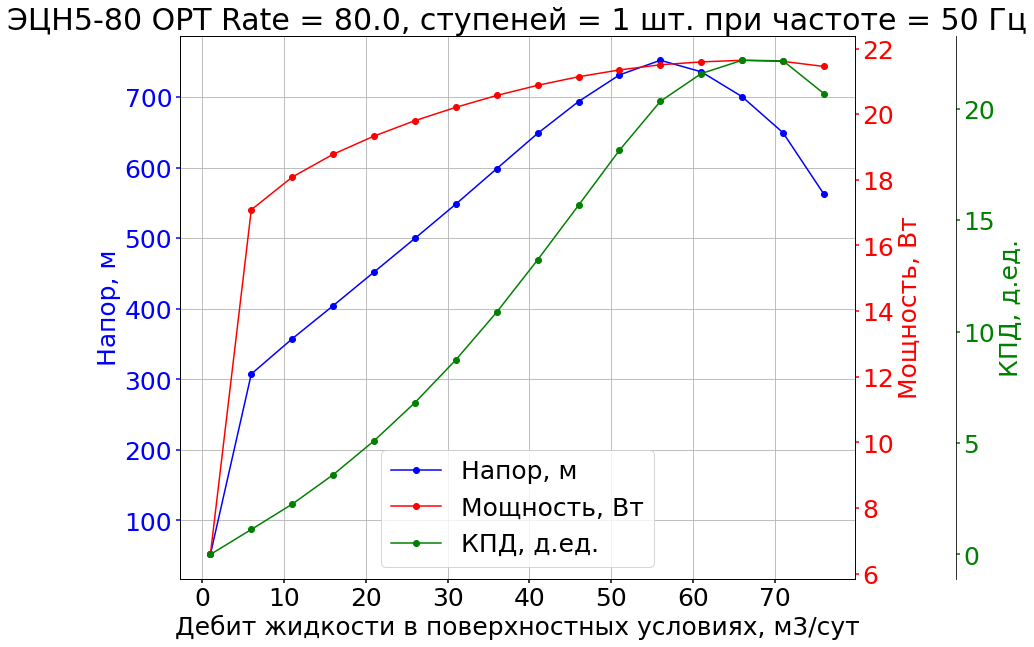

UniflocVBA 7.25


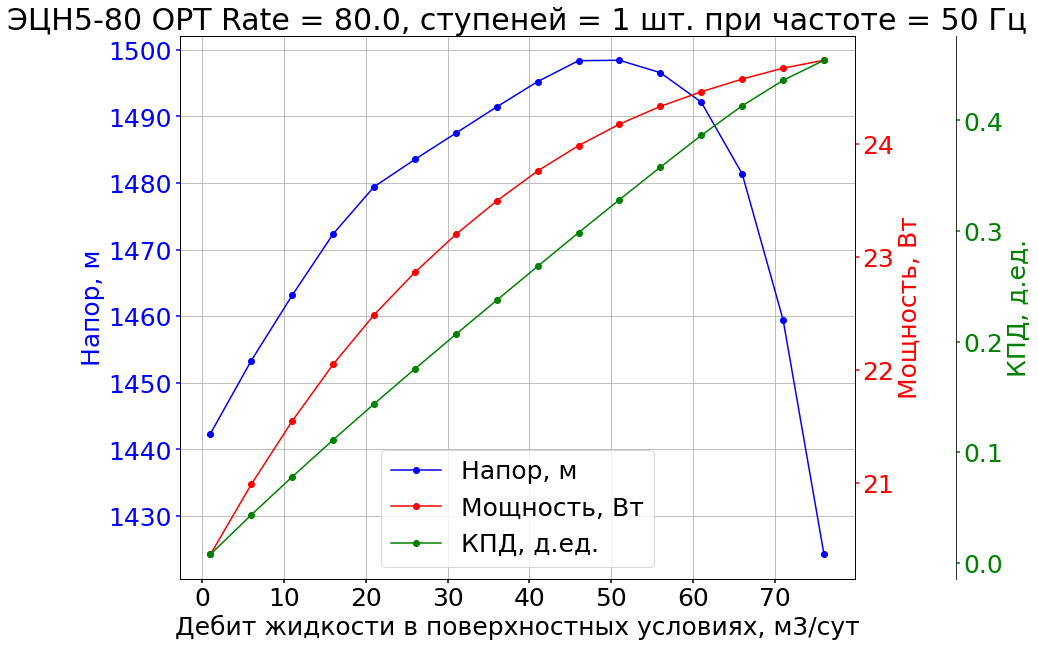

In [12]:
p_intake, t_intake = 50, 70
params['ksep_fr'] = 0.7
params['qliq_sm3day_range'] = np.arange(1, 80, 5)
d = params.copy()
str_PVT_tube = api.PVT_encode_string(gamma_gas=d['gamma_gas'],
                gamma_oil=d['gamma_oil'],
                gamma_wat=d['gamma_wat'],
                rsb_m3m3=d['rsb_m3m3'],
                rp_m3m3=d['rp_m3m3'],
                pb_atma=d['pb_atma'],
                t_res_C=d['t_res_C'],
                bob_m3m3=d['bob_m3m3'],
                muob_cP=d['muob_cP'],
                PVTcorr=d['PVTcorr'],
                ksep_fr=d['ksep_fr'],
                p_ksep_atma=float(p_intake),
                t_ksep_C=float(t_intake),
                gas_only=False)
print(f"UniflocVBA 7.28")
plot_pump_curves(params, None, None,  None,  p_intake, t_intake, None, q_mix_pump_mean, 
                 qliq_on_surface=True, vba_version='7.28', api=api, api_new=api_new)
print(f"UniflocVBA 7.25")
plot_pump_curves(params, None, None,  None, p_intake, t_intake, str_PVT_tube, q_mix_pump_mean, 
                 qliq_on_surface=True, vba_version='7.25', api=api, api_new=api_new)

### Определение функции для построения КРД и КРТ

In [13]:
plot_well_curves = well_model.plot_well_curves

### Определения функции calc_model

#### Модель UniflocVBA 7.25

In [14]:
calc_model = well_model.calc_model

In [15]:
p_dis, p_esp_dis, str_PVT_tube, p_intake, t_intake,  eff, head_esp, power_esp, gas_fraction_intake,\
                    casing_pipe, tube_pipe, q_mix_pump_mean, esp_df= calc_model(params, m_api=api)

In [16]:
pd.DataFrame(casing_pipe)

0           1          2        3          4         5   \
0         90.9833     85.7119    90.9833  85.7119        100        86   
1   p_result_atma  t_result_C  p_1, atma   t_1, C  p_2, atma    t_2, C   
2             num         h,m    hvert,m   p,atma        t,C        Hl   
3               1        2661       2661  90.9833    85.7119  0.958497   
4               2     2667.05    2667.05  91.4576    85.7293  0.959207   
5               3     2673.11    2673.11  91.9318    85.7468  0.959918   
6               4     2679.16    2679.16  92.4061    85.7642  0.960628   
7               5     2685.21    2685.21  92.8803    85.7817  0.961339   
8               6     2691.26    2691.26  93.3546    85.7991  0.962049   
9               7     2697.32    2697.32  93.8288    85.8165   0.96276   
10              8     2703.37    2703.37   94.303     85.834   0.96347   
11              9     2709.42    2709.42  94.7773    85.8514  0.964181   
12             10     2715.47    2715.47  95.2515    85.8689  0.964891   
13             11     2721.53    2721.53  95.7258    85.8863  0.965602   
14             12     2727.58    2727.58     96.2    85.9038  0.966312   
15             13     2733.63    2733.63  96.6743    85.9212  0.967023   
16             14     2739.68    2739.68  97.1485    85.9387  0.967733   
17             15     2745.74    2745.74  97.6227    85.9561  0.968444   
18             16     2751.79    2751.79   98.097    85.9736  0.969154   
19             17     2757.84    2757.84  98.5712     85.991  0.969865   
20             18     2763.89    2763.89  99.0466    86.0001  0.970557   
21             19     2769.95    2769.95  99.5233         86  0.971231   
22             20        2776       2776      100         86  0.971904   

               6              7             8             9   ...        31  \
0               1              1        5337.7             0  ...         0   
1   c_calibr_grav  c_calibr_fric  q_gas_sm3day  q_gas_sm3day  ...         0   
2            fpat       t_amb, C       diam, m   c_Roughness  ...  c_rhomix   
3             102        83.2659         0.159        0.0001  ...   699.533   
4             102        83.4098         0.159        0.0001  ...   701.684   
5             102        83.5537         0.159        0.0001  ...   703.835   
6             102        83.6976         0.159        0.0001  ...   705.986   
7             102        83.8415         0.159        0.0001  ...   708.137   
8             102        83.9854         0.159        0.0001  ...   710.288   
9             102        84.1293         0.159        0.0001  ...   712.438   
10            102        84.2732         0.159        0.0001  ...   714.589   
11            102        84.4171         0.159        0.0001  ...    716.74   
12            102         84.561         0.159        0.0001  ...   718.891   
13            102        84.7049         0.159        0.0001  ...   721.042   
14            102        84.8488         0.159        0.0001  ...   723.193   
15            102        84.9927         0.159        0.0001  ...   725.344   
16            102        85.1366         0.159        0.0001  ...   727.495   
17            102        85.2805         0.159        0.0001  ...   729.645   
18            102        85.4244         0.159        0.0001  ...   731.796   
19            102        85.5683         0.159        0.0001  ...   733.947   
20            102        85.7122         0.159        0.0001  ...   736.067   
21            102        85.8561         0.159        0.0001  ...   738.153   
22            102             86         0.159        0.0001  ...   740.239   

         32       33       34        35        36         37          38  \
0         0        0        0         0         0          0           0   
1         0        0        0         0         0          0           0   
2      c_qo     c_qw     c_qg      c_mo      c_mw       c_mg        c_vl   
3   70.1078  18.1681  19.3812  0.6461

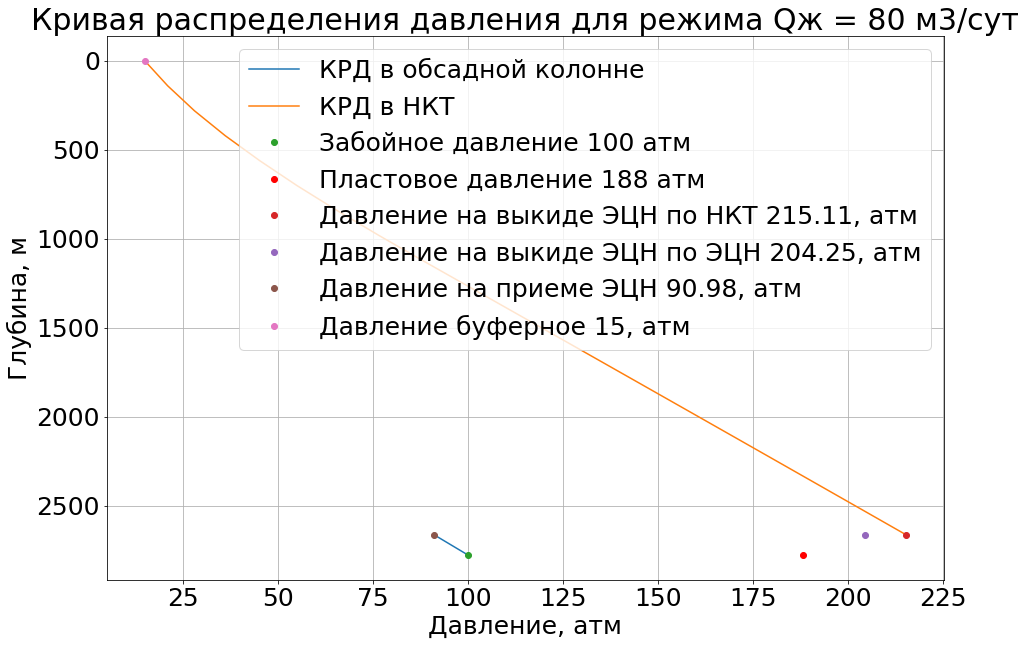

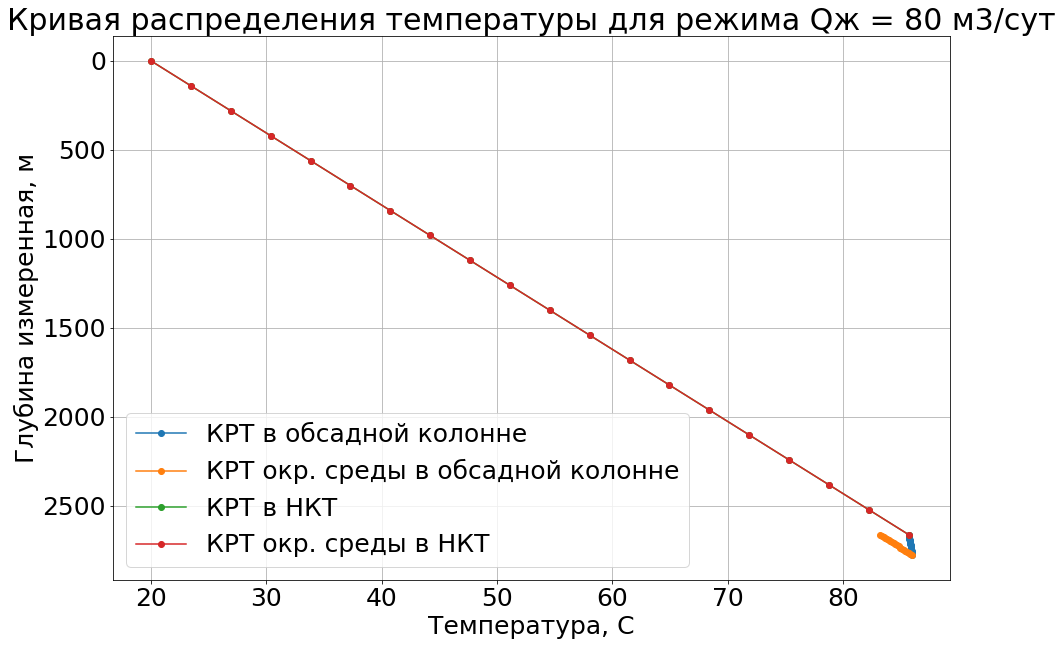

In [17]:
plot_well_curves(p_dis, p_esp_dis, str_PVT_tube, p_intake, t_intake,  eff, head_esp, 
                 power_esp, gas_fraction_intake,
                    casing_pipe, tube_pipe, params)

#### Модель UniflocVBA 7.28

In [18]:
calc_model_new_7_28 = well_model.calc_model_new_7_28

In [19]:
params['temp_method'] = 2

In [20]:
p_dis, p_esp_dis, str_PVT_tube, p_intake, t_intake,  eff, head_esp, power_esp, gas_fraction_intake,\
                    casing_pipe, tube_pipe, q_mix_pump_mean, esp_df= calc_model_new_7_28(params, m_api=api_new)

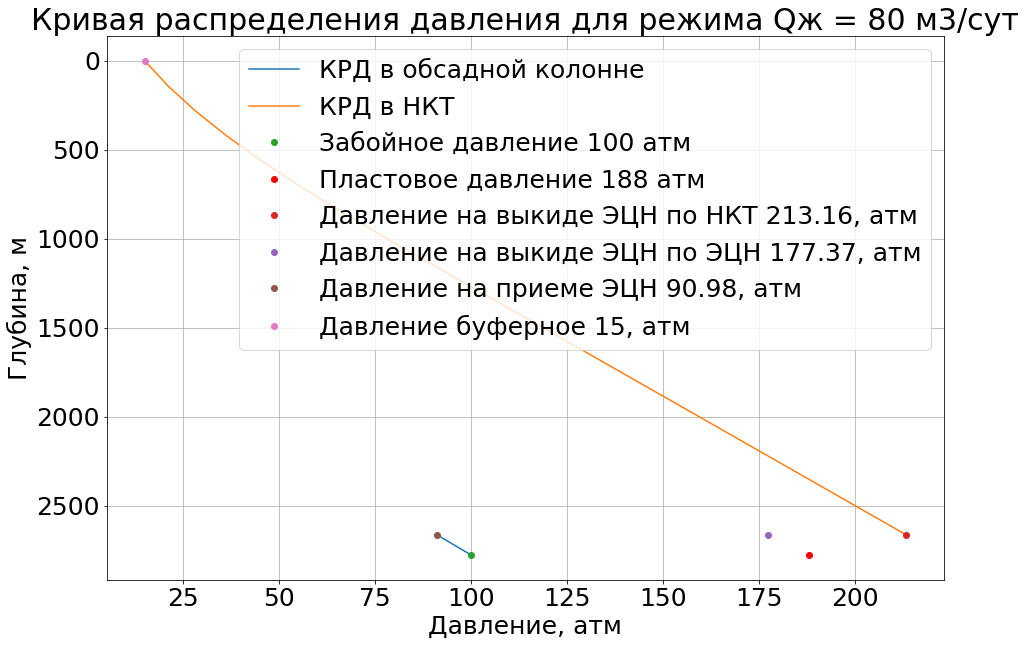

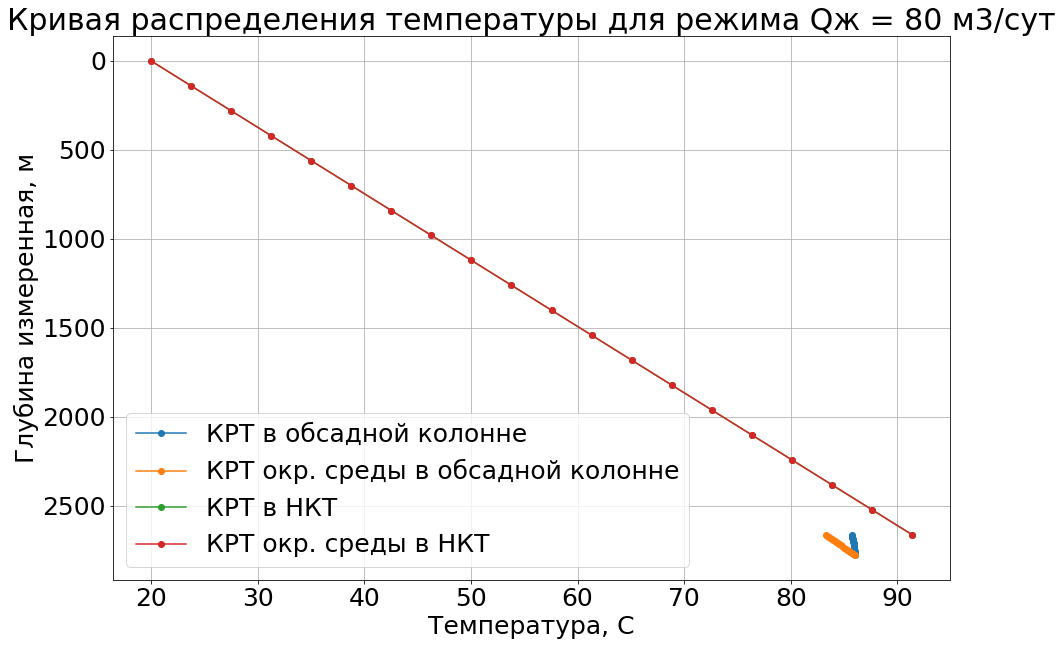

In [21]:
plot_well_curves(p_dis, p_esp_dis, str_PVT_tube, p_intake, t_intake,  eff, head_esp, power_esp, gas_fraction_intake,
                    casing_pipe, tube_pipe, params)

### Функции для построения НРХ в условиях работы

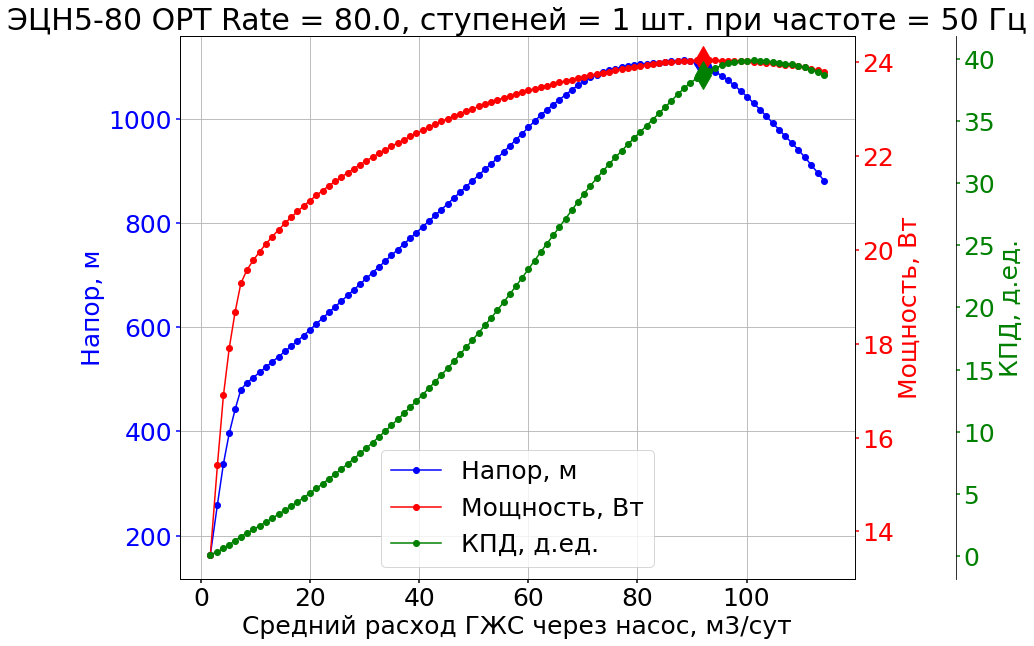

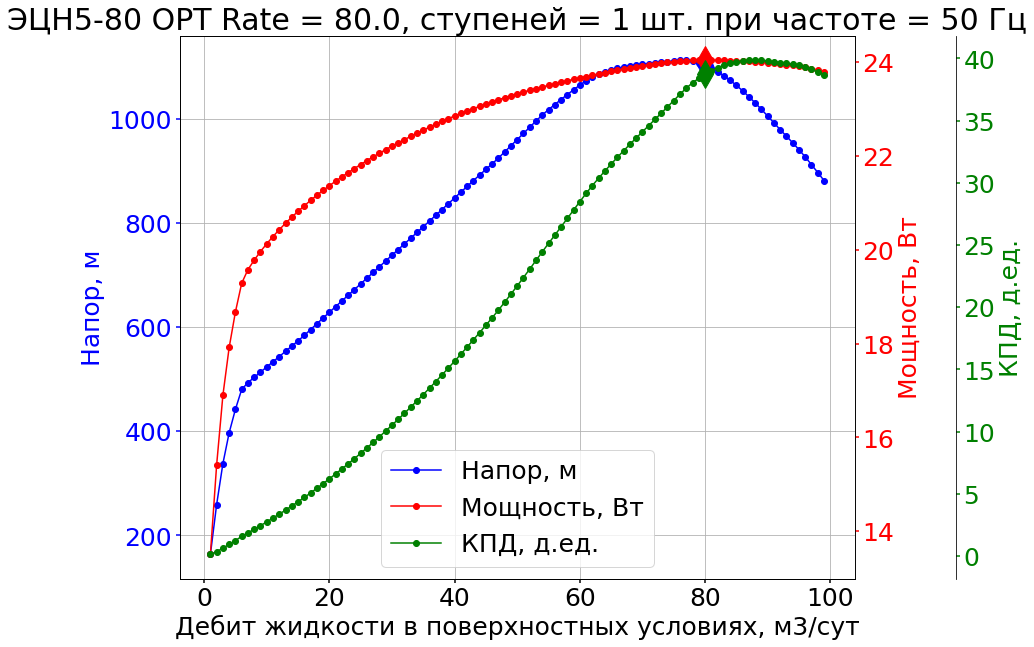

In [22]:
params['qliq_sm3day_range'] = range(1, 100)
plot_pump_curves(params, head_esp, power_esp, eff, p_intake, t_intake, str_PVT_tube, q_mix_pump_mean, qliq_on_surface=False,
                api=api, api_new=api_new)
plot_pump_curves(params, head_esp, power_esp, eff, p_intake, t_intake, str_PVT_tube, q_mix_pump_mean, qliq_on_surface=True,
                api=api, api_new=api_new)

## Определение основной расчетной функции узлового анализа

In [23]:
calc_all = well_model.calc_all

save_in_df = well_model.save_in_df



In [24]:
#os.system("taskkill /f /im EXCEL.EXE")

# Проверка рабочей функции

In [25]:
params_saved = params.copy()
params_saved

{'gamma_gas': 0.7,
 'gamma_oil': 0.844,
 'gamma_wat': 1.014,
 'rsb_m3m3': 85.54,
 'rp_m3m3': 85.54,
 'pb_atma': 123,
 't_res_C': 86,
 'bob_m3m3': 1.166,
 'muob_cP': 1.01,
 'PVTcorr': 0,
 'ksep_fr': 0.7,
 'p_bhp_atm': 100,
 'p_wh_atm': 15,
 't_wh_c': 20,
 'h_list_m': 2776,
 'h_pump_m': 2661,
 'diam_list_mm_casing': 159,
 'diam_list_mm_tube': 67.8,
 'gas_fraction_intake_d': 0.2,
 'qliq_sm3day': 80,
 'n_dots_for_nodal': 50,
 'qliq_sm3day_range': range(1, 100),
 'fw_perc': 22,
 'hydr_corr': 1,
 'temp_method': 2,
 'freq_Hz': 60,
 'pump_id': 1185,
 'num_stages': 200,
 'pi_sm3dayatm': 0.9,
 'pres_atma': 188,
 'calc_esp_new': 1,
 'esp_head_m': 2750,
 'ESP_gas_correct': 5}



UniflocVBA 7.28


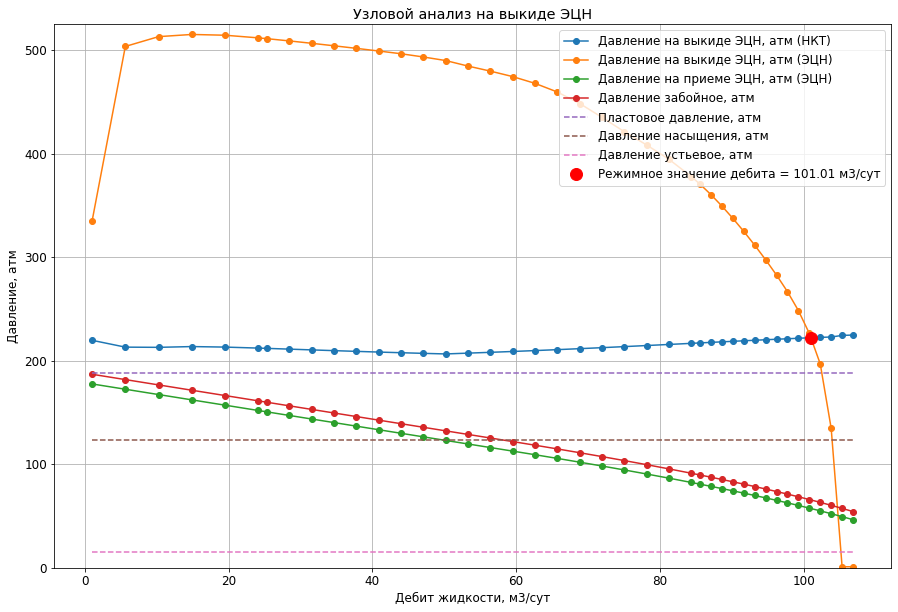

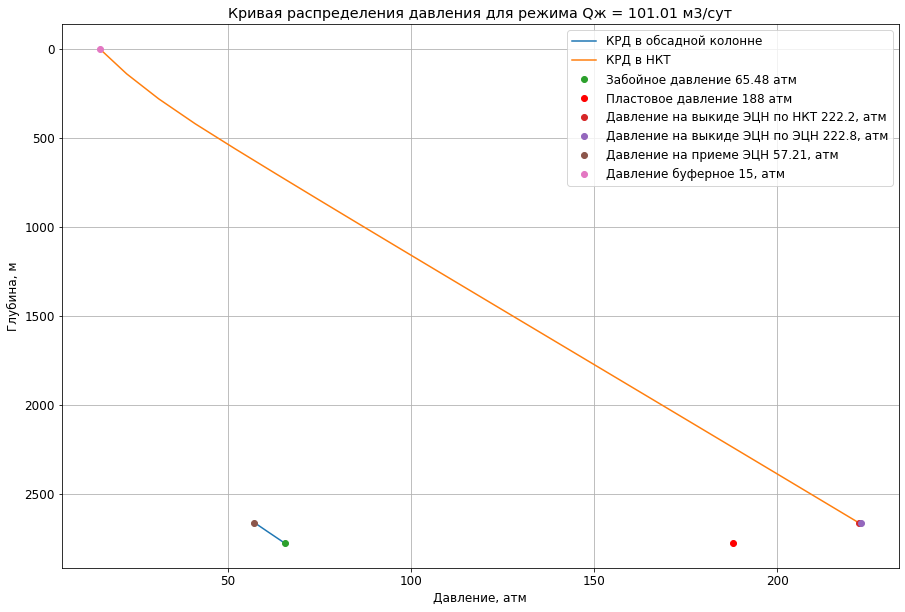

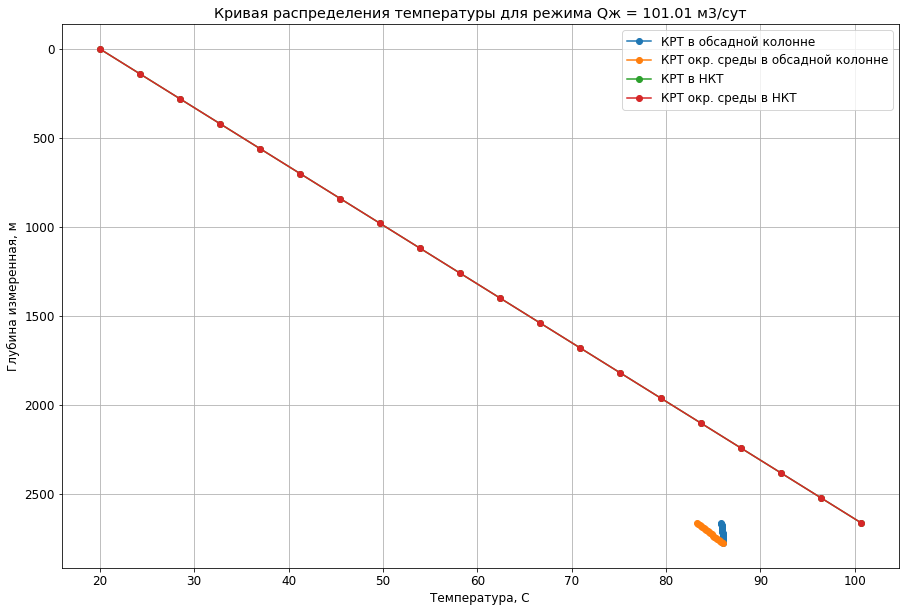

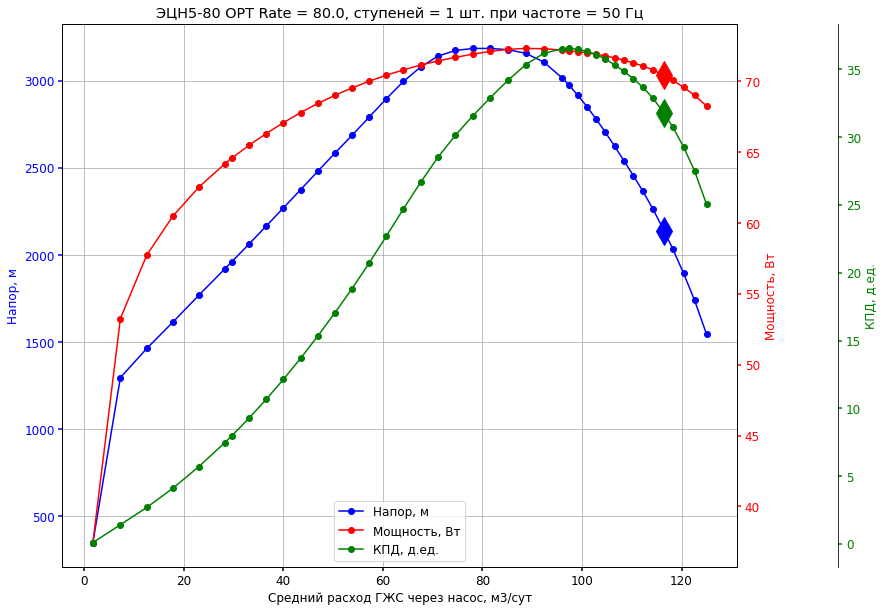

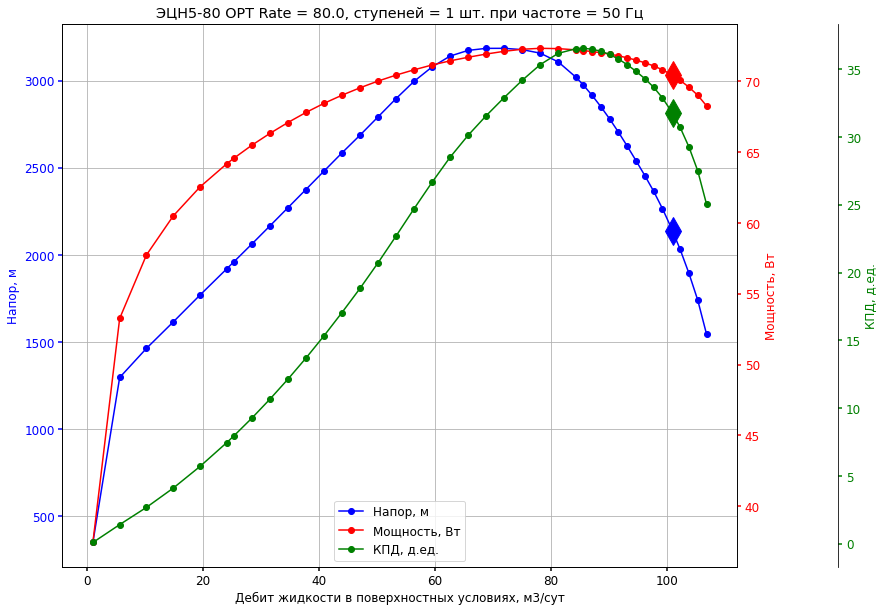

norm calculation sucessful


In [26]:
matplotlib.rcParams.update({'font.size': 12})

params = mult.params.copy()
params['n_dots_for_nodal']  = 20

params['freq_Hz'] = 60
#params['ESP_gas_correct'] = 5
#params['pi_sm3dayatm'] = 0.9
#params['h_pump_m'] = 2661
#params['ksep_fr'] = 0.8
#params['p_wh_atm'] = 15
params['num_stages'] = 604


casing_pipe, tube_pipe, h_mes, head_esp, eff, power_esp, q_liq, status, gas_fraction_intake,\
p_bhp_atm, p_dis, p_esp_dis, json_params, q_mix_pump_mean, esp_df  = calc_all(params, debug=1, vba_version='7.28',
                                                                             api=api, api_new=api_new)

## Анализ системы (анализ чувствительности для узлового анализа)

In [27]:
sens_params = params.copy()
sens_params

{'gamma_gas': 0.7,
 'gamma_oil': 0.844,
 'gamma_wat': 1.014,
 'rsb_m3m3': 85.54,
 'rp_m3m3': 85.54,
 'pb_atma': 123,
 't_res_C': 86,
 'bob_m3m3': 1.166,
 'muob_cP': 1.01,
 'PVTcorr': 0,
 'ksep_fr': 0.8,
 'p_bhp_atm': 65.48310121098282,
 'p_wh_atm': 15,
 't_wh_c': 20,
 'h_list_m': 2776,
 'h_pump_m': 2661,
 'diam_list_mm_casing': 159,
 'diam_list_mm_tube': 67.8,
 'gas_fraction_intake_d': 0.2,
 'qliq_sm3day': 101.00558572064647,
 'n_dots_for_nodal': 20,
 'qliq_sm3day_range': array([  1.        ,   5.62197939,  10.24395877,  14.86593816,
         19.48791754,  24.10989693,  25.31539177,  28.42429953,
         31.53320729,  34.64211506,  37.75102282,  40.85993058,
         43.96883834,  47.0777461 ,  50.18665386,  53.29556162,
         56.40446939,  59.51337715,  62.62228491,  65.73119267,
         68.84010043,  71.94900819,  75.05791596,  78.16682372,
         81.27573148,  84.38463924,  85.59013409,  87.11010585,
         88.63007761,  90.15004937,  91.67002114,  93.1899929 ,
         94.

### Коэффициент продуктивности

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]



i 0.5


UniflocVBA 7.28


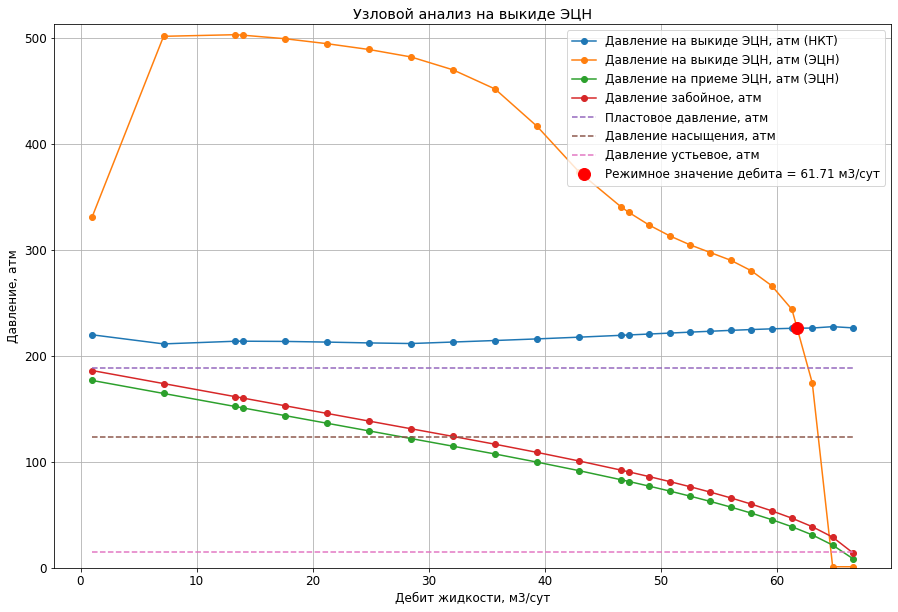

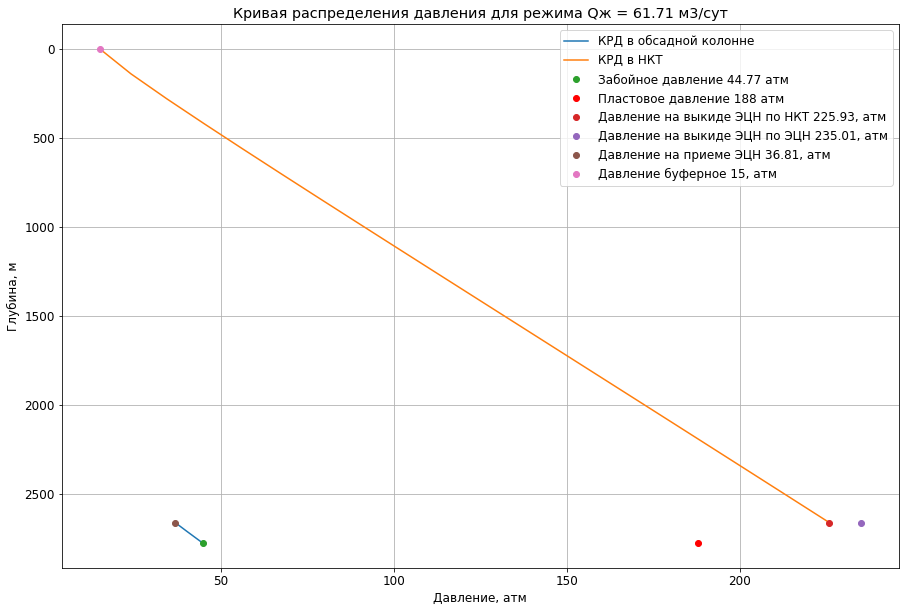

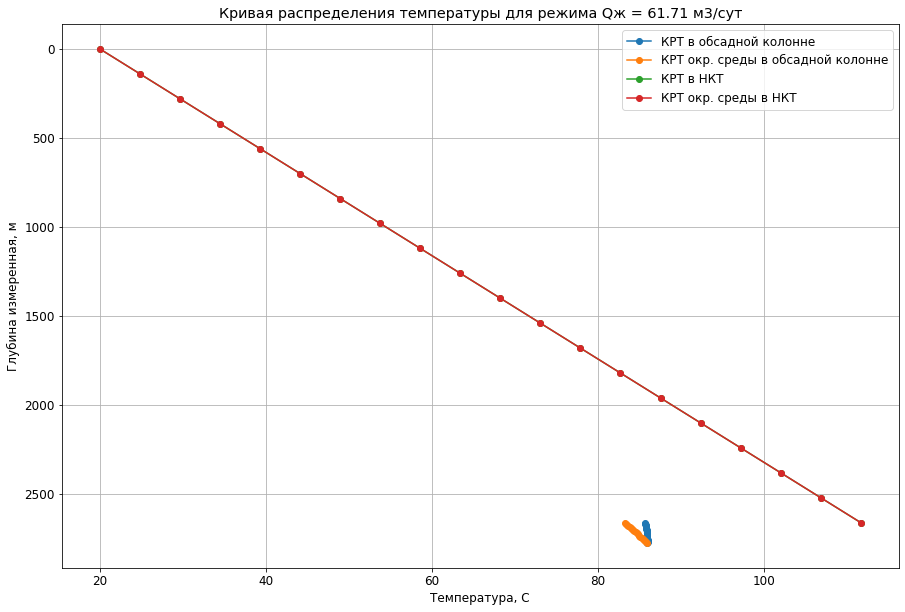

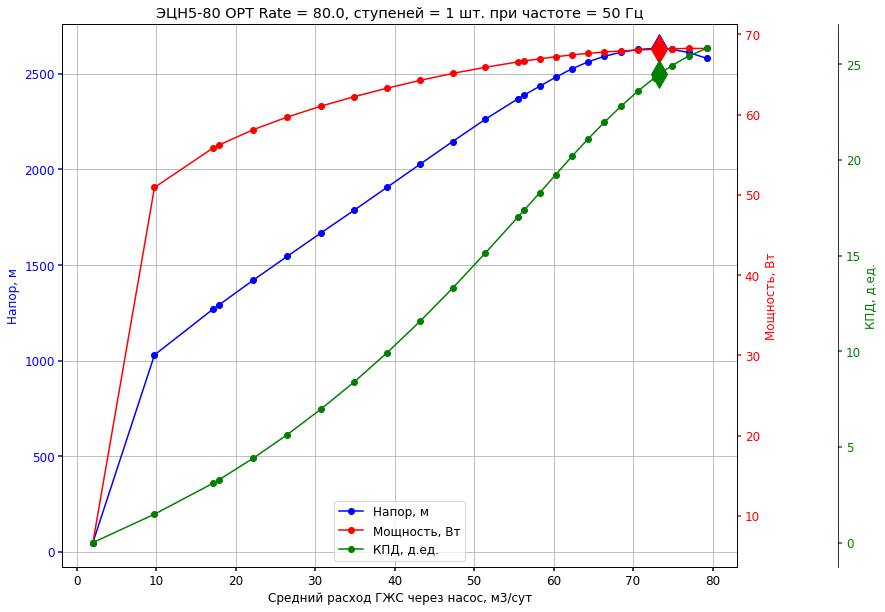

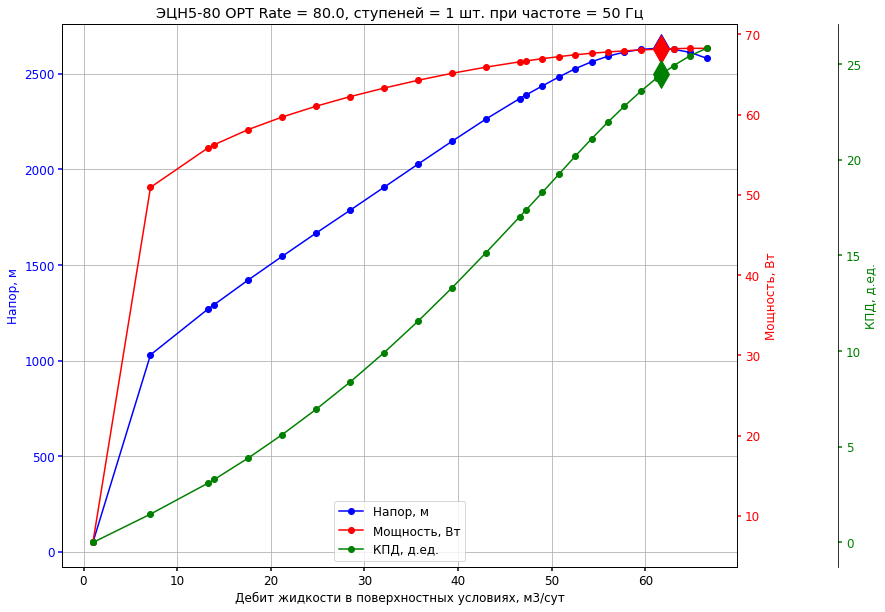

 11%|█████████▎                                                                          | 1/9 [00:07<00:56,  7.05s/it]

norm calculation sucessful
('head_esp', 2632.5112585719166, 'eff', 24.46503467132825, 'power_esp', 68.15392241631285, 'q_liq', 61.714361273366855, 'gas_fraction_intake', 23.448771231462352, 'p_bhp_atm', 44.774970546980576, 'p_dis', 225.93130030405928, 'p_esp_dis', 235.01045971640798, 'q_mix_pump_mean', 73.26183112036155)


i 0.8


UniflocVBA 7.28


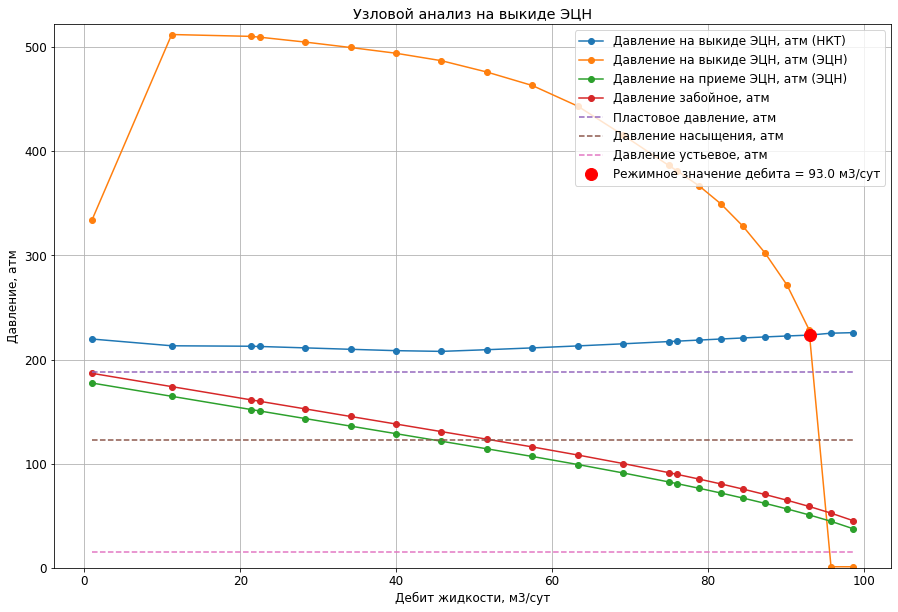

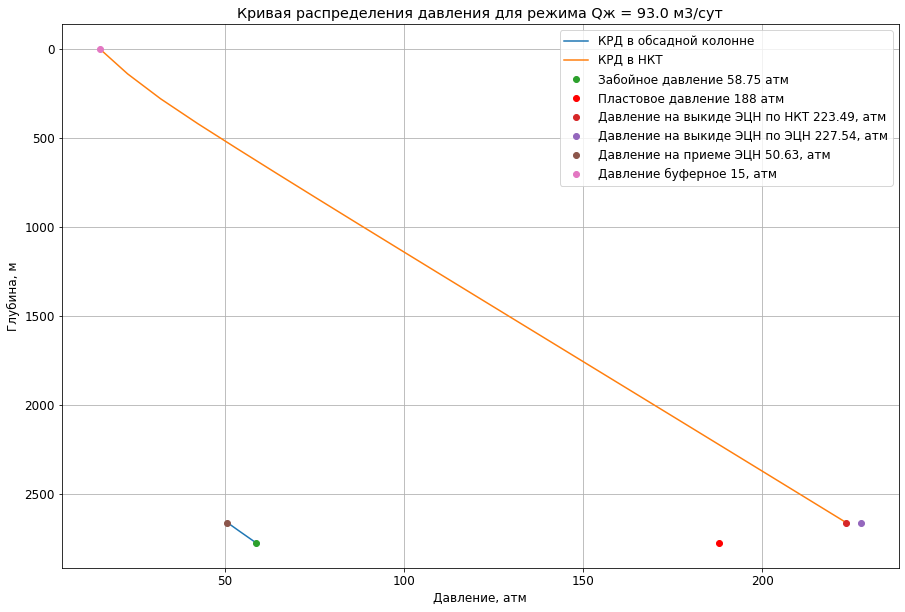

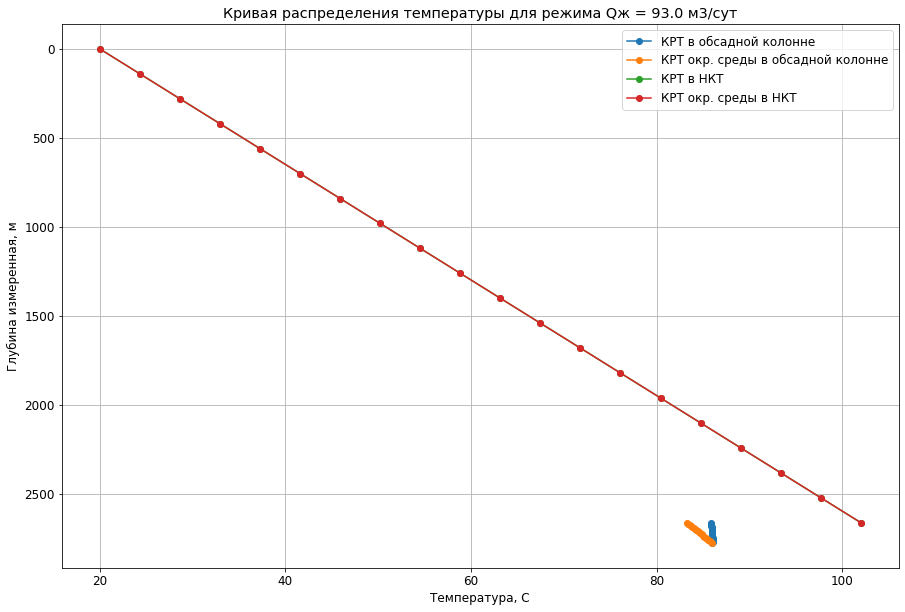

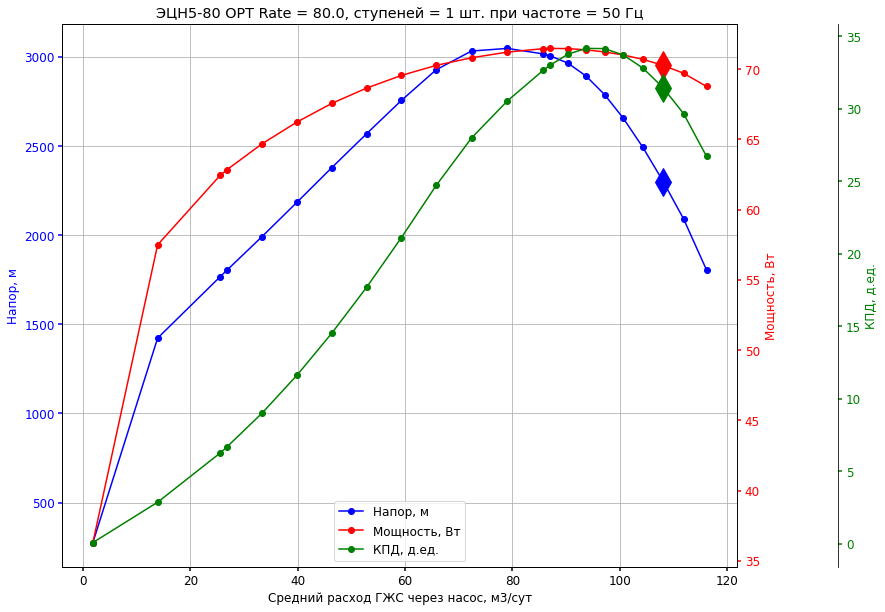

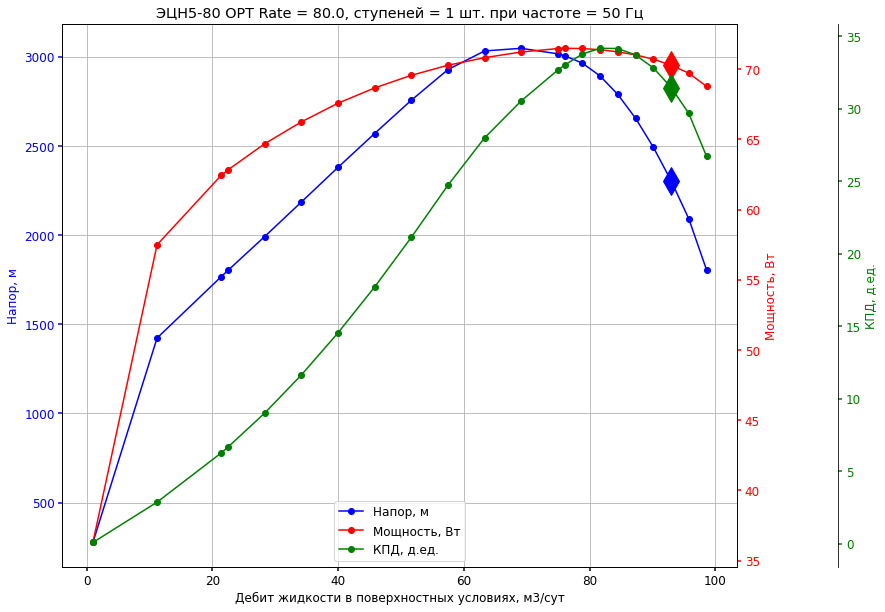

 22%|██████████████████▋                                                                 | 2/9 [00:13<00:47,  6.84s/it]

norm calculation sucessful
('head_esp', 2300.9700177271343, 'eff', 31.438368072447332, 'power_esp', 70.27522628973203, 'q_liq', 92.99951412015297, 'gas_fraction_intake', 15.621875481819602, 'p_bhp_atm', 58.75010302368965, 'p_dis', 223.48839128735435, 'p_esp_dis', 227.54375652930622, 'q_mix_pump_mean', 108.10839936075347)


i 1.1


UniflocVBA 7.28


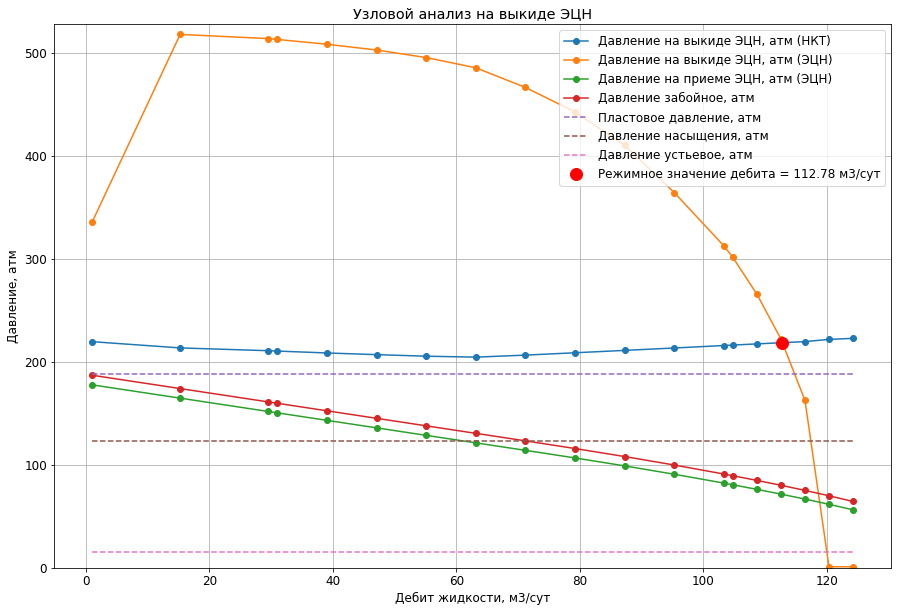

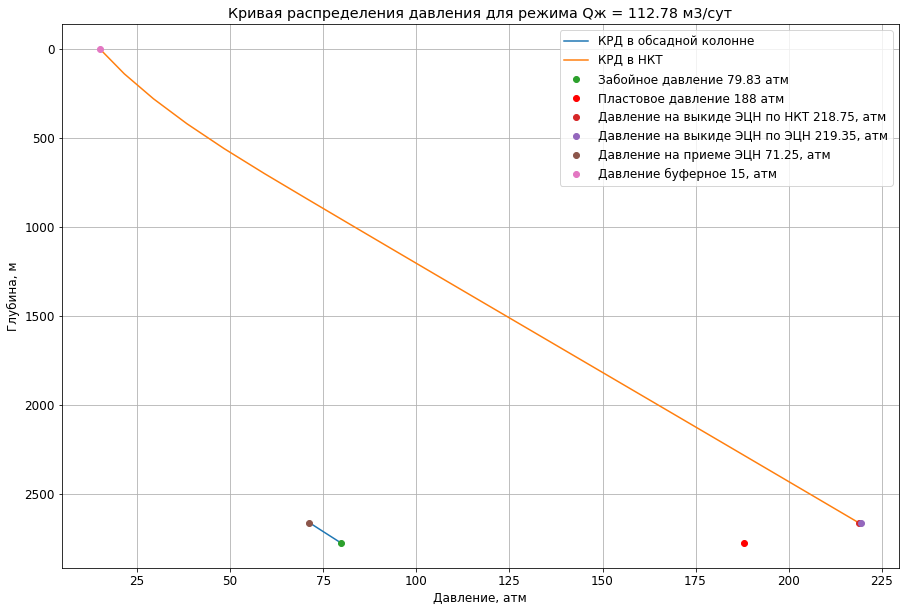

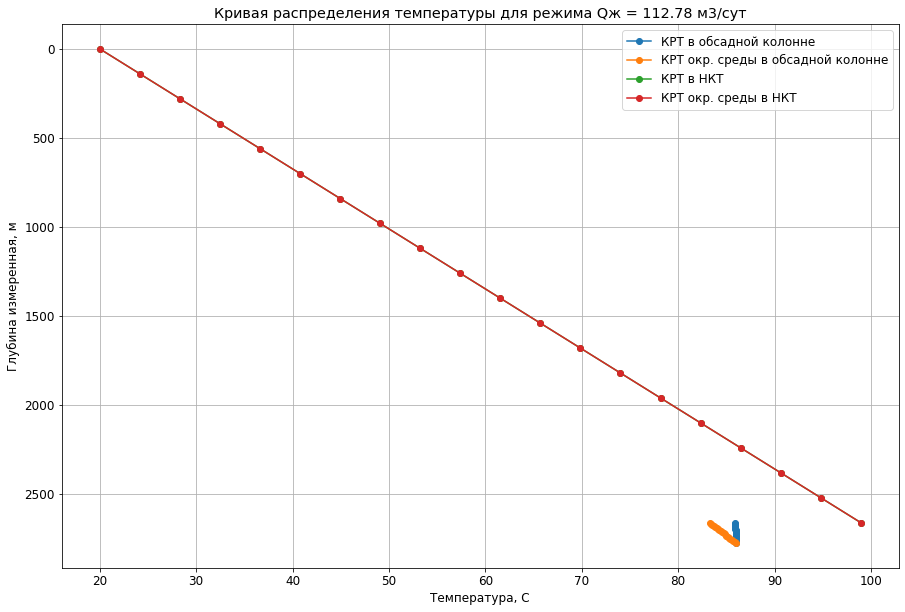

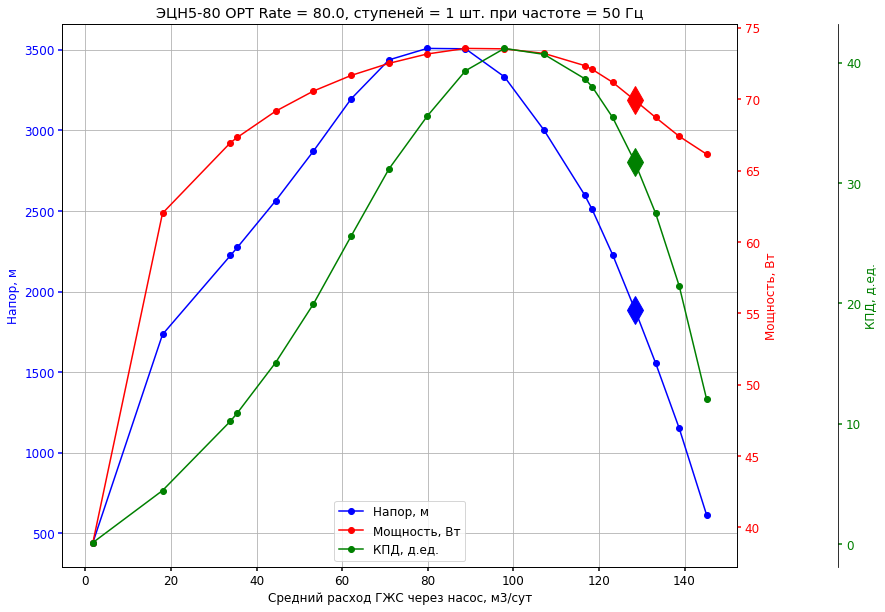

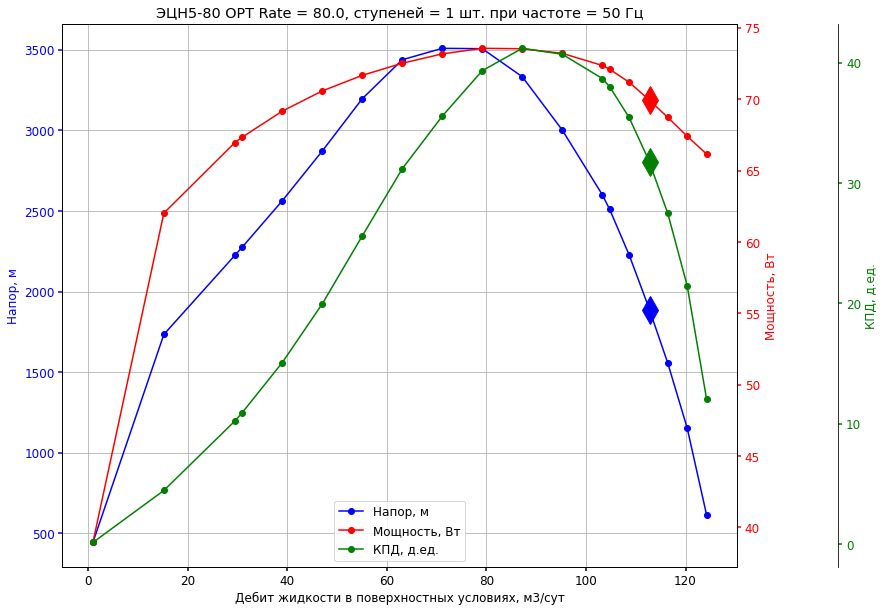

 33%|████████████████████████████                                                        | 3/9 [00:19<00:39,  6.58s/it]

norm calculation sucessful
('head_esp', 1887.150090707486, 'eff', 31.722451059252936, 'power_esp', 69.92685779568848, 'q_liq', 112.77518677998312, 'gas_fraction_intake', 8.446060422565955, 'p_bhp_atm', 79.82970730922784, 'p_dis', 218.7493954264725, 'p_esp_dis', 219.35203086768382, 'q_mix_pump_mean', 128.42269056303283)


i 1.4000000000000001


UniflocVBA 7.28


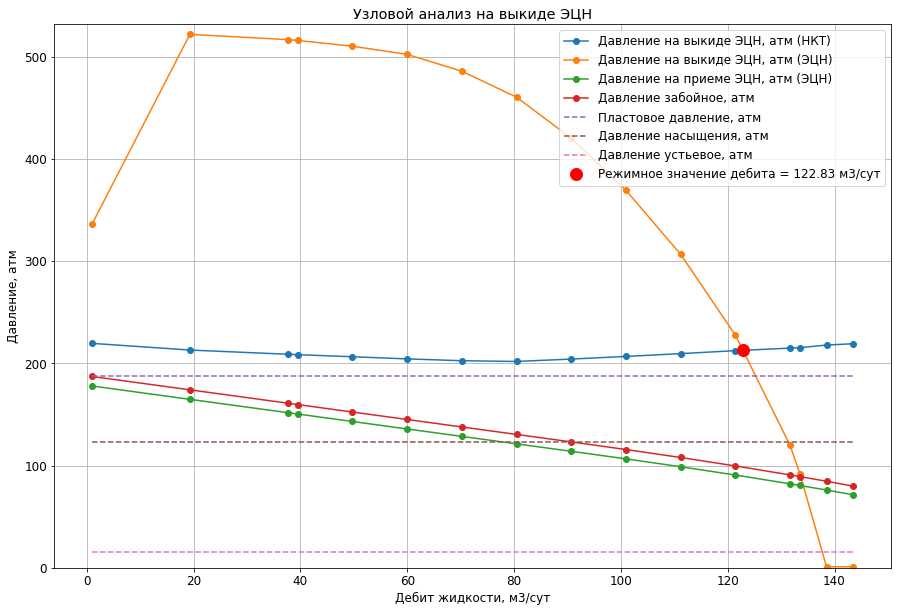

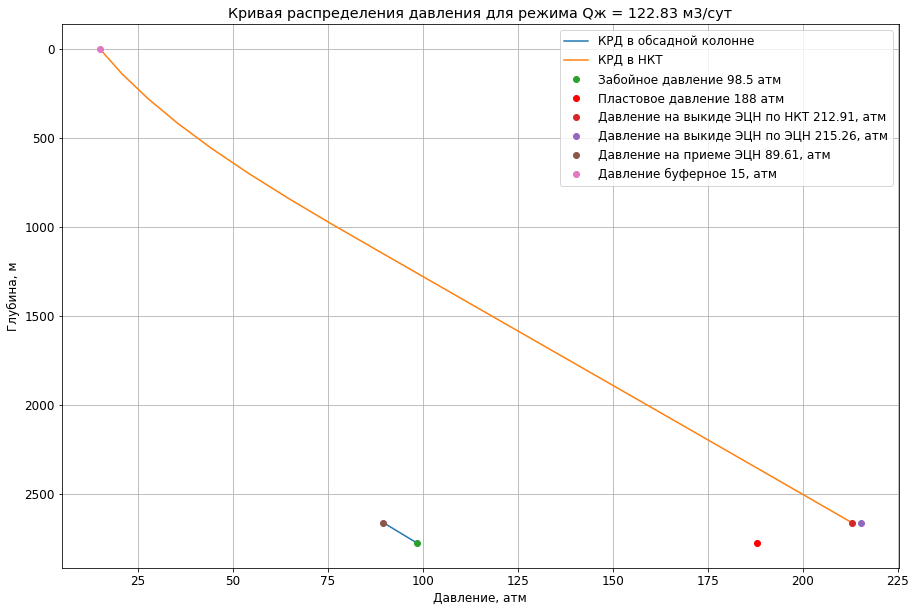

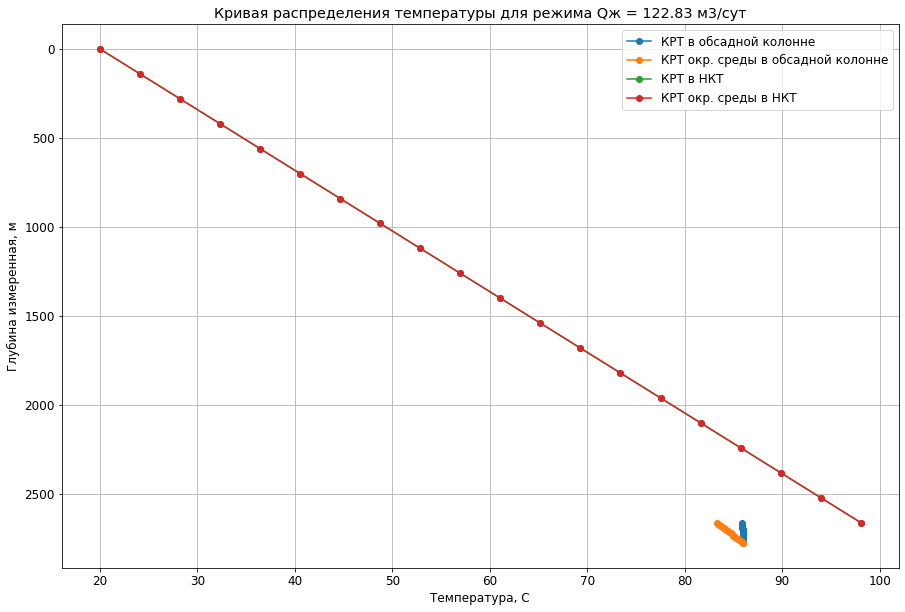

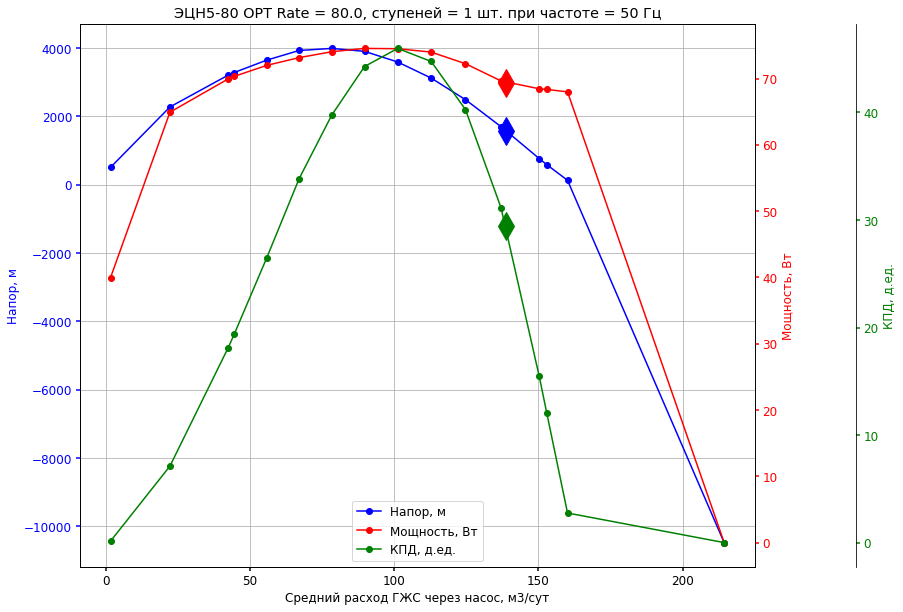

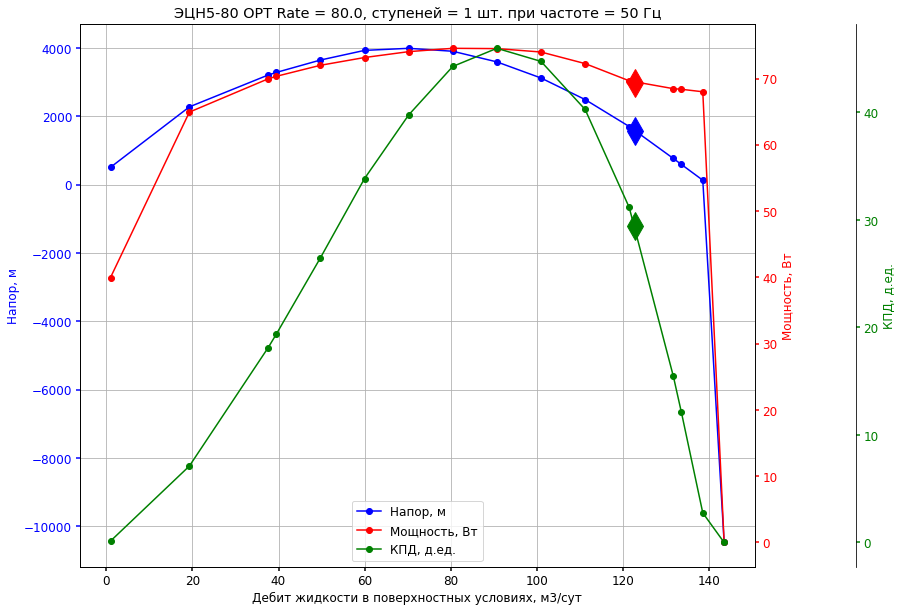

 44%|█████████████████████████████████████▎                                              | 4/9 [00:24<00:30,  6.19s/it]

norm calculation sucessful
('head_esp', 1580.8822586706085, 'eff', 29.453891857049406, 'power_esp', 69.33364586329064, 'q_liq', 122.83357754313876, 'gas_fraction_intake', 4.45414670042923, 'p_bhp_atm', 98.50079303634931, 'p_dis', 212.9132399979417, 'p_esp_dis', 215.25877090030698, 'q_mix_pump_mean', 138.81097146873503)


i 1.7000000000000002


UniflocVBA 7.28


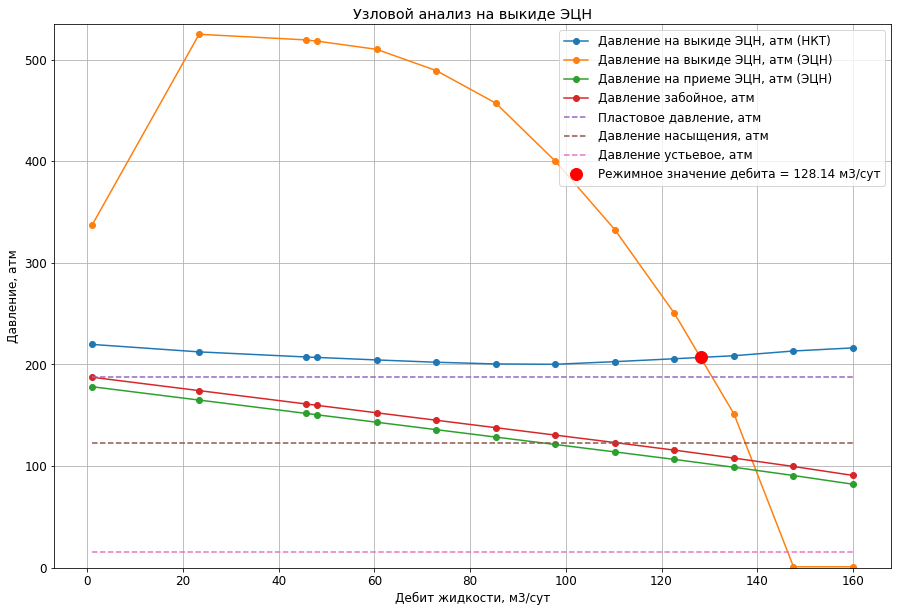

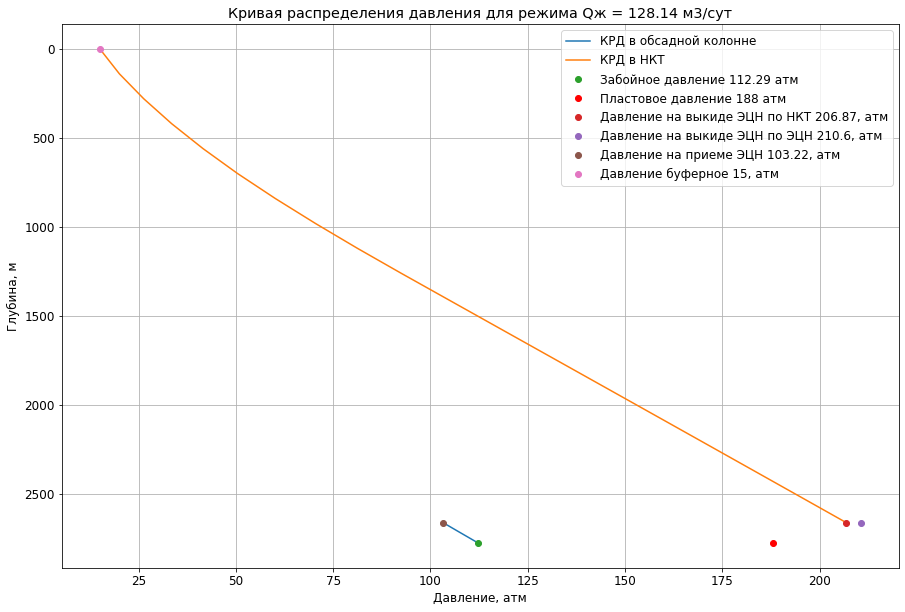

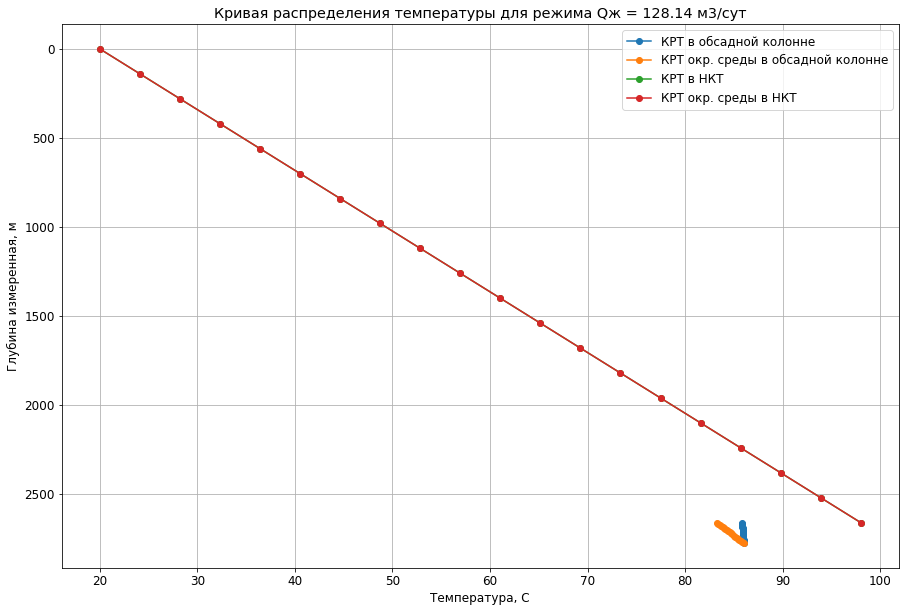

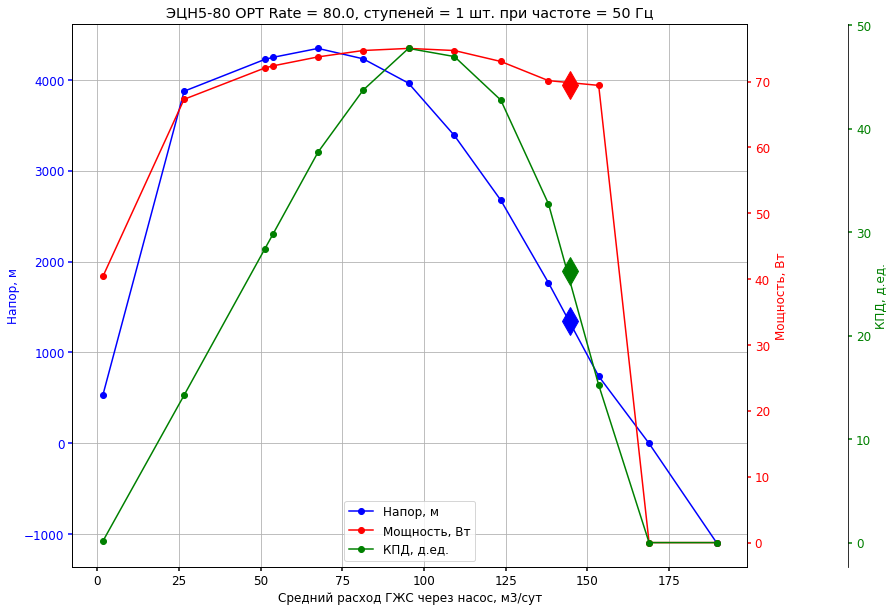

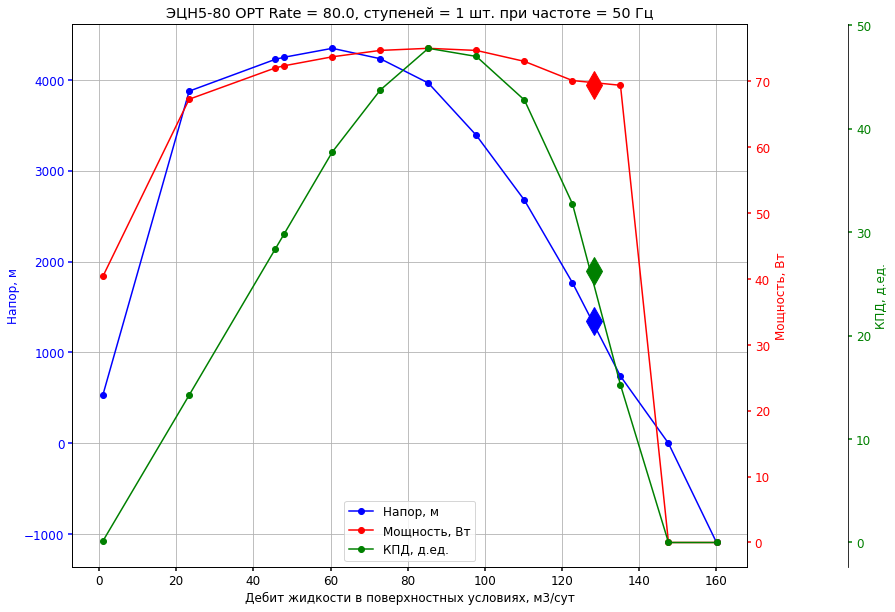

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:29<00:22,  5.71s/it]

norm calculation sucessful
('head_esp', 1342.1698650005578, 'eff', 26.200244676362527, 'power_esp', 69.51219829045962, 'q_liq', 128.14433298766056, 'gas_fraction_intake', 2.3330345839691238, 'p_bhp_atm', 112.29220724984992, 'p_dis', 206.87459183778313, 'p_esp_dis', 210.60018746757657, 'q_mix_pump_mean', 144.70716199965298)


i 2.0


UniflocVBA 7.28


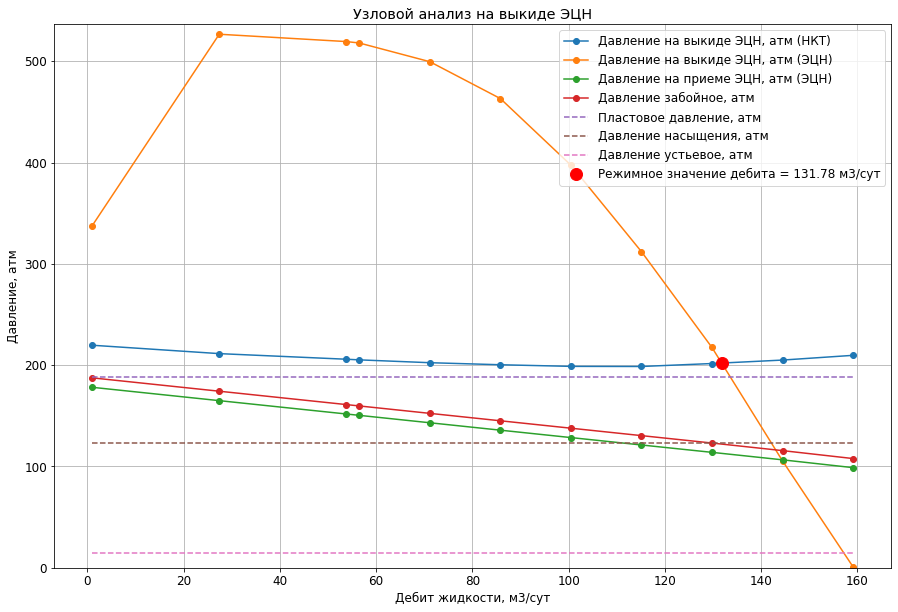

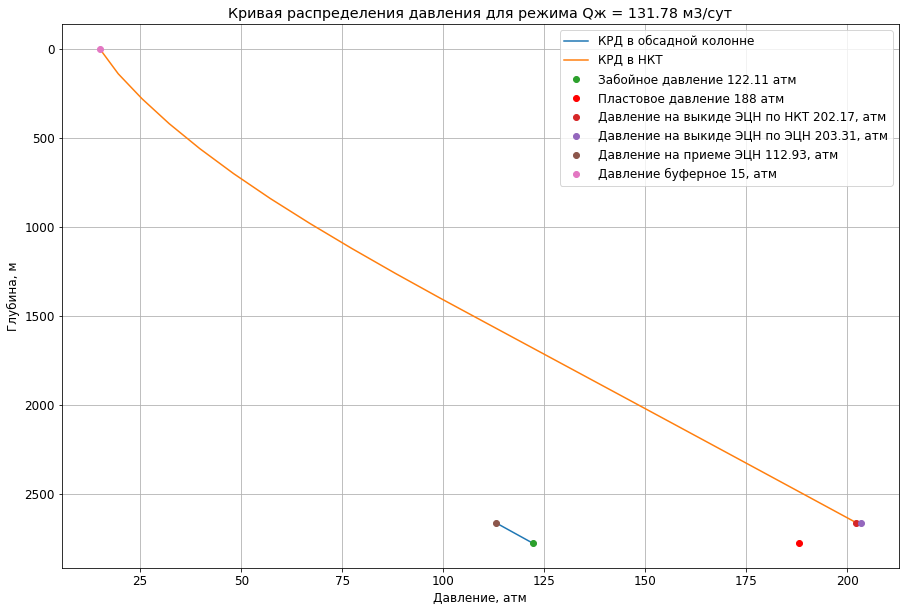

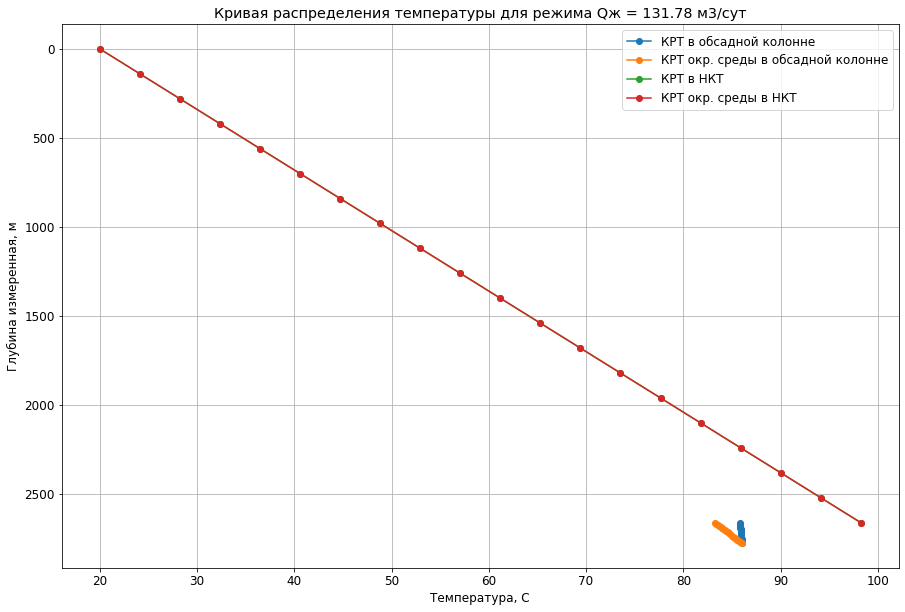

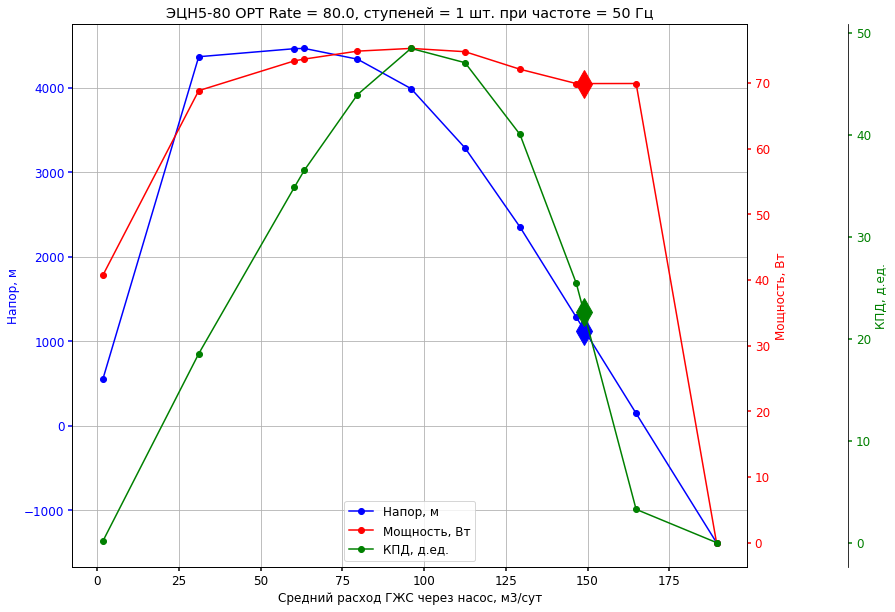

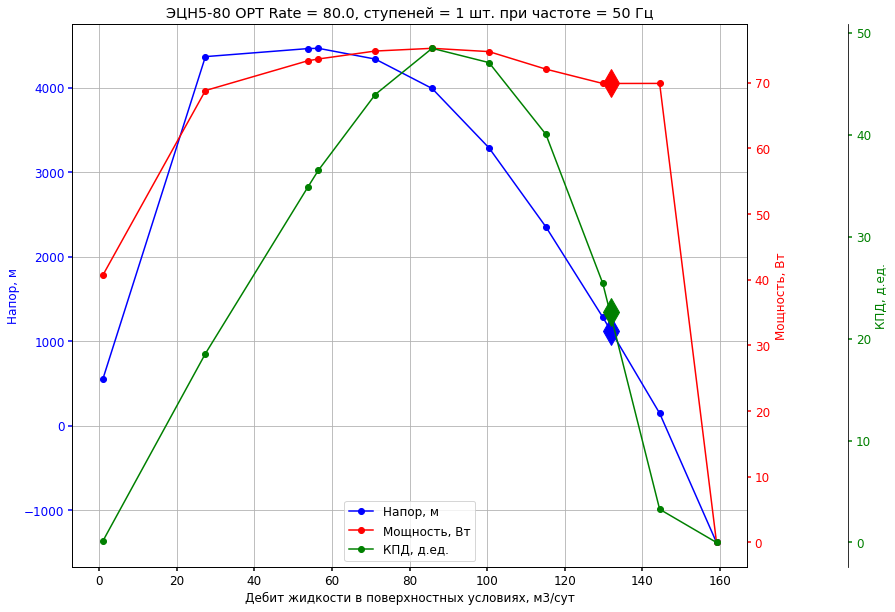

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:33<00:15,  5.22s/it]

norm calculation sucessful
('head_esp', 1125.8912017529588, 'eff', 22.592461445264696, 'power_esp', 69.8936394920319, 'q_liq', 131.7815435033836, 'gas_fraction_intake', 1.116229618751043, 'p_bhp_atm', 122.10697738481691, 'p_dis', 202.1656864052169, 'p_esp_dis', 203.30536144109482, 'q_mix_pump_mean', 149.01521092048833)


i 2.3000000000000003


UniflocVBA 7.28


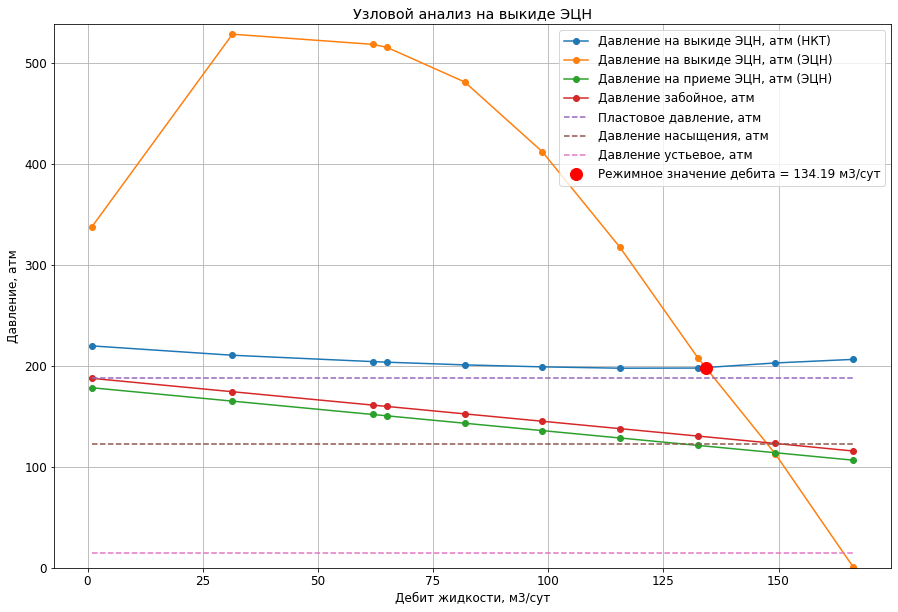

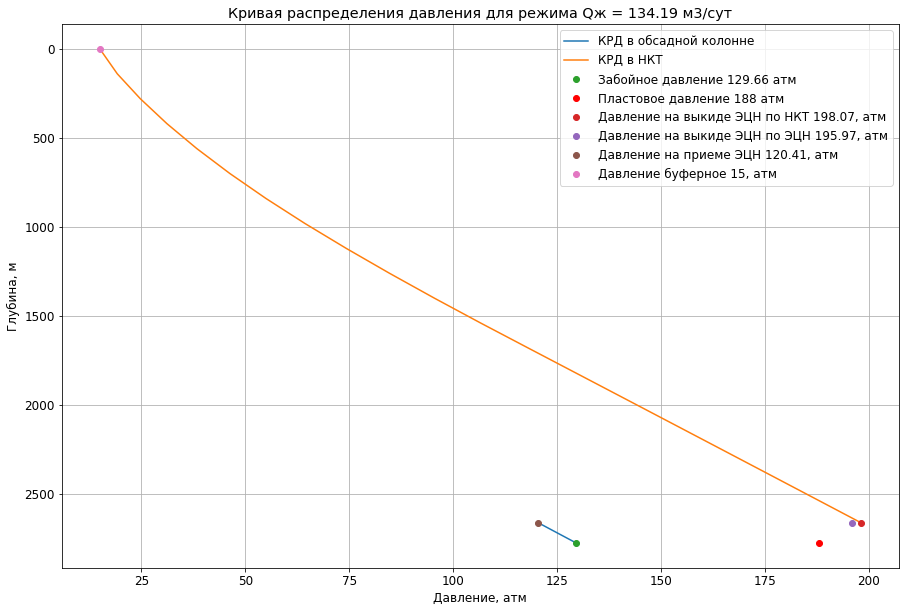

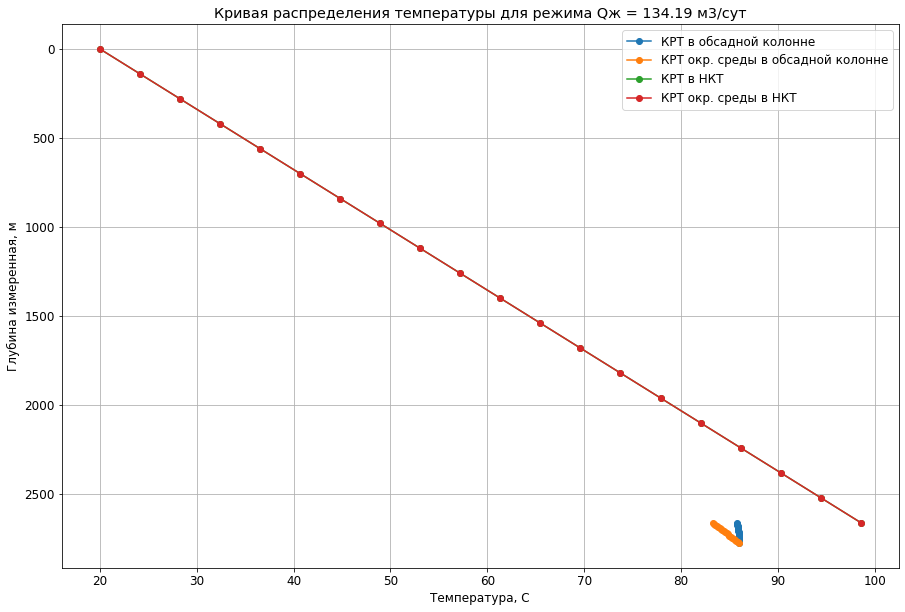

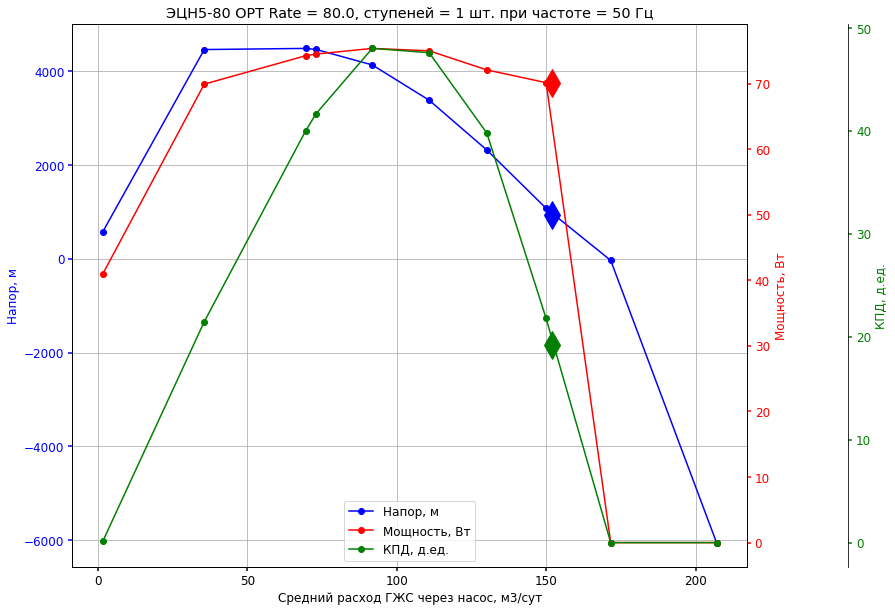

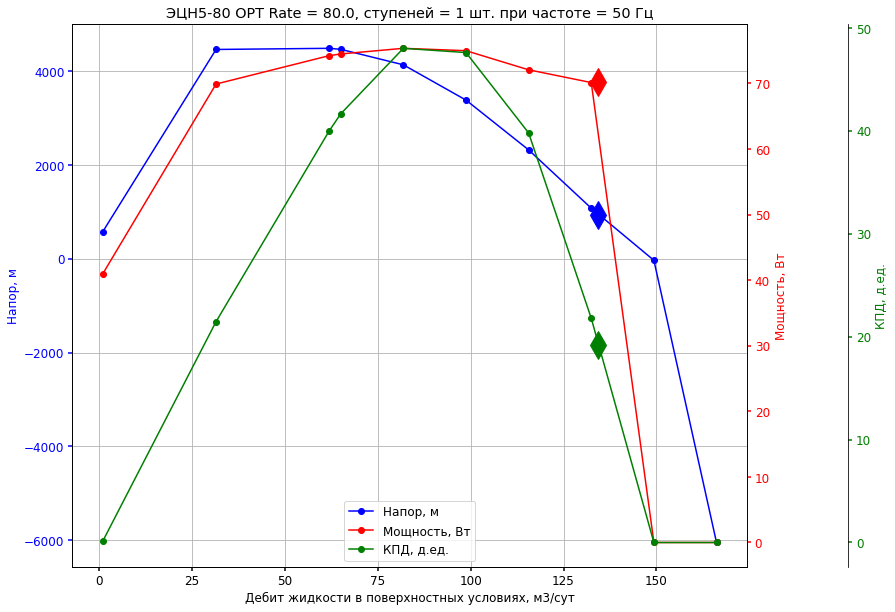

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:37<00:09,  4.95s/it]

norm calculation sucessful
('head_esp', 939.3888960961337, 'eff', 19.198824822716205, 'power_esp', 70.15644344825135, 'q_liq', 134.19088920898903, 'gas_fraction_intake', 0.30648899214846176, 'p_bhp_atm', 129.65613512652652, 'p_dis', 198.0697555012495, 'p_esp_dis', 195.97379499633809, 'q_mix_pump_mean', 152.01836211057707)


i 2.6000000000000005


UniflocVBA 7.28


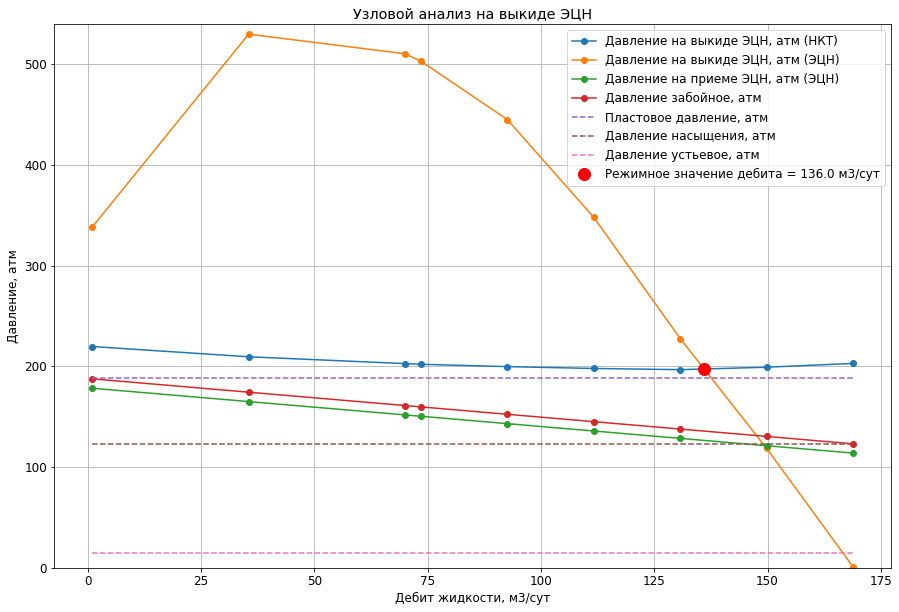

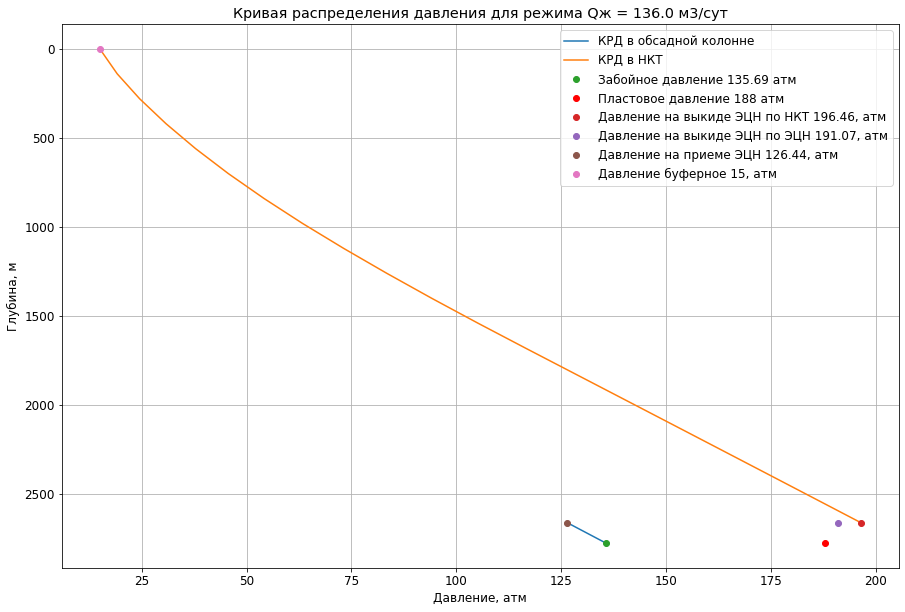

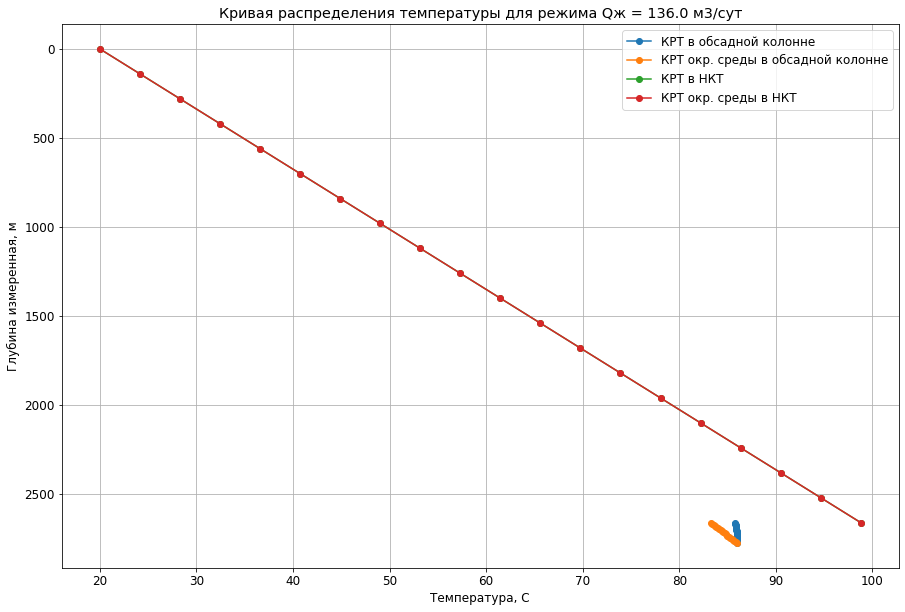

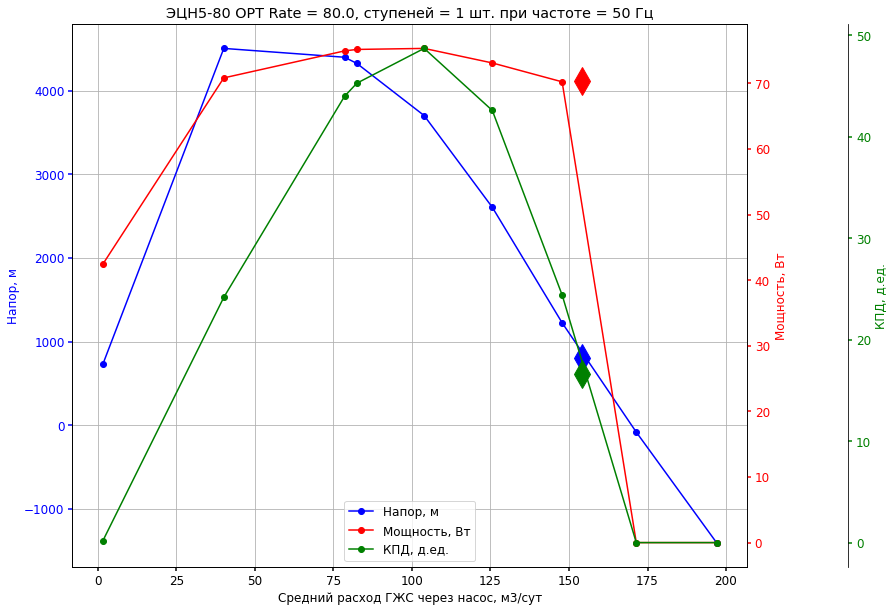

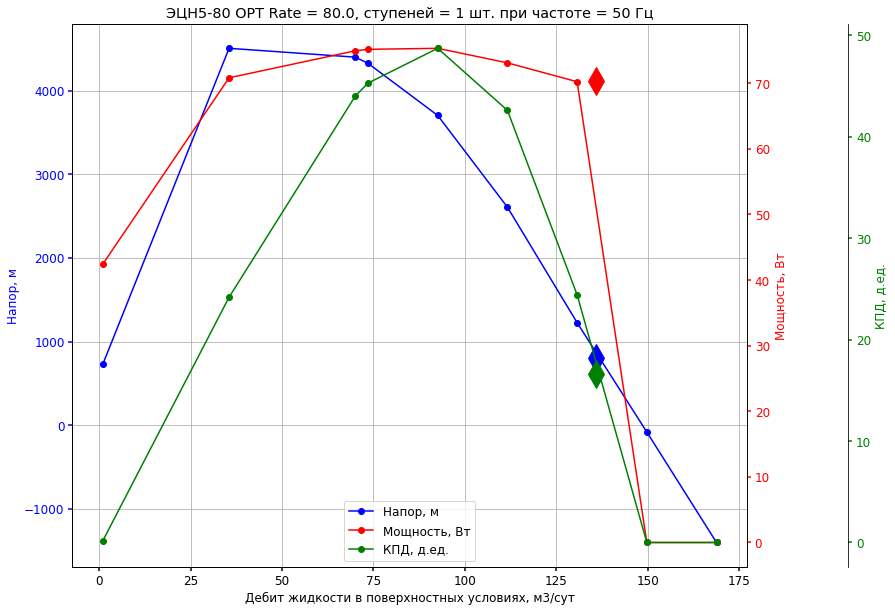

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:41<00:04,  4.57s/it]

norm calculation sucessful
('head_esp', 802.8118421032146, 'eff', 16.618763684931036, 'power_esp', 70.31440370599995, 'q_liq', 136.0018153112215, 'gas_fraction_intake', 0.0, 'p_bhp_atm', 135.69160949568405, 'p_dis', 196.4647021304933, 'p_esp_dis', 191.0715975417793, 'q_mix_pump_mean', 154.1653276380104)


i 2.9000000000000004


UniflocVBA 7.28


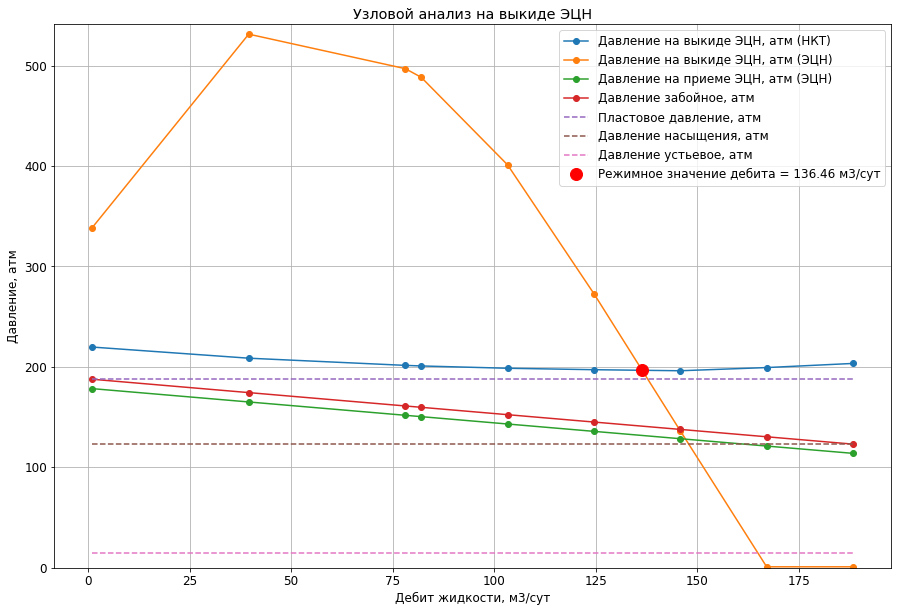

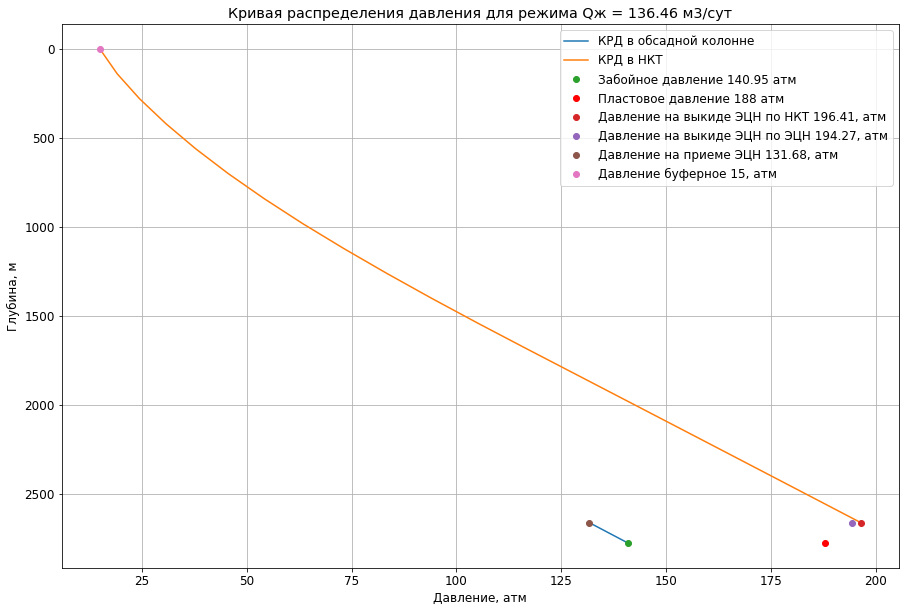

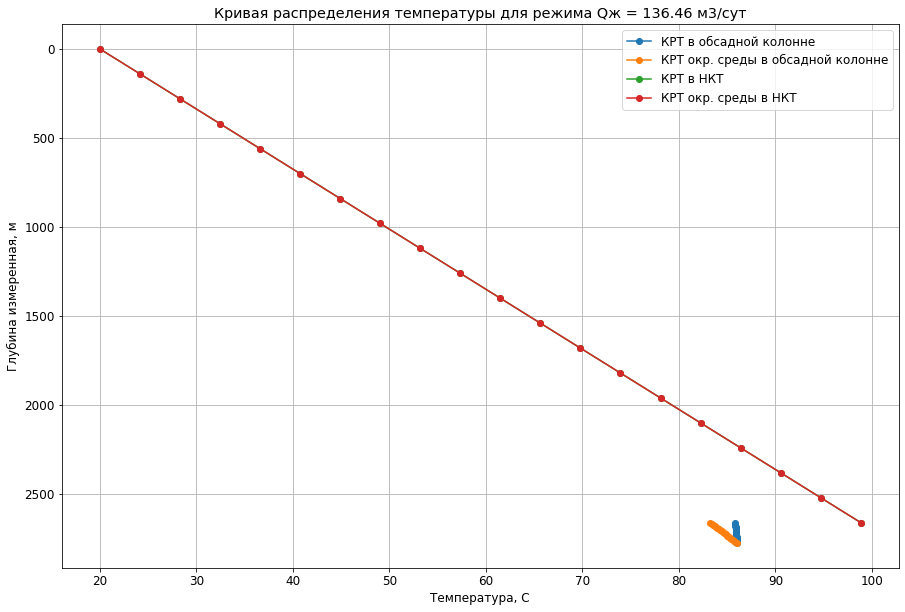

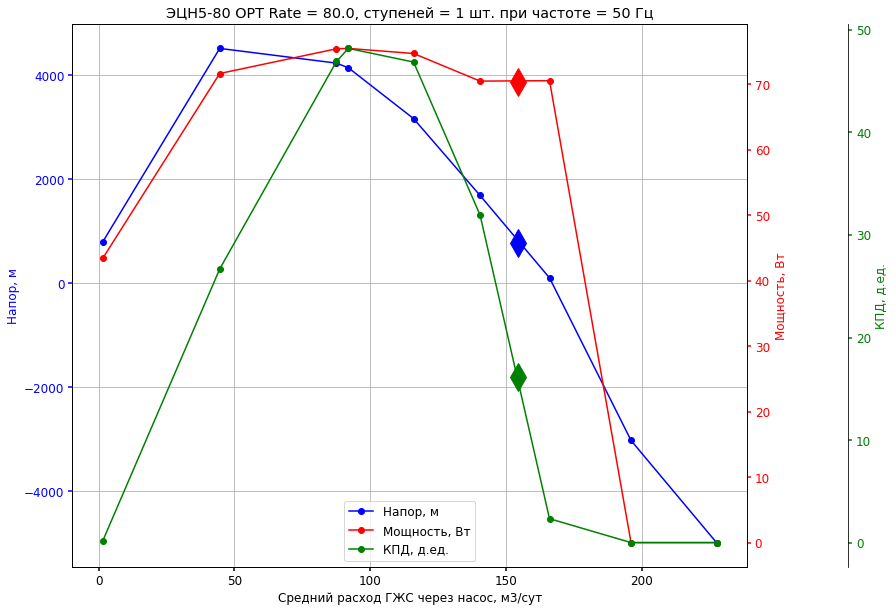

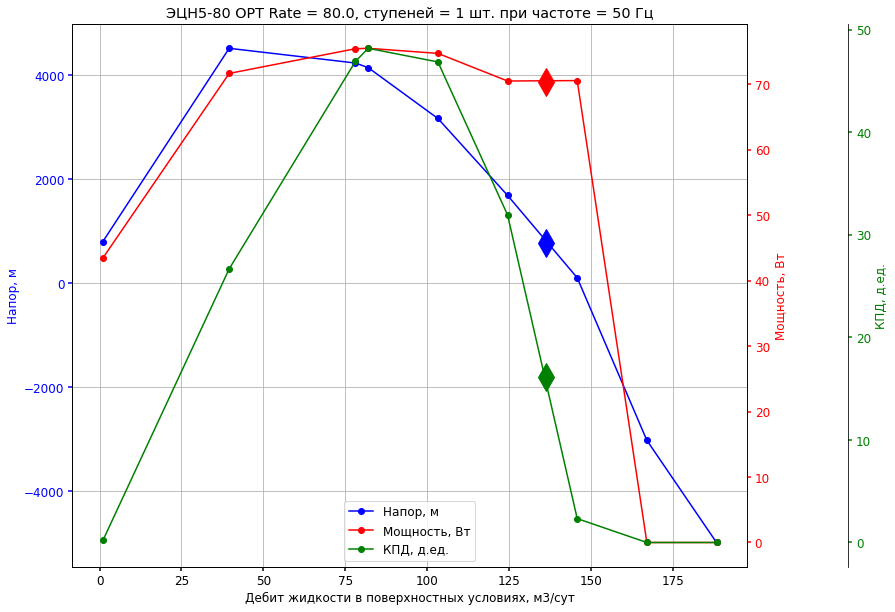

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:45<00:00,  5.03s/it]

norm calculation sucessful
('head_esp', 776.8725518400868, 'eff', 16.120261231479134, 'power_esp', 70.3779373846089, 'q_liq', 136.45617442329956, 'gas_fraction_intake', 0.0, 'p_bhp_atm', 140.94614675058637, 'p_dis', 196.41212688535373, 'p_esp_dis', 194.26950783763235, 'q_mix_pump_mean', 154.56917085909467)


In [29]:
res_list2 = []
sens_params['n_dots_for_nodal']  = 10
sens_params['pump_id'] = 1185 #100 проблемная
sens_params['esp_head_m'] = 2900
sensed_param = np.arange(0.5, 3, 0.3)
stack_values = []
for i in tqdm.tqdm(sensed_param):
    print('\n')
    print('i', i)
    sens_params['pi_sm3dayatm'] = i
    res = calc_all(sens_params, debug=1, vba_version='7.28', api=api, api_new=api_new)
    casing_pipe, tube_pipe, h_mes, head_esp, eff, power_esp, q_liq, status, gas_fraction_intake,\
    p_bhp_atm, p_dis, p_esp_dis, json_params, q_mix_pump_mean, esp_df = res
    res_list2.append(res)
    this_values = ('head_esp',  head_esp, 'eff', eff, 'power_esp', power_esp, 'q_liq', q_liq,  'gas_fraction_intake', gas_fraction_intake,
        'p_bhp_atm', p_bhp_atm, 'p_dis', p_dis, 'p_esp_dis',  p_esp_dis, 'q_mix_pump_mean', q_mix_pump_mean)
    
    stack_values.append(this_values)
    print(this_values)

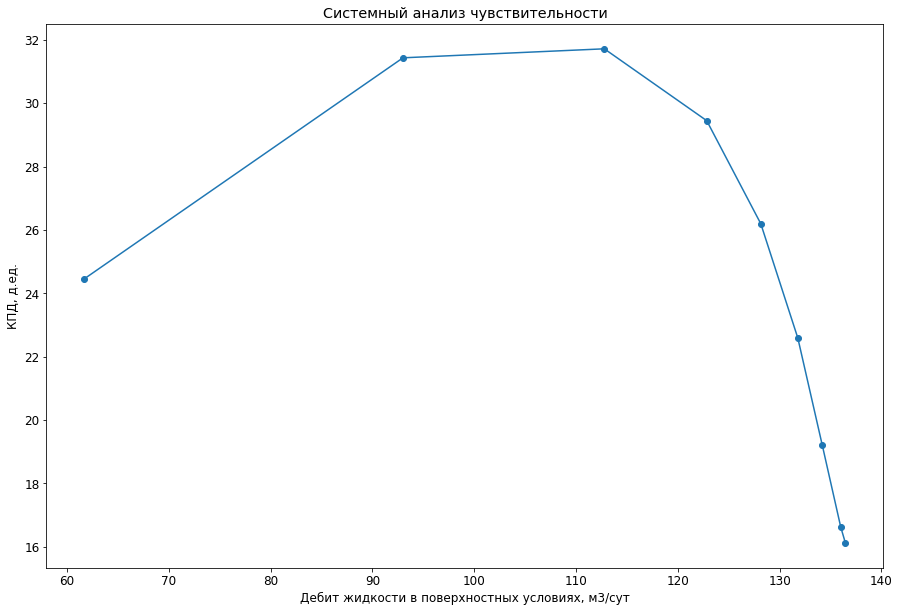

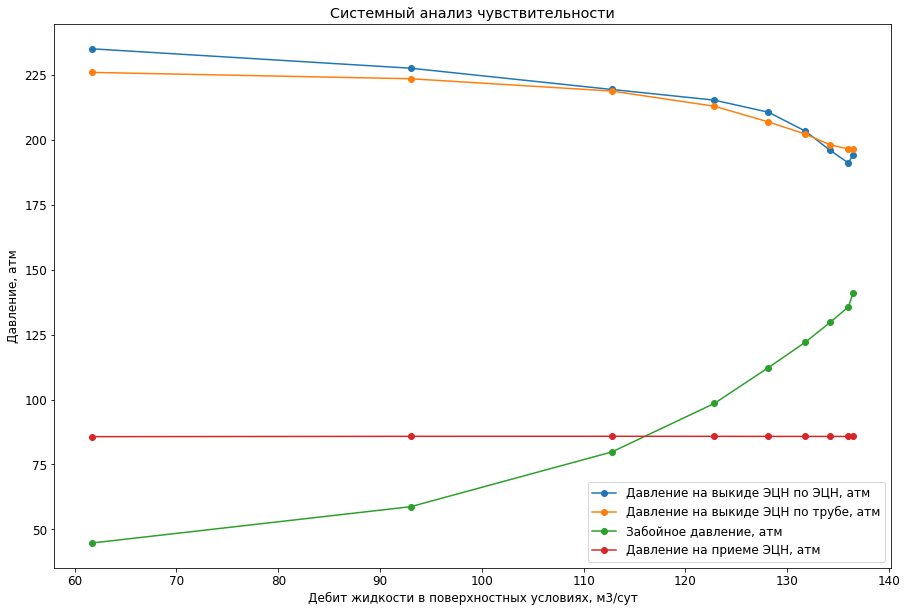

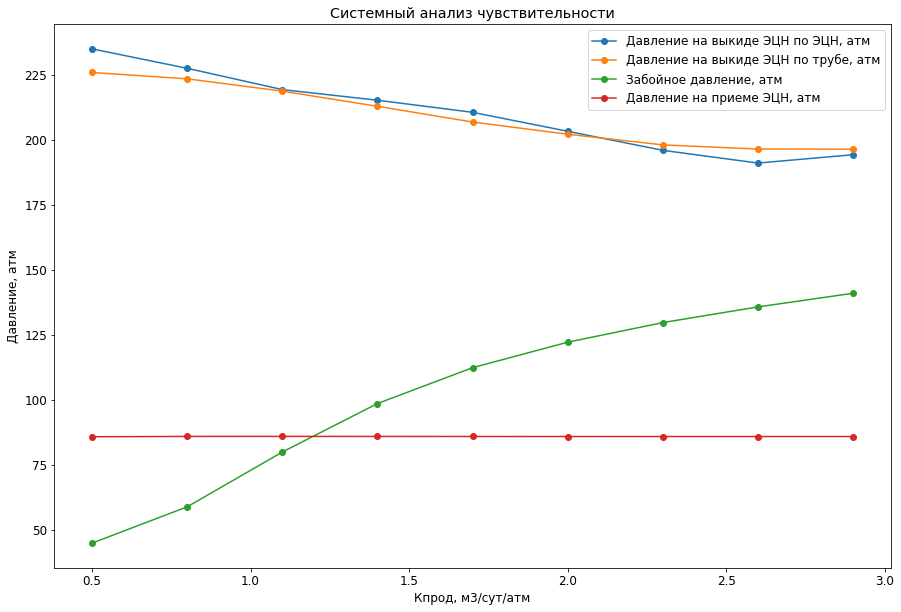

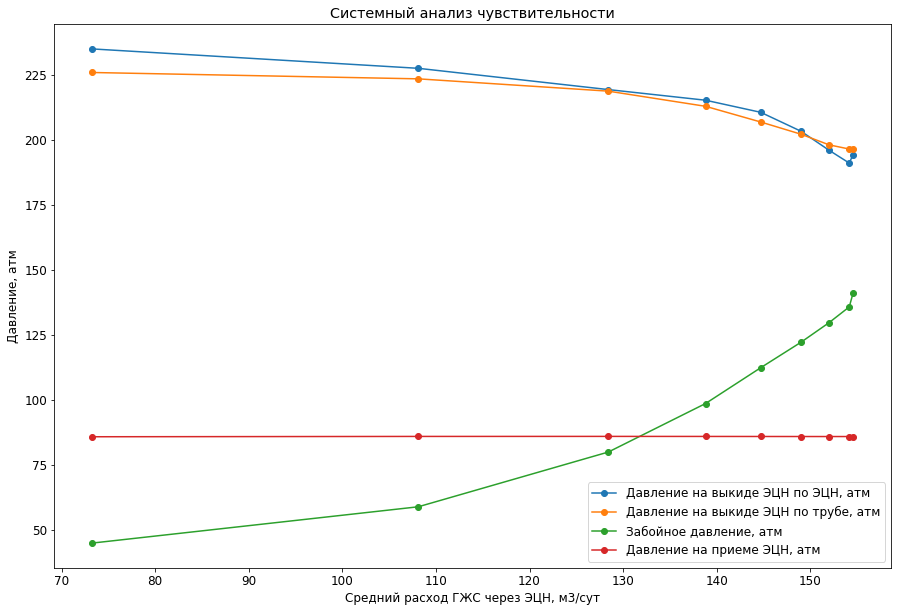

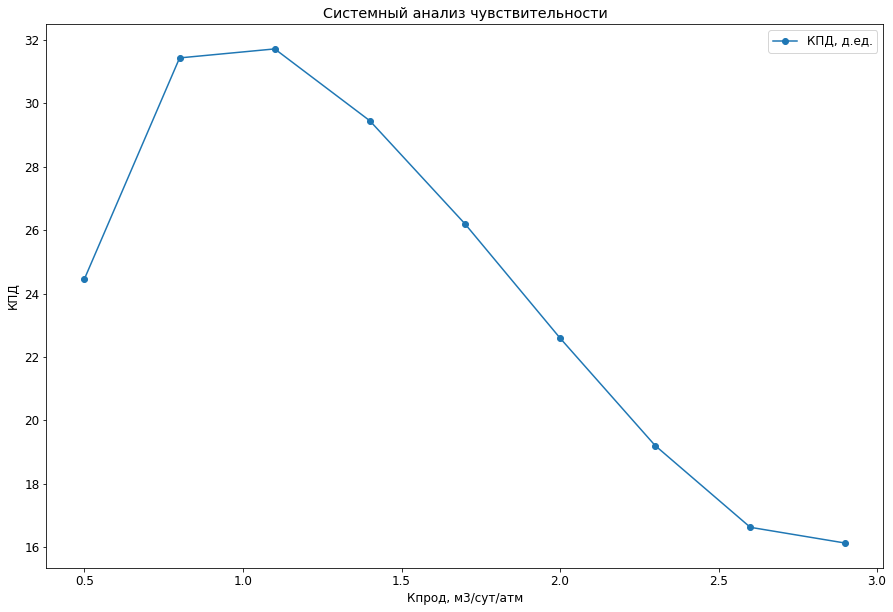

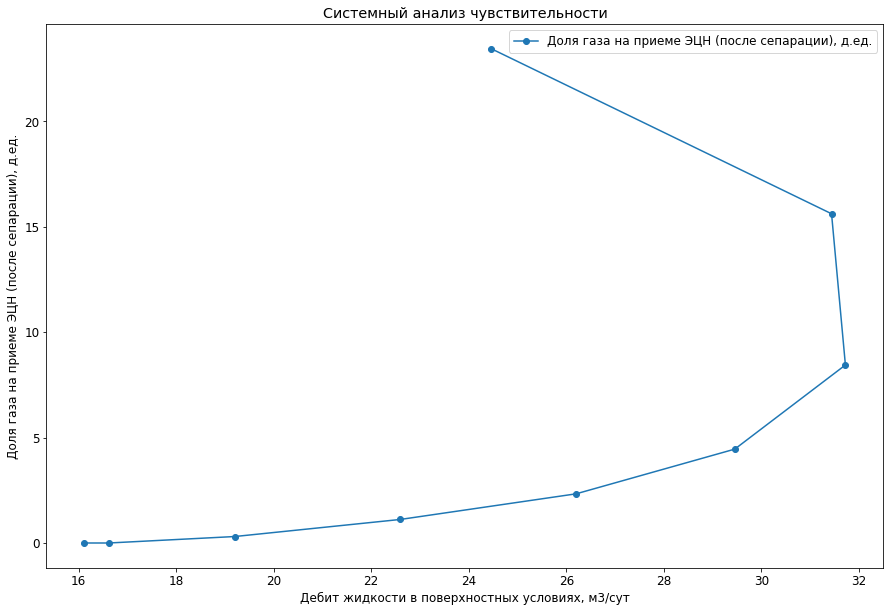

In [30]:
fig = plt.Figure()
plt.plot([x[6] for x in res_list2],
         [x[4] for x in res_list2], 'o-', label = 'КПД, д.ед.')
plt.xlabel('Дебит жидкости в поверхностных условиях, м3/сут')
plt.ylabel('КПД, д.ед.')
plt.title('Системный анализ чувствительности')
plt.show()


for i in [
    [ [x[6] for x in res_list2], 'Дебит жидкости в поверхностных условиях, м3/сут'],
    [sensed_param, 'Кпрод, м3/сут/атм'],
    [  [x[13] for x in res_list2], 'Средний расход ГЖС через ЭЦН, м3/сут']
    ]:
    sensed_x = i[0]
    sensed_x_name = i[1]
    
    
    fig = plt.Figure()
    plt.plot(sensed_x,
             [x[11] for x in res_list2], 'o-', label = 'Давление на выкиде ЭЦН по ЭЦН, атм')
    plt.plot(sensed_x,
             [x[10] for x in res_list2], 'o-', label = 'Давление на выкиде ЭЦН по трубе, атм')
    plt.plot(sensed_x,
             [x[9] for x in res_list2], 'o-', label = 'Забойное давление, атм')
    plt.plot(sensed_x,
             [x[14][3][3] for x in res_list2], 'o-', label = 'Давление на приеме ЭЦН, атм')
    
    plt.xlabel(sensed_x_name)
    plt.ylabel('Давление, атм')
    plt.title('Системный анализ чувствительности')
    plt.legend()
    plt.show()


plt.plot(sensed_param,
         [x[4] for x in res_list2], 'o-', label = 'КПД, д.ед.')
plt.xlabel('Кпрод, м3/сут/атм')
plt.ylabel('КПД')
plt.title('Системный анализ чувствительности')
plt.legend()
plt.show()



plt.plot( [x[4] for x in res_list2],
         [x[8] for x in res_list2], 'o-', label = 'Доля газа на приеме ЭЦН (после сепарации), д.ед.')
plt.xlabel('Дебит жидкости в поверхностных условиях, м3/сут')
plt.ylabel('Доля газа на приеме ЭЦН (после сепарации), д.ед.')
plt.title('Системный анализ чувствительности')
plt.legend()
plt.show()

### Насосы

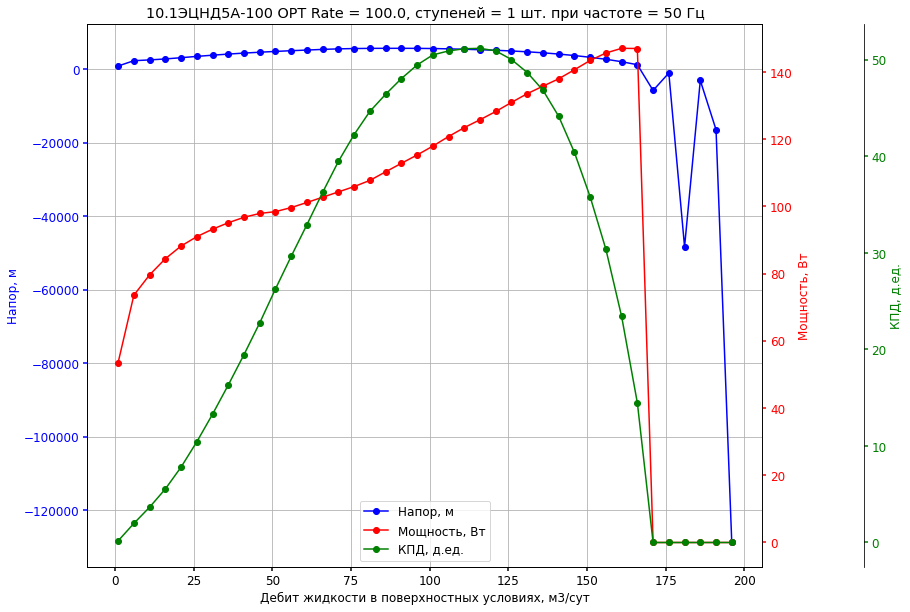

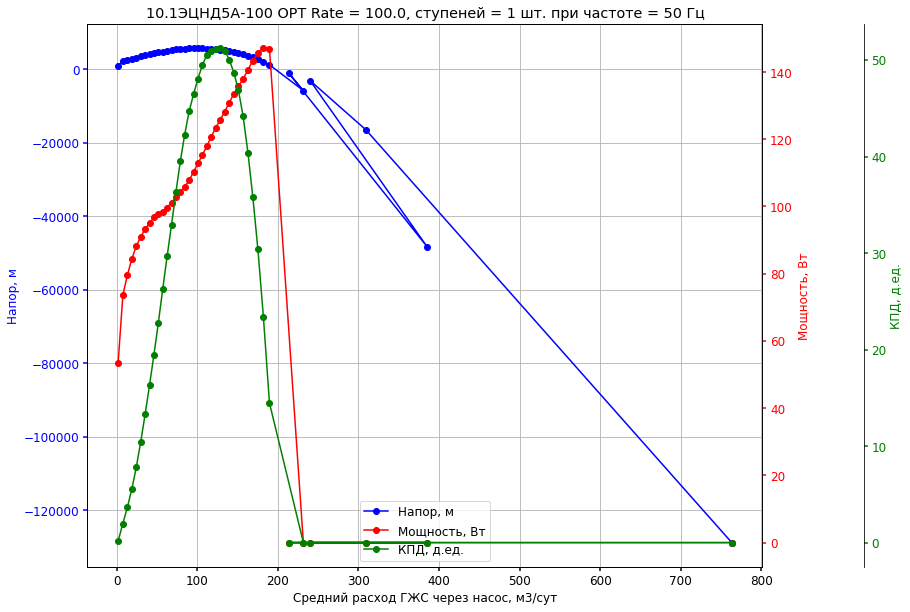

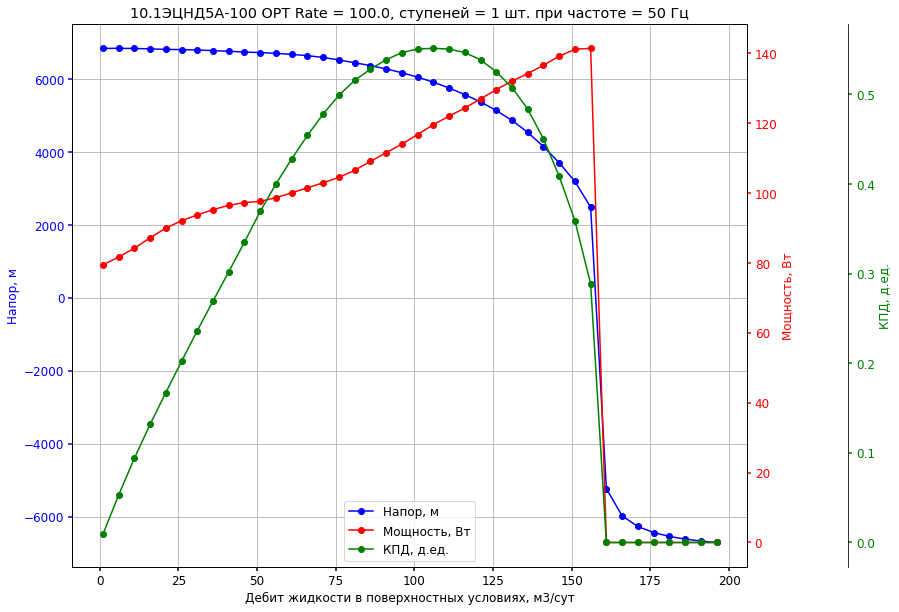

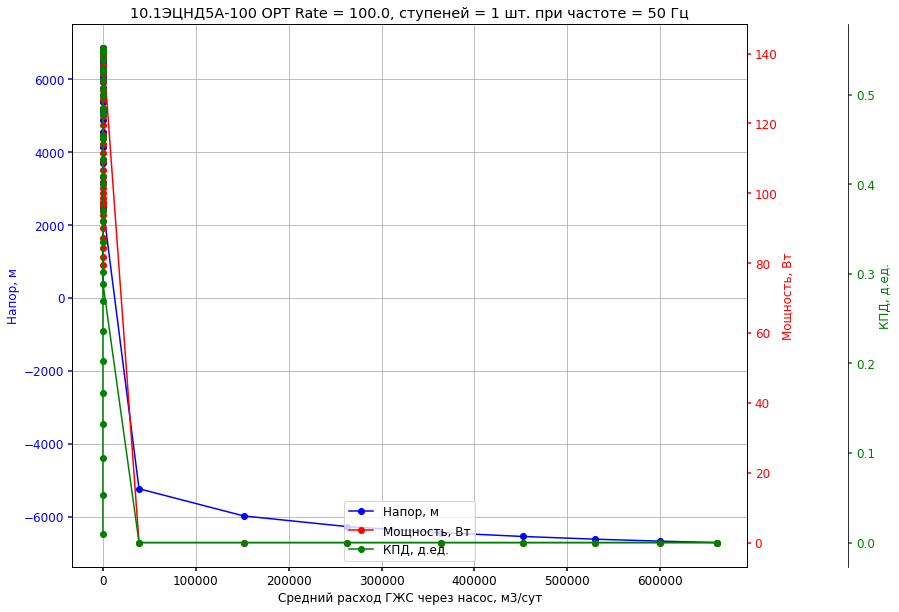

In [31]:
sens_params = params.copy()
sens_params['qliq_sm3day_range'] = np.arange(1, 200, 5)
for i in [2753, #страння характеристика эцн-100 - из-за округлений
          #1460, #125
           # 936, #83
          #1153, #80
         ]:

    sens_params['pump_id'] = i
    plot_pump_curves(sens_params, None, None, None, 80, 80, api.PVT_encode_string(ksep_fr=0.7, 
                                                                                  p_ksep_atma=80,
                                                                                 t_ksep_C=80), None, qliq_on_surface=True,
                                                                                    vba_version='7.28', api=api,
                                                                                    api_new=api_new)
    plot_pump_curves(sens_params, None, None, None, 80, 80, api.PVT_encode_string(ksep_fr=0.7, 
                                                                                  p_ksep_atma=80,
                                                                                 t_ksep_C=80), None, qliq_on_surface=False,
                                                                                    vba_version='7.28', api=api,
                                                                                    api_new=api_new)
    plot_pump_curves(sens_params, None, None, None, 80, 80, api.PVT_encode_string(ksep_fr=0.7, 
                                                                                  p_ksep_atma=80,
                                                                                 t_ksep_C=80), None, qliq_on_surface=True,
                                                                                    vba_version='7.25', api=api,
                                                                                    api_new=api_new)
    plot_pump_curves(sens_params, None, None, None, 80, 80, api.PVT_encode_string(ksep_fr=0.7, 
                                                                                  p_ksep_atma=80,
                                                                                 t_ksep_C=80), None, qliq_on_surface=False,
                                                                                    vba_version='7.25', api=api,
                                                                                    api_new=api_new) 
    
    

# Расчет

## Определение неопределенности работы пласта

In [32]:
params = mult.params
params

{'gamma_gas': 0.7,
 'gamma_oil': 0.844,
 'gamma_wat': 1.014,
 'rsb_m3m3': 85.54,
 'rp_m3m3': 85.54,
 'pb_atma': 123,
 't_res_C': 86,
 'bob_m3m3': 1.166,
 'muob_cP': 1.01,
 'PVTcorr': 0,
 'ksep_fr': 0.8,
 'p_bhp_atm': 100,
 'p_wh_atm': 15,
 't_wh_c': 20,
 'h_list_m': 2776,
 'h_pump_m': 2661,
 'diam_list_mm_casing': 159,
 'diam_list_mm_tube': 67.8,
 'gas_fraction_intake_d': 0.2,
 'qliq_sm3day': 80,
 'n_dots_for_nodal': 50,
 'qliq_sm3day_range': 80,
 'fw_perc': 22,
 'hydr_corr': 1,
 'temp_method': 2,
 'freq_Hz': 60,
 'pump_id': 1185,
 'num_stages': 200,
 'pi_sm3dayatm': 0.9,
 'pres_atma': 188,
 'calc_esp_new': 1,
 'esp_head_m': 2750,
 'ESP_gas_correct': 5}

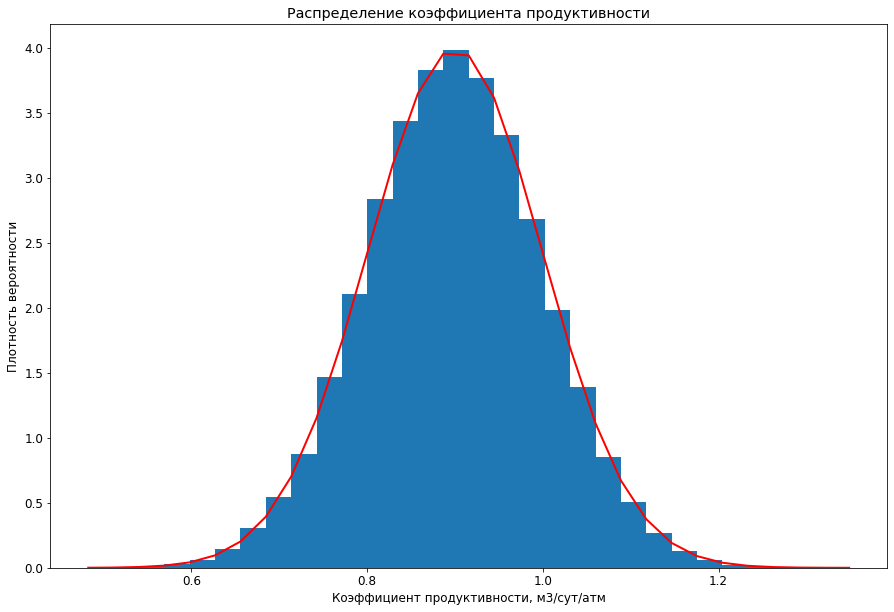

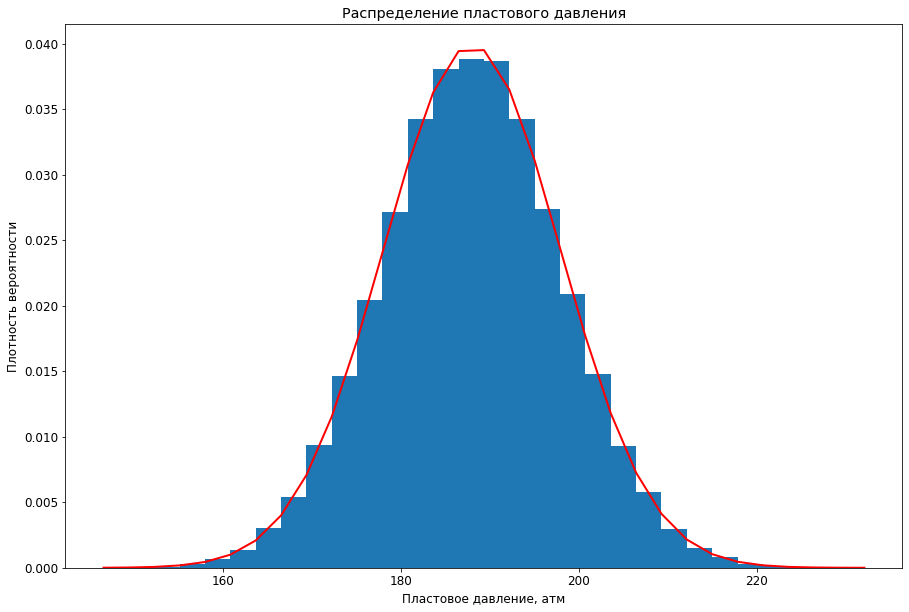

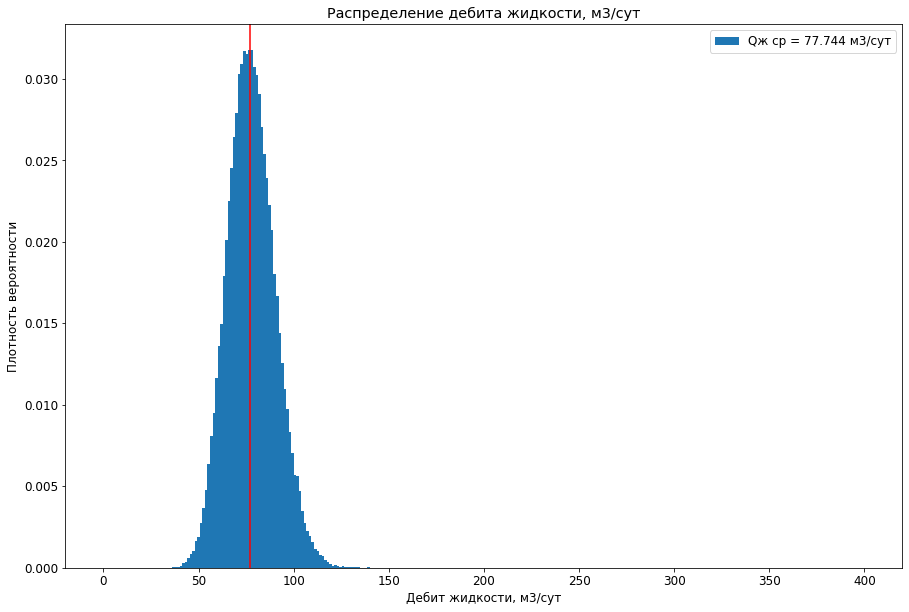

In [33]:

debug=1

create_q_dist = well_model.create_q_dist

all_stats_q_new, pi_mc, dist_p_res = create_q_dist(params, pi_mean = params['pi_sm3dayatm'], pi_std = 0.10, 
                  pres_std = 10,
                  num_simulations= 1_00_000, debug=debug)

#### Сохранение распределений

In [34]:
distr_json = {'all_stats_q_new': list(all_stats_q_new), 
             'pi_mc': list(pi_mc),
              'dist_p_res': list(dist_p_res)
             }

In [35]:
with open('distr.txt', 'w') as json_file:
    json.dump(distr_json, json_file)

#### Загрузка распределений


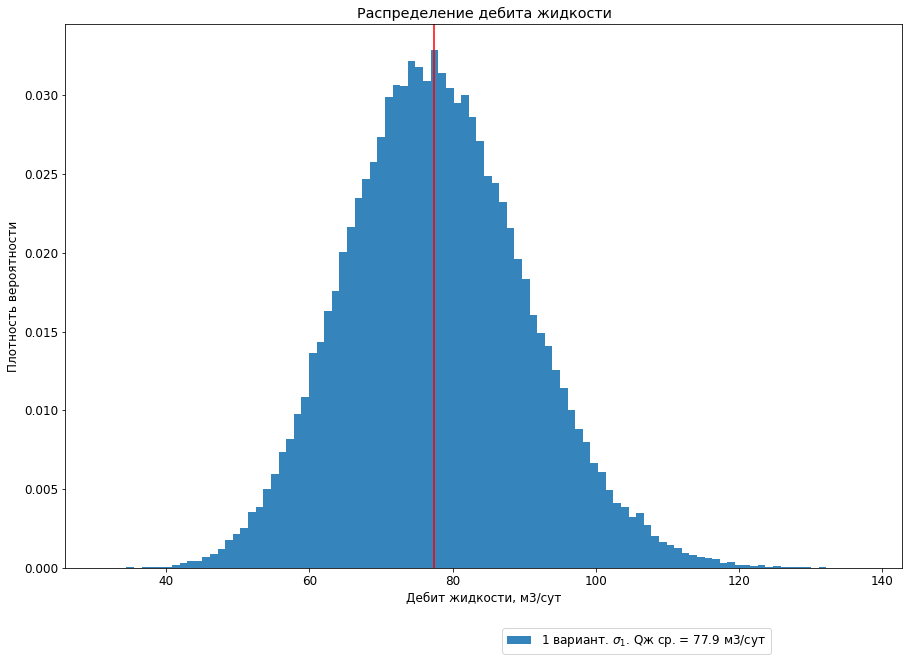

In [36]:
with open('distr_wide.txt') as json_file:
    data = json.load(json_file)
all_stats_q_new, pi_mc, dist_p_res = data['all_stats_q_new'], data['pi_mc'], data['dist_p_res']
plt.hist(all_stats_q_new,density=True,  alpha=0.9, bins = 100, label = f"1 вариант. $\sigma_1$. Qж ср. = {round(np.mean(all_stats_q_new), 1)} м3/сут")


#with open('distr_narrow.txt') as json_file:
#    data = json.load(json_file)
#all_stats_q_new, pi_mc, dist_p_res = data['all_stats_q_new'], data['pi_mc'], data['dist_p_res']
#plt.hist(all_stats_q_new,density=True, alpha=0.8, bins = 100, label = f"2 вариант. $\sigma_2 = \sigma_1/4$. Qж ср. = {round(np.mean(all_stats_q_new), 3)} м3/сут")


plt.axvline(x=np.quantile(all_stats_q_new, q=0.5), c = 'r')

plt.xlabel('Дебит жидкости, м3/сут')
plt.ylabel('Плотность вероятности')
plt.title('Распределение дебита жидкости')

plt.legend(loc='best', bbox_to_anchor=(0.85, -0.1))
plt.show()

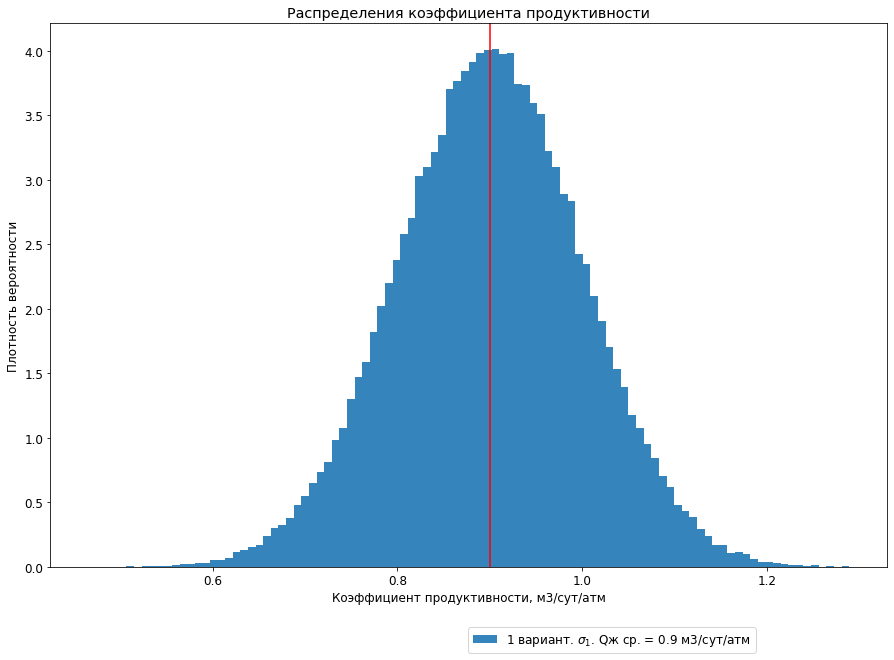

In [37]:
with open('distr_wide.txt') as json_file:
    data = json.load(json_file)
all_stats_q_new, pi_mc, dist_p_res = data['all_stats_q_new'], data['pi_mc'], data['dist_p_res']
plt.hist(pi_mc,density=True,  alpha=0.9, bins = 100, label = f"1 вариант. $\sigma_1$. Qж ср. = {round(np.mean(pi_mc), 1)} м3/сут/атм")


#with open('distr_narrow.txt') as json_file:
#    data = json.load(json_file)
#all_stats_q_new, pi_mc, dist_p_res = data['all_stats_q_new'], data['pi_mc'], data['dist_p_res']
#plt.hist(all_stats_q_new,density=True, alpha=0.8, bins = 100, label = f"2 вариант. $\sigma_2 = \sigma_1/4$. Qж ср. = {round(np.mean(all_stats_q_new), 3)} м3/сут")


plt.axvline(x=np.quantile(pi_mc, q=0.5), c = 'r')

plt.xlabel('Коэффициент продуктивности, м3/сут/атм')
plt.ylabel('Плотность вероятности')
plt.title('Распределения коэффициента продуктивности')

plt.legend(loc='best', bbox_to_anchor=(0.85, -0.1))
plt.show()

In [38]:
np.std(pi_mc), np.mean(pi_mc), np.std(dist_p_res), np.mean(dist_p_res), np.std(all_stats_q_new), np.mean(all_stats_q_new)

(0.09993024828820991,
 0.9000593728988008,
 10.027033516877772,
 188.00502818610653,
 12.537826845574292,
 77.87277946279671)

### Сравнение распределений

In [39]:
samples = []
for i in tqdm.tqdm(range(1000)):
    val = np.random.choice(all_stats_q_new, replace=True)
    samples.append(val)
    
samples =     np.array(samples)
print('end')

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.82it/s]

end


In [40]:
samples2 = []
for i in tqdm.tqdm(range(1000)):
    val = np.random.choice(all_stats_q_new, replace=True)
    samples2.append(val)
    
samples2 =     np.array(samples2)
print('end')

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.26it/s]

end


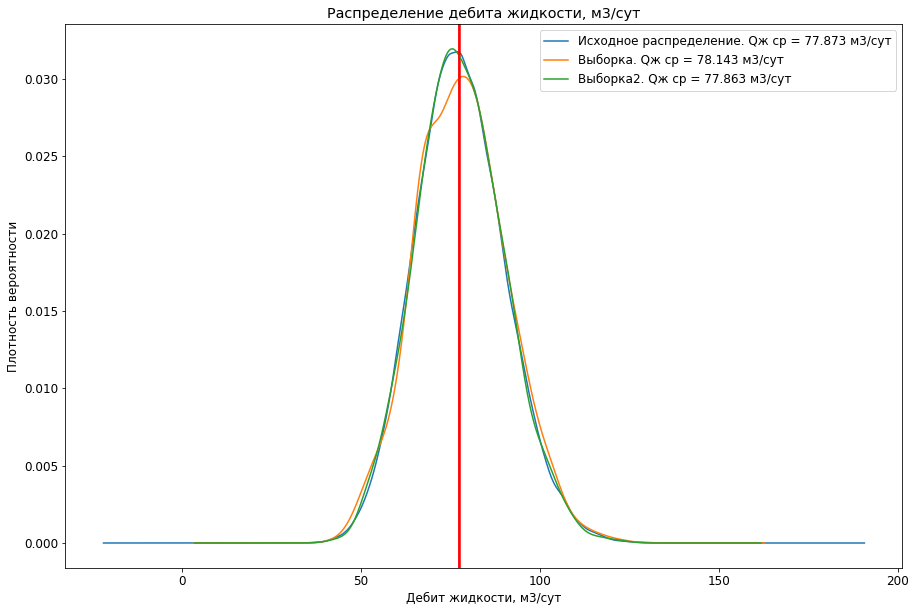

In [41]:
fig, ax = plt.subplots()

ax = pd.Series(all_stats_q_new).plot.kde(label = 'Исходное распределение. ' + f"Qж ср = {round(np.mean(all_stats_q_new), 3)} м3/сут")

#count, bins, ignored = plt.hist(all_stats_q_new, 300, [0, 400], density=True, 
#                                label=f"Qж ср = {round(np.mean(all_stats_q_new), 3)} м3/сут")

plt.axvline(x=np.quantile(all_stats_q_new, q=0.5), c = 'r')

#count, bins, ignored = plt.hist(samples, 300, [0, 400], density=True, 
#                                label=f"Qж ср = {round(np.mean(samples), 3)} м3/сут")

ax = pd.Series(samples).plot.kde(label =  f"Выборка. Qж ср = {round(np.mean(samples), 3)} м3/сут")


plt.axvline(x=np.quantile(samples, q=0.5), c = 'r')

ax = pd.Series(samples2).plot.kde(label =  f"Выборка2. Qж ср = {round(np.mean(samples2), 3)} м3/сут")


plt.axvline(x=np.quantile(samples2, q=0.5), c = 'r')


plt.title('Распределение дебита жидкости, м3/сут')
plt.xlabel('Дебит жидкости, м3/сут')
plt.ylabel('Плотность вероятности')
ax.legend()
plt.show()


#### Построение распределения 

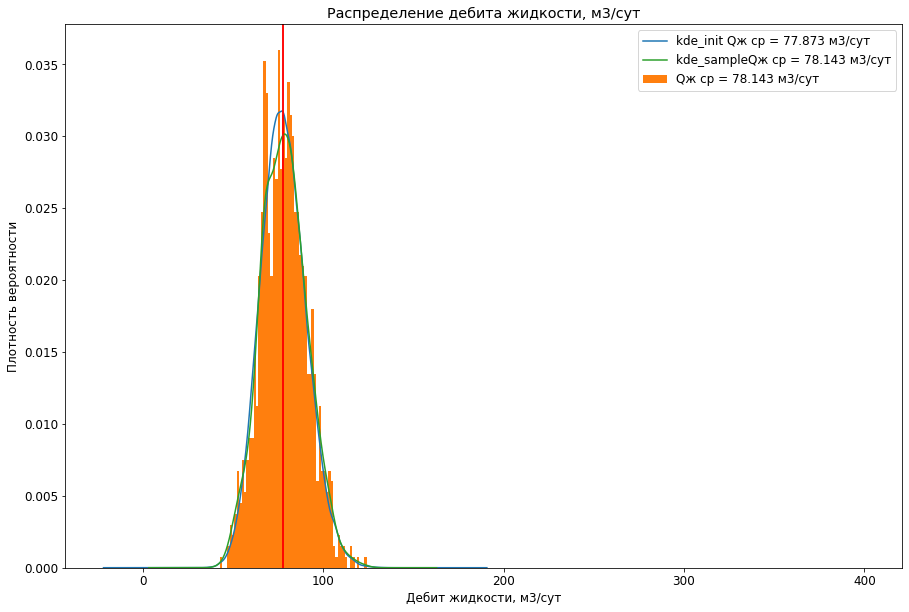

In [42]:
fig, ax = plt.subplots()

ax = pd.Series(all_stats_q_new).plot.kde(label = 'kde_init' + f" Qж ср = {round(np.mean(all_stats_q_new), 3)} м3/сут")

#count, bins, ignored = plt.hist(all_stats_q_new, 300, [0, 400], density=True, 
#                                label=f"Qж ср = {round(np.mean(all_stats_q_new), 3)} м3/сут")

plt.axvline(x=np.quantile(all_stats_q_new, q=0.5), c = 'r')

count, bins, ignored = plt.hist(samples, 300, [0, 400], density=True, 
                                label=f"Qж ср = {round(np.mean(samples), 3)} м3/сут")

ax = pd.Series(samples).plot.kde(label = 'kde_sample' + f"Qж ср = {round(np.mean(samples), 3)} м3/сут")


plt.axvline(x=np.quantile(samples, q=0.5), c = 'r')


plt.title('Распределение дебита жидкости, м3/сут')
plt.xlabel('Дебит жидкости, м3/сут')
plt.ylabel('Плотность вероятности')
ax.legend()
plt.show()


### Поиск подходящих насосов

In [43]:
with open('ESP_json.db', 'r') as outfile:
    file = outfile
    db = json.load(outfile)

db_df = pd.DataFrame(db)
db_df = db_df.T  

number_of_point_in_curves = []
for i in db_df.index:
    this_pump = db_df.loc[i]
    number_of_point_in_curves.append(len(this_pump['rate_points']))
    
db_df['number_of_point_in_curves'] = number_of_point_in_curves



In [44]:
q_median = np.quantile(all_stats_q_new, q=0.5)
q_std = np.std(all_stats_q_new)
q_p10 = np.quantile(all_stats_q_new, q=0.10)
q_p90 = np.quantile(all_stats_q_new, q=0.90)
q_std

12.537826845574292

In [45]:
db_df_for_this_uncertainty = db_df[db_df['number_of_point_in_curves']>15]
db_df_for_this_uncertainty = db_df_for_this_uncertainty[db_df_for_this_uncertainty['rate_opt_min_sm3day']>q_p10-q_std]
db_df_for_this_uncertainty = db_df_for_this_uncertainty[db_df_for_this_uncertainty['rate_opt_max_sm3day']<q_p90+3*q_std]

db_df_for_this_uncertainty

ID  source manufacturer                 name stages_max  \
2753  2753  legacy        Лемаз       10.1ЭЦНД5А-100        436   
226    226  legacy   Centrilift                338G5         34   
1093  1093  legacy  Weatherford                  420        232   
649    649  legacy          ODI                  R-7        483   
1162  1162  legacy        Алмаз  0П0ЭЦНДН5-80-эталон        600   
684    684  legacy         Reda                AN550        604   
1258  1258  legacy        Алнас    0215ЭЦНАКИ5А-125И        459   
685    685  legacy         Reda                AN550        604   
1105  1105  legacy  Weatherford                  600        190   
1111  1111  legacy  Weatherford                  660        230   
412    412  legacy   Centrilift                FC650        305   

     rate_nom_sm3day rate_opt_min_sm3day rate_opt_max_sm3day rate_max_sm3day  \
2753             100                  75                 125          175.03   
226               66                  53                  93          143.94   
1093              72             50.8759             95.3924         111.032   
649               95             66.2447              119.24         160.551   
1162              80                  60                 105          129.15   
684          74.1667             52.9958             92.7426         118.444   
1258             125                  75                 125         234.684   
685               89             63.5949             111.291         142.133   
1105              95             63.5949             111.291         142.181   
1111             103             71.5443              127.19         185.574   
412          83.3333             59.6202             105.992         127.709   

     slip_nom_rpm  ... power_limit_shaft_kW power_limit_shaft_high_kW  \
2753         2910  ...                   72                       120   
226          2917  ...                   72                       120   
1093         3500  ...                   72                       120   
649          3500  ...                   72                       120   
1162         2910  ...                   72                       120   
684          3500  ...                   72                       120   
1258         2917  ...                   72                       120   
685          3500  ...                   72                       120   
1105         3500  ...                   72                       120   
1111         3500  ...                   72                       120   
412          3500  ...                   72                       120   

     power_limit_shaft_max_kW pressure_limit_housing_atma d_motor_od_mm  \
2753                      150                         390            95   
226                       150                         390            95   
1093                      150                         390            95   
649                       150                         390            95   
1162                      150                         390            95   
684                       150                         390            95   
1258                      150                         390            95   
685                       150                         390            95   
1105                      150                         390            95   
1111                      150                         390            95   
412                       150                         390            95   

                                            rate_points  \
2753  [0.0, 9.94, 19.87, 29.81, 40.51, 50.06, 60.38,...   
226   [0.0, 4.55, 9.7, 14.55, 19.7, 29.7, 39.7, 50.0...   
1093  [4.0, 7.0, 11.0, 15.0, 19.0, 22.0, 26.0, 30.0,...   
649   [5.0, 10.8333333333, 15.8333333333, 20.8333333...   
1162  [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 65.0...   
684   [4.1666666667, 8.3333333333, 11.6666666667, 15...   
1258  [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105

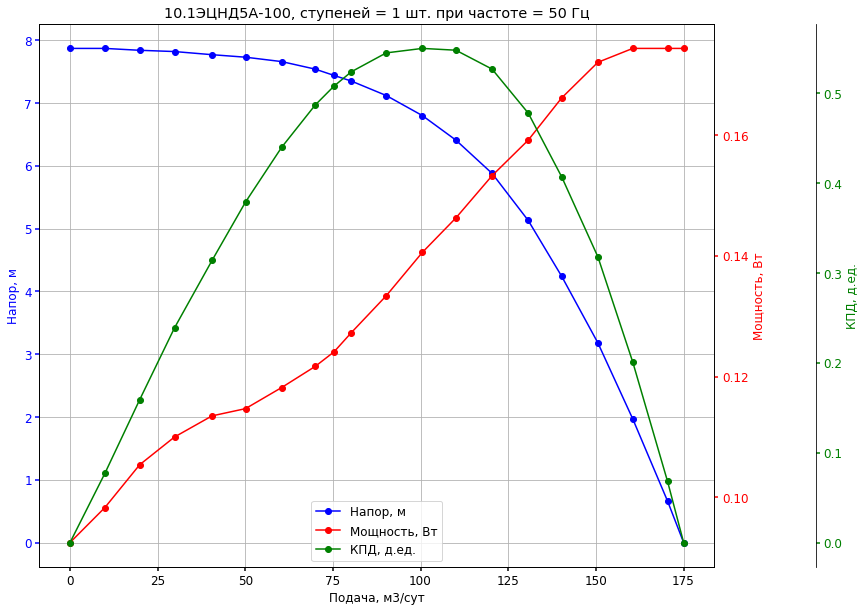

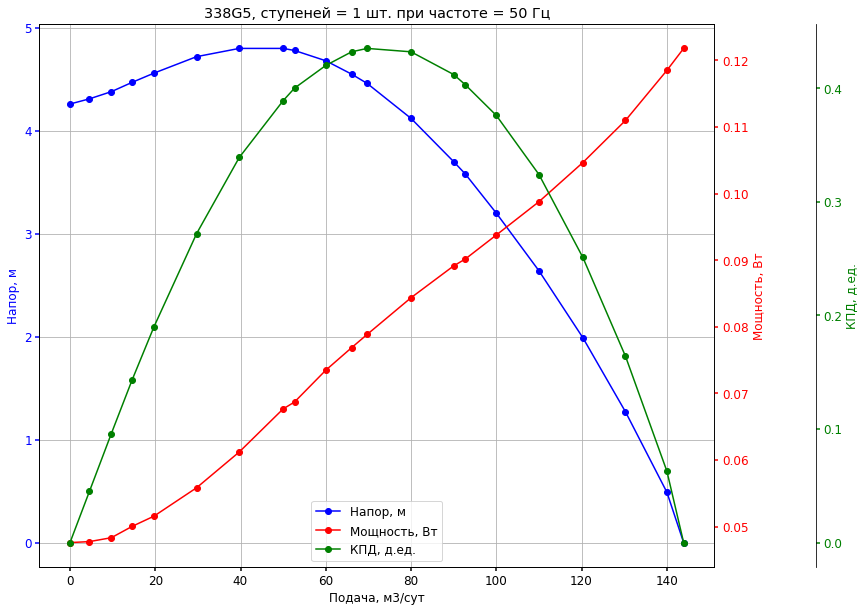

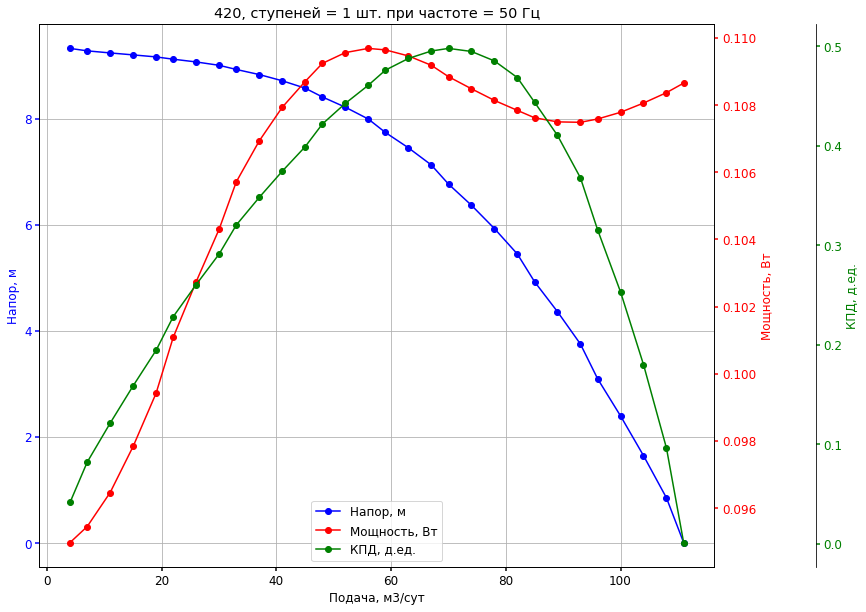

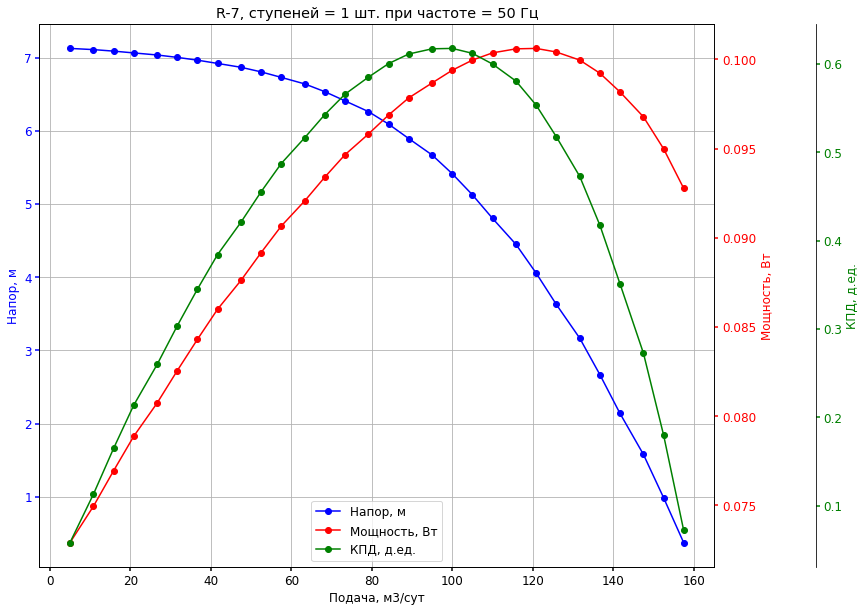

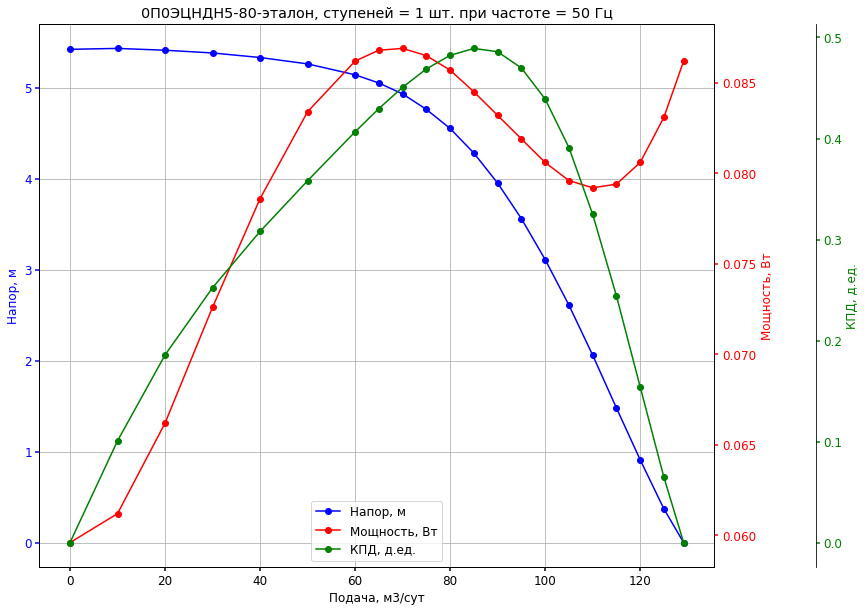

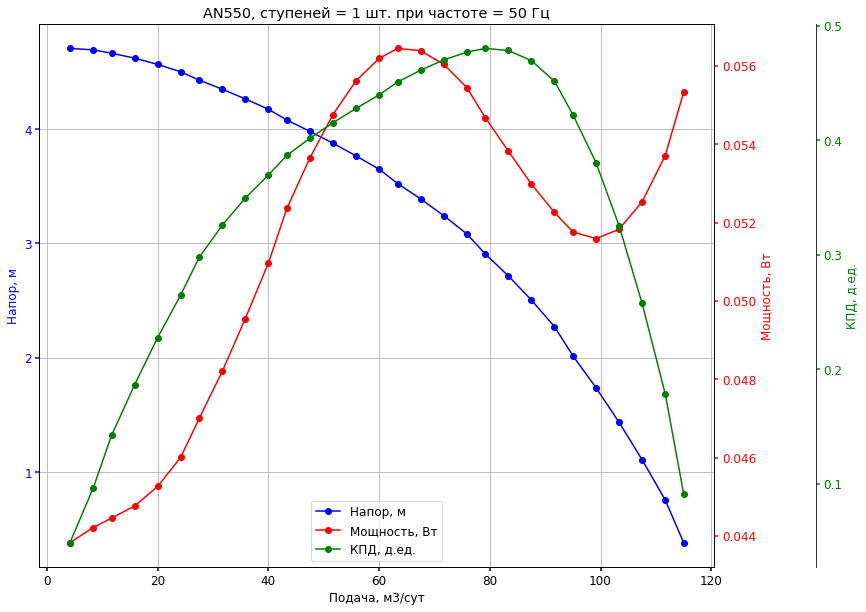

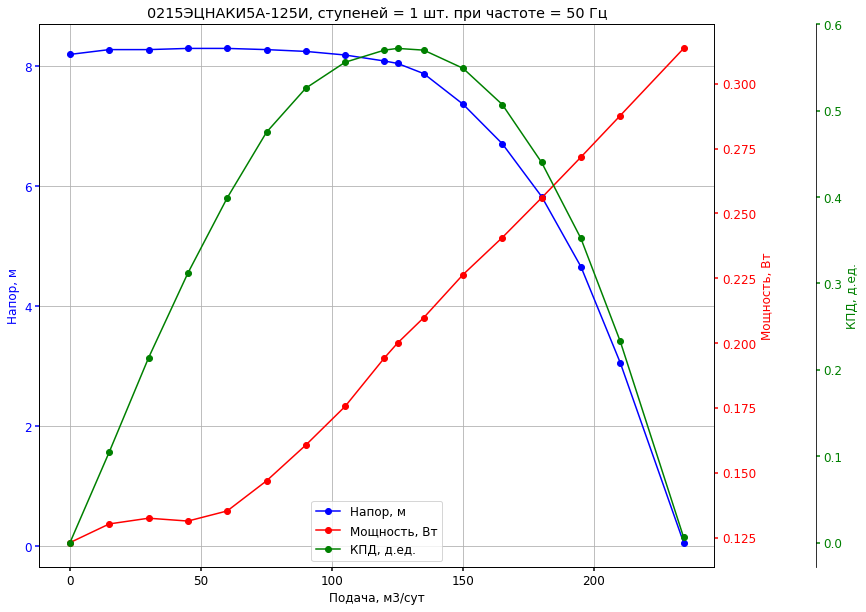

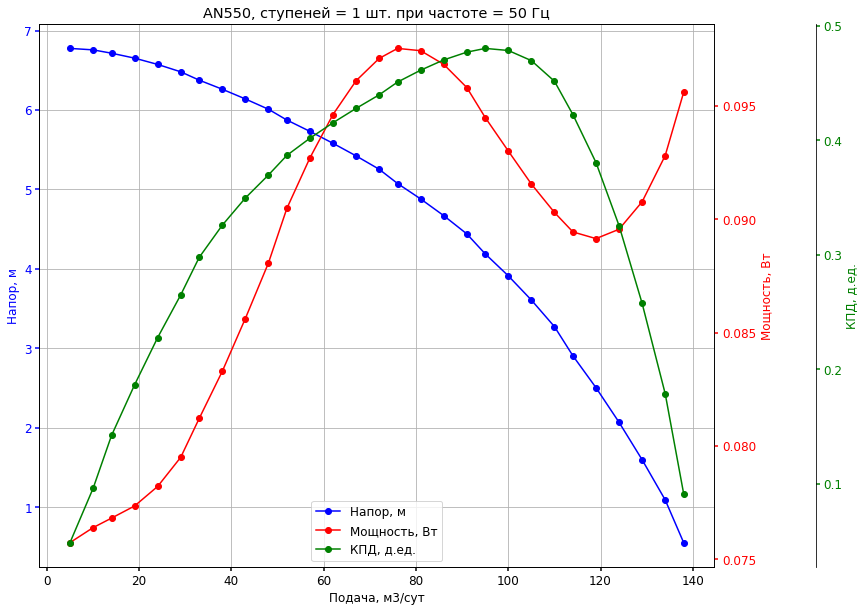

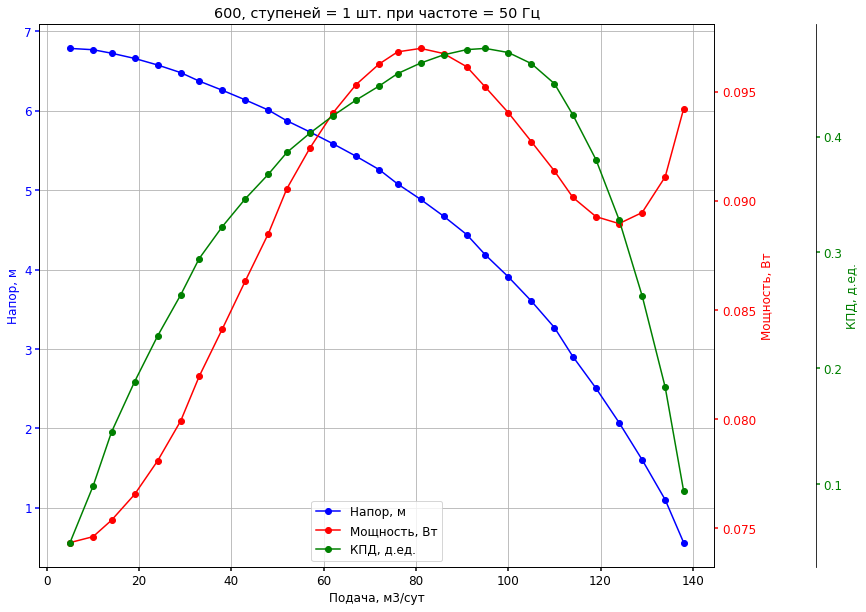

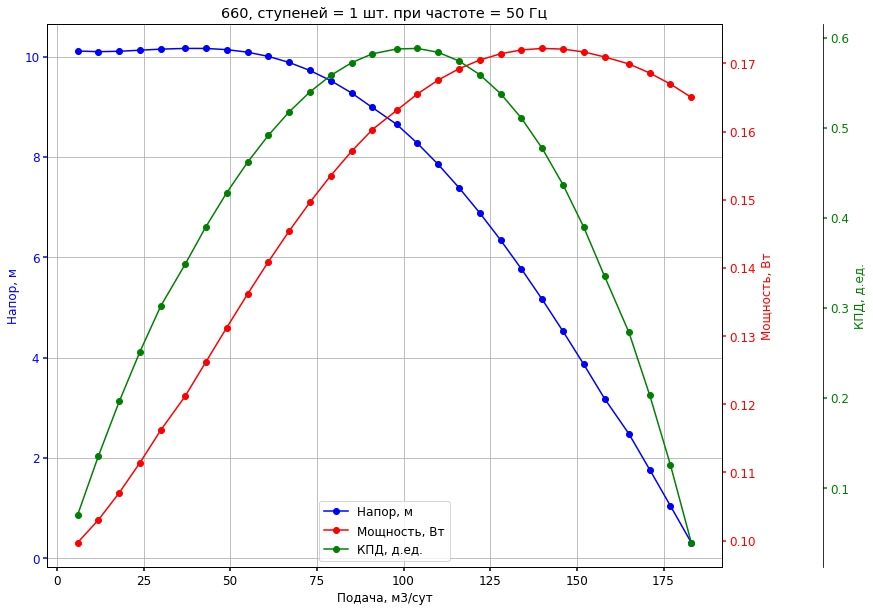

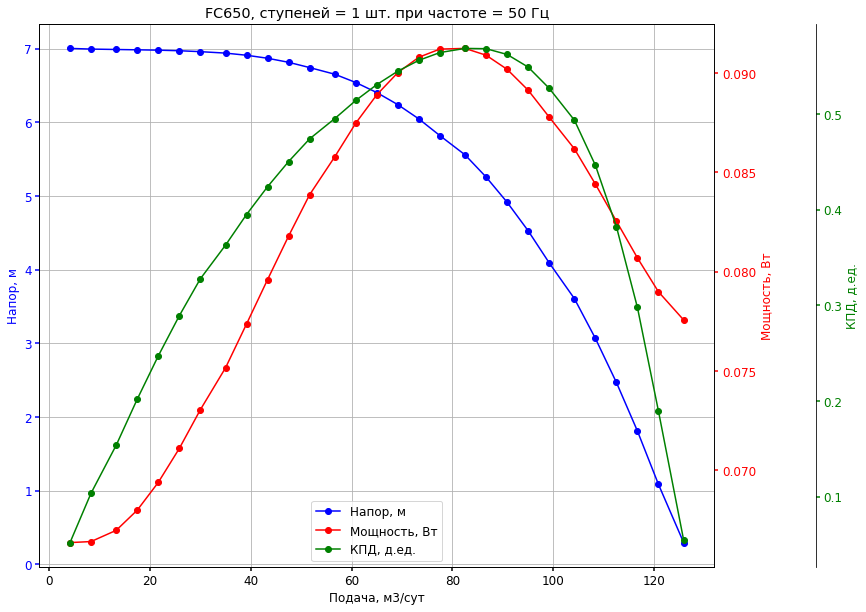

In [46]:
for i in range(db_df_for_this_uncertainty.shape[0]):
    this_pump = db_df_for_this_uncertainty.iloc[i]
    plot_pump_curve(q_arr = np.array(this_pump['rate_points']), 
        h_esp_arr = np.array(this_pump['head_points']),
        power_esp_arr = np.array(this_pump['power_points']), 
        efficiency_esp_arr = np.array(this_pump['eff_points']),
             z = 1,
                    esp_name = this_pump['name'], f=50)

Text(0.5, 1.0, 'Распределение выбранных ЭЦН по подаче для текущих условий работы пласта')

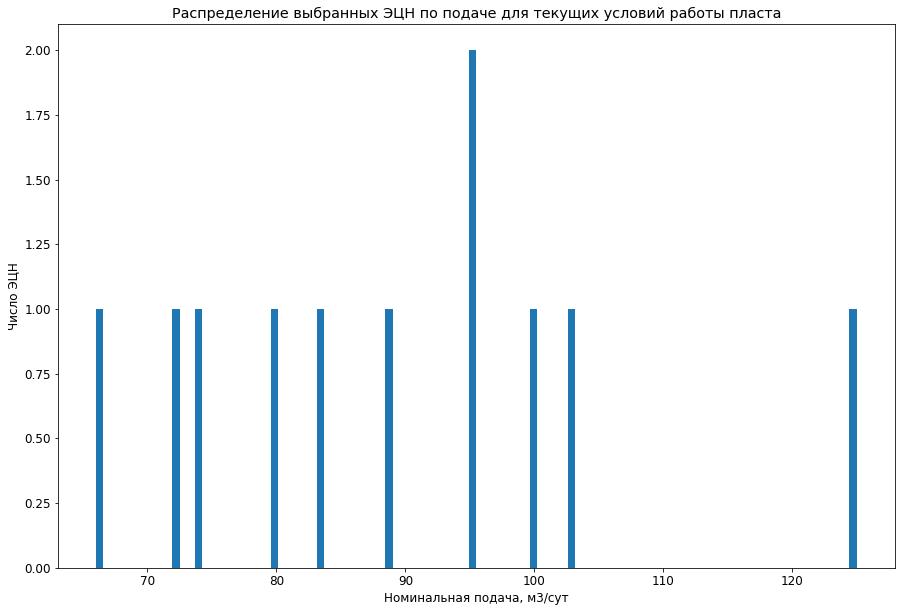

In [47]:
db_df_for_this_uncertainty['rate_nom_sm3day'].plot(kind = 'hist', bins = 100)
plt.xlabel('Номинальная подача, м3/сут')
plt.ylabel('Число ЭЦН')
plt.title('Распределение выбранных ЭЦН по подаче для текущих условий работы пласта')

In [48]:
rates_unique = db_df_for_this_uncertainty['rate_nom_sm3day'].unique()
dq_for_group = (max(rates_unique) - min(rates_unique)) /5
rates_unique

array([100.0, 66.0, 72.0, 95.0, 80.0, 74.1666666667, 125.0, 89.0, 103.0,
       83.3333333333], dtype=object)

In [49]:
chosen_pumps = []
for i in range(5):
    q_left = min(rates_unique) + dq_for_group*i
    q_right = min(rates_unique) + dq_for_group*(i+1)
    print(q_left, q_right)
    if i == 0:
        pumps_in_group = db_df_for_this_uncertainty[(db_df_for_this_uncertainty['rate_nom_sm3day'] <= q_right) &
                                                   (db_df_for_this_uncertainty['rate_nom_sm3day'] >= q_left)].copy()
    else:
        pumps_in_group = db_df_for_this_uncertainty[(db_df_for_this_uncertainty['rate_nom_sm3day'] <= q_right) &
                                           (db_df_for_this_uncertainty['rate_nom_sm3day'] > q_left)].copy()
    pumps_in_group.loc[:, 'max_eff'] = pumps_in_group['eff_points'].copy().apply(lambda x: max(x))
    pumps_in_group = pumps_in_group.head(3)
    this_pumps = pumps_in_group[pumps_in_group['max_eff'] > pumps_in_group['max_eff'].max()*0.5]
    #this_pumps = pumps_in_group
    chosen_pumps.append(this_pumps)
result_pumps = pd.concat(chosen_pumps)

66.0 77.8
77.8 89.6
89.6 101.4
101.4 113.2
113.2 125.0


In [50]:
result_pumps

ID  source manufacturer                 name stages_max  \
226    226  legacy   Centrilift                338G5         34   
1093  1093  legacy  Weatherford                  420        232   
684    684  legacy         Reda                AN550        604   
1162  1162  legacy        Алмаз  0П0ЭЦНДН5-80-эталон        600   
685    685  legacy         Reda                AN550        604   
412    412  legacy   Centrilift                FC650        305   
2753  2753  legacy        Лемаз       10.1ЭЦНД5А-100        436   
649    649  legacy          ODI                  R-7        483   
1105  1105  legacy  Weatherford                  600        190   
1111  1111  legacy  Weatherford                  660        230   
1258  1258  legacy        Алнас    0215ЭЦНАКИ5А-125И        459   

     rate_nom_sm3day rate_opt_min_sm3day rate_opt_max_sm3day rate_max_sm3day  \
226               66                  53                  93          143.94   
1093              72             50.8759             95.3924         111.032   
684          74.1667             52.9958             92.7426         118.444   
1162              80                  60                 105          129.15   
685               89             63.5949             111.291         142.133   
412          83.3333             59.6202             105.992         127.709   
2753             100                  75                 125          175.03   
649               95             66.2447              119.24         160.551   
1105              95             63.5949             111.291         142.181   
1111             103             71.5443              127.19         185.574   
1258             125                  75                 125         234.684   

     slip_nom_rpm  ... power_limit_shaft_high_kW power_limit_shaft_max_kW  \
226          2917  ...                       120                      150   
1093         3500  ...                       120                      150   
684          3500  ...                       120                      150   
1162         2910  ...                       120                      150   
685          3500  ...                       120                      150   
412          3500  ...                       120                      150   
2753         2910  ...                       120                      150   
649          3500  ...                       120                      150   
1105         3500  ...                       120                      150   
1111         3500  ...                       120                      150   
1258         2917  ...                       120                      150   

     pressure_limit_housing_atma d_motor_od_mm  \
226                          390            95   
1093                         390            95   
684                          390            95   
1162                         390            95   
685                          390            95   
412                          390            95   
2753                         390            95   
649                          390            95   
1105                         390            95   
1111                         390            95   
1258                         390            95   

                                            rate_points  \
226   [0.0, 4.55, 9.7, 14.55, 19.7, 29.7, 39.7, 50.0...   
1093  [4.0, 7.0, 11.0, 15.0, 19.0, 22.0, 26.0, 30.0,...   
684   [4.1666666667, 8.3333333333, 11.6666666667, 15...   
1162  [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 65.0...   
685   [5.0, 10.0, 14.0, 19.0, 24.0, 29.0, 33.0, 38.0...   
412   [4.1666666667, 8.3333333333, 13.3333333333, 17...   
2753  [0.0, 9.94, 19.87, 29.81, 40.51, 50.06, 60.38,...   
649   [5.0, 10.8333333333, 15.8333333333, 20.8333333...   
1105  [5.0, 10.0, 14.0, 19.0, 24.0, 29.0, 33.0, 38.0...   
1111  [6.0, 12.0, 18.0, 24.0, 30.0, 37.0, 43.0, 49.0...   
1258  [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105....   

       

66.0 226


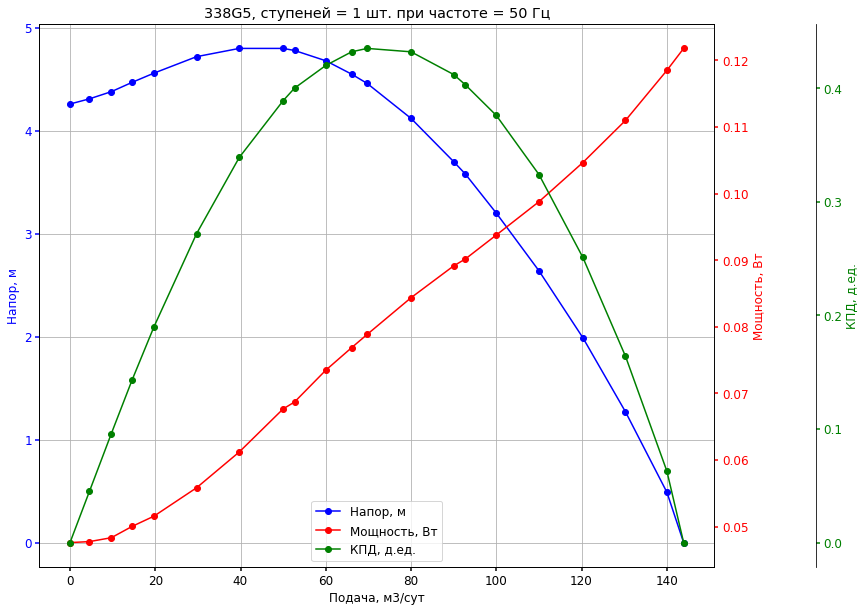

72.0 1093


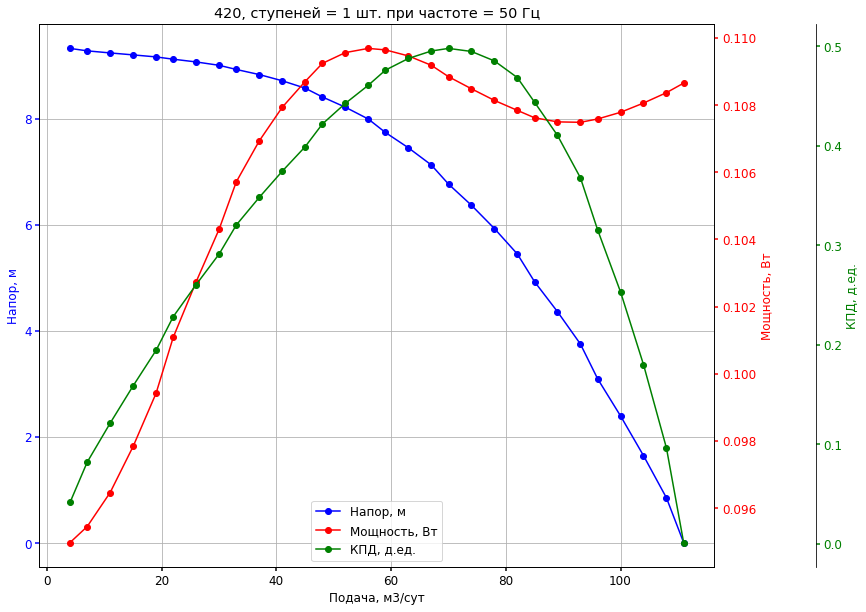

74.1666666667 684


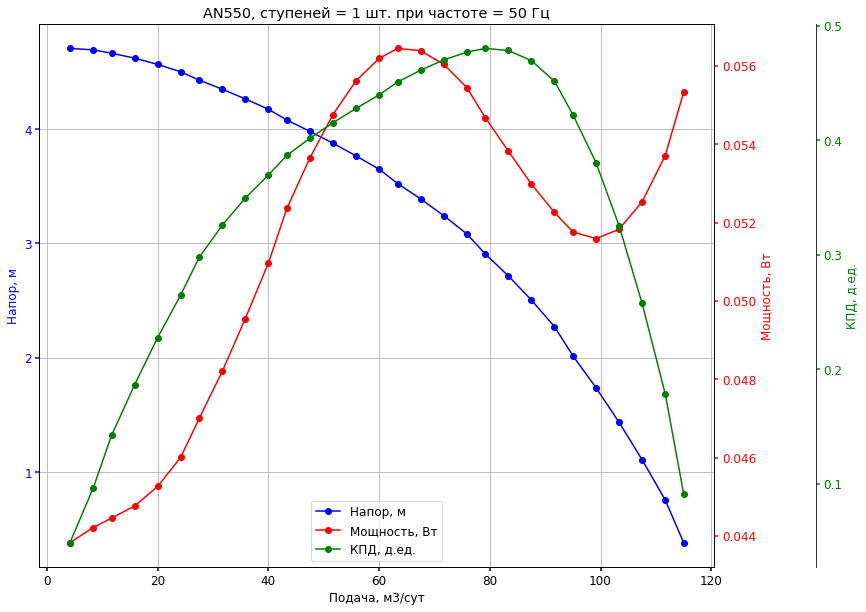

80.0 1162


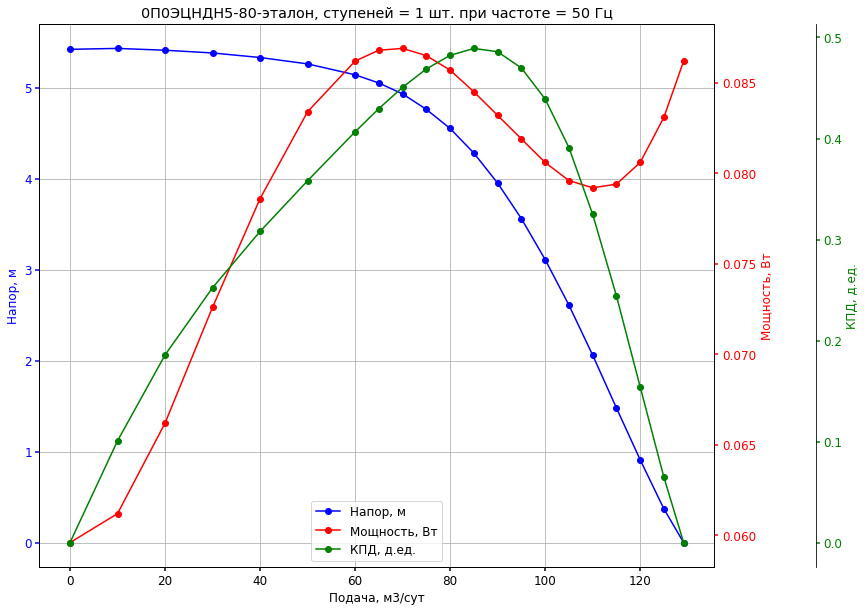

89.0 685


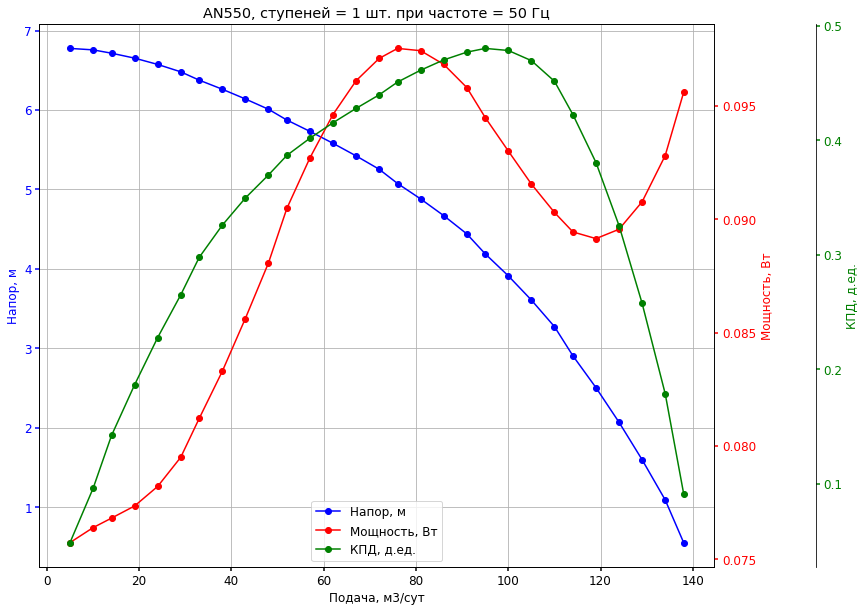

83.3333333333 412


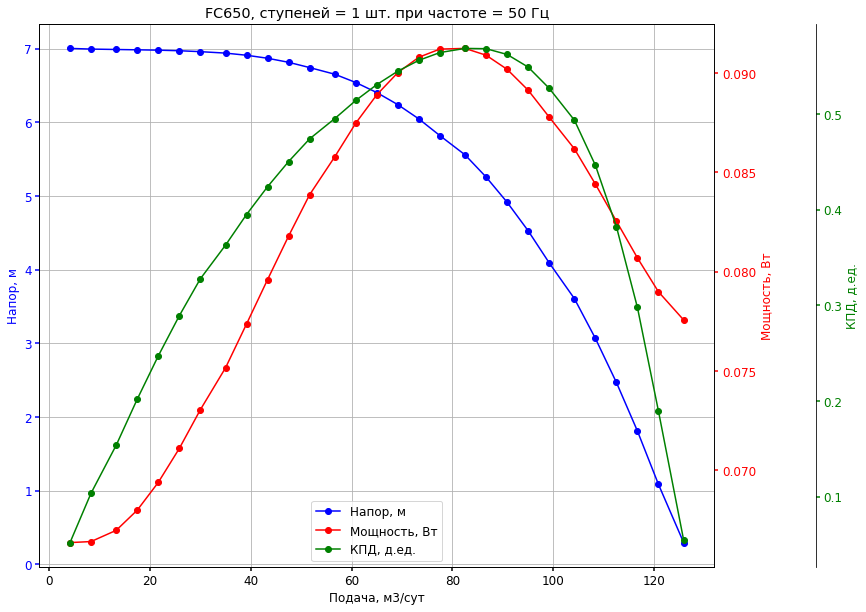

100.0 2753


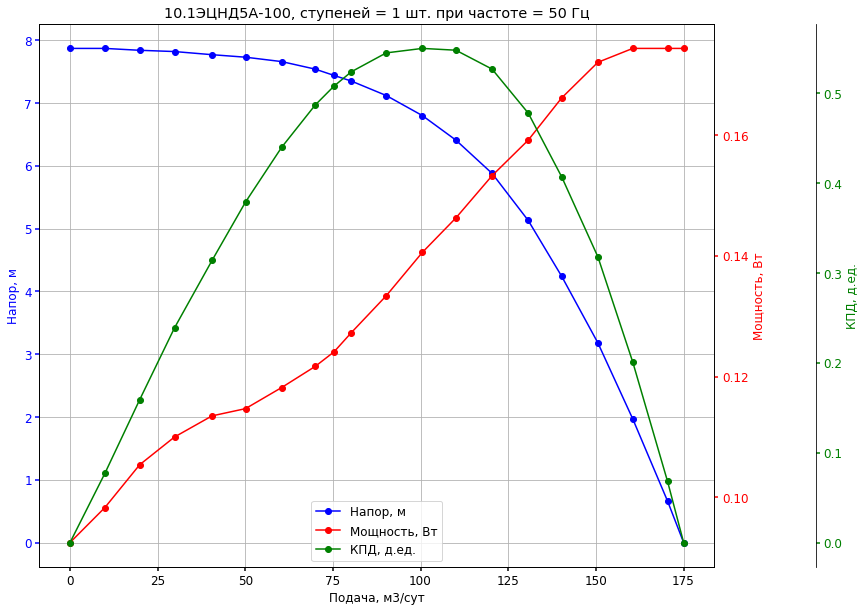

95.0 649


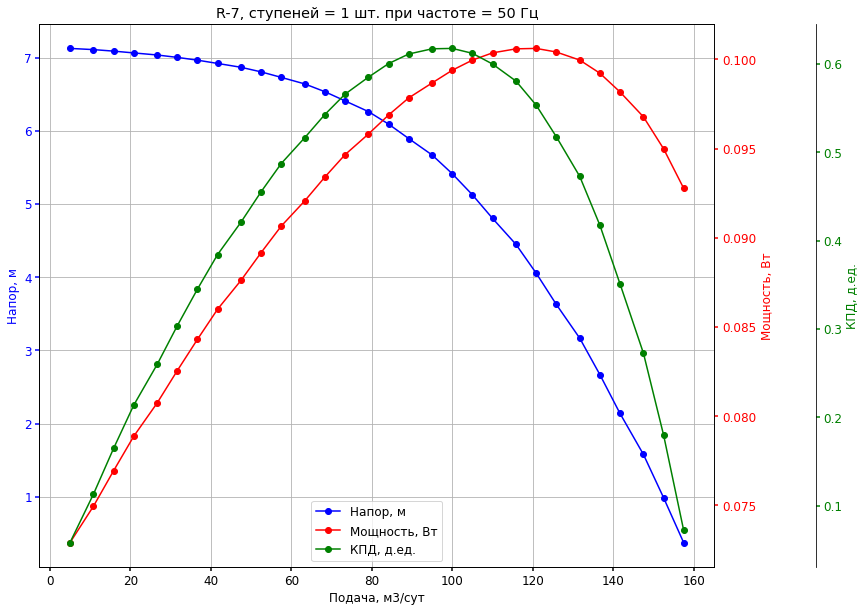

95.0 1105


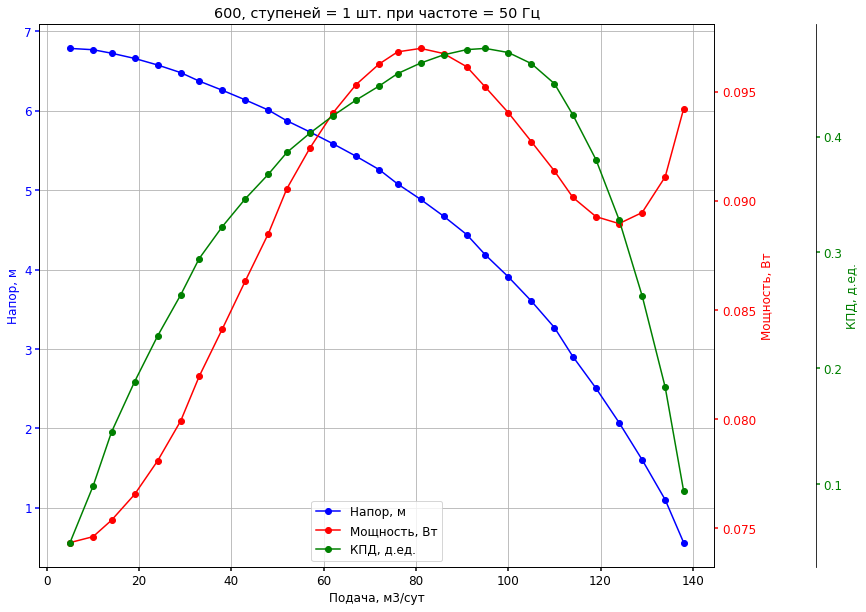

103.0 1111


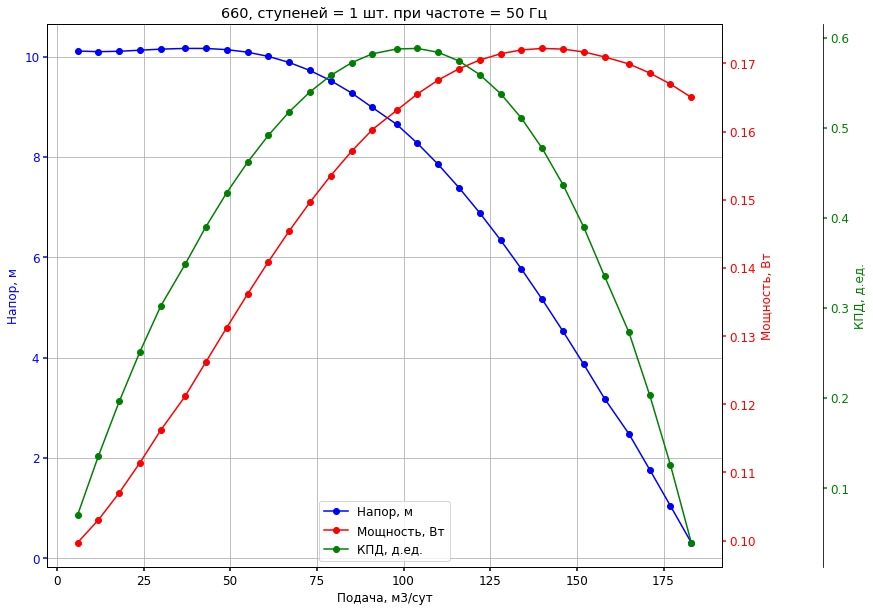

125.0 1258


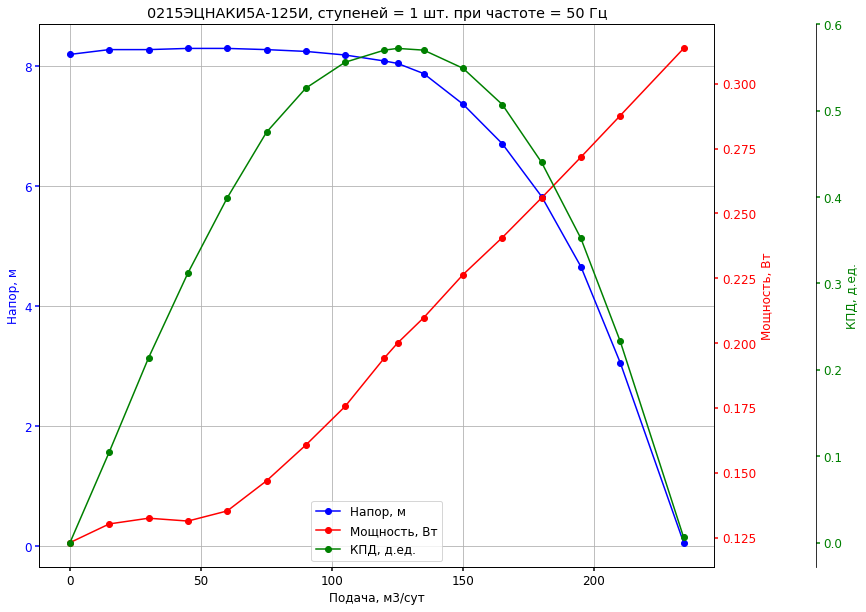

In [51]:
for i in range(result_pumps.shape[0]):
    this_pump = result_pumps.iloc[i]
    print(this_pump['rate_nom_sm3day'], this_pump['ID'])
    plot_pump_curve(q_arr = np.array(this_pump['rate_points']), 
        h_esp_arr = np.array(this_pump['head_points']),
        power_esp_arr = np.array(this_pump['power_points']), 
        efficiency_esp_arr = np.array(this_pump['eff_points']),
             z = 1,
                    esp_name = this_pump['name'], f=50)
    

## Основной цикл: Определения режима работы для выбранного(ых) насоса(ов) !!!

0it [00:00, ?it/s]

pump_id = 1185
esp_head_m = 1500


iter = 0


UniflocVBA 7.28


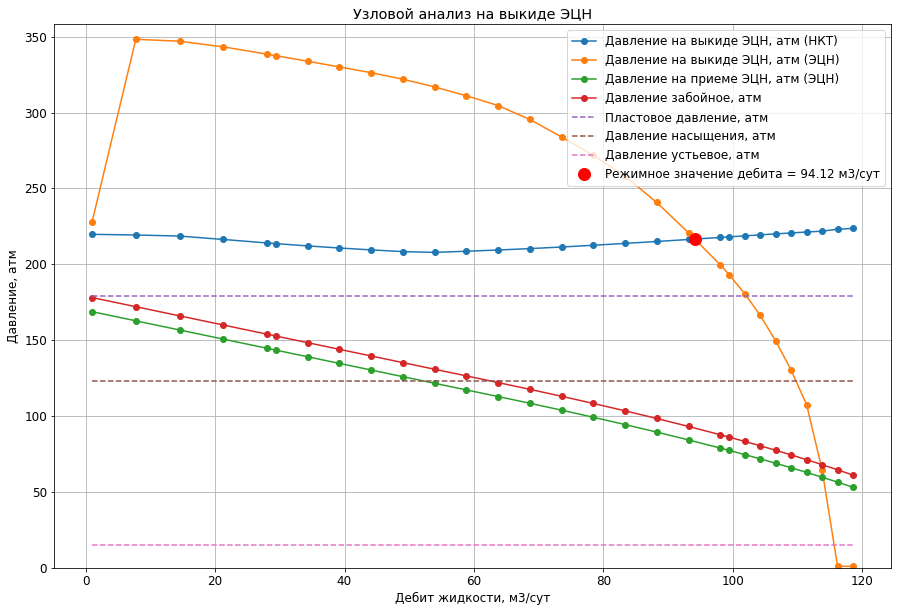

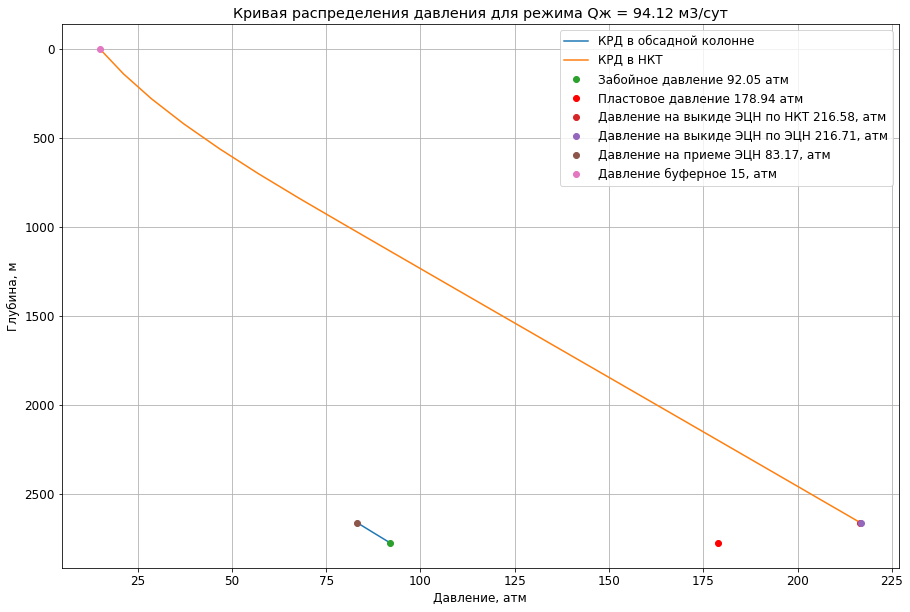

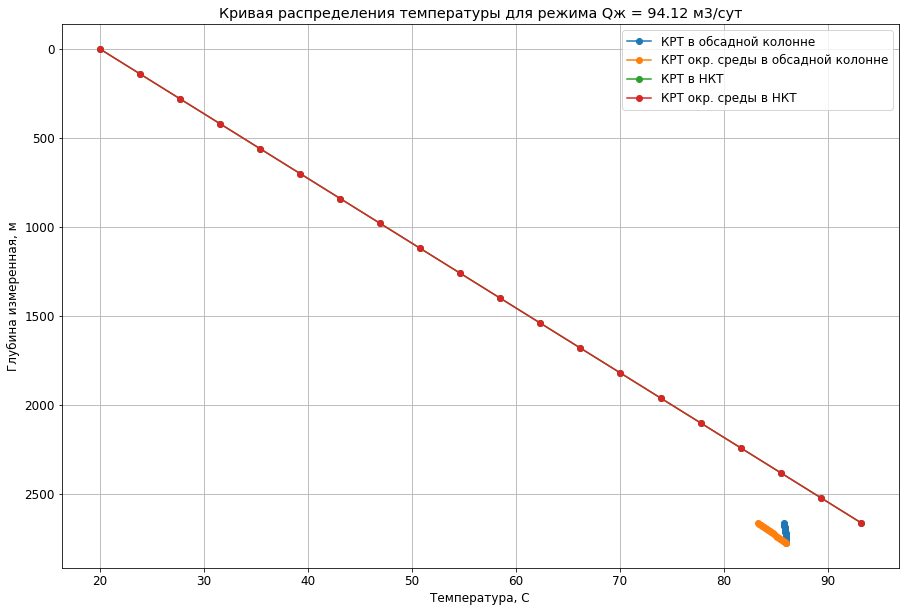

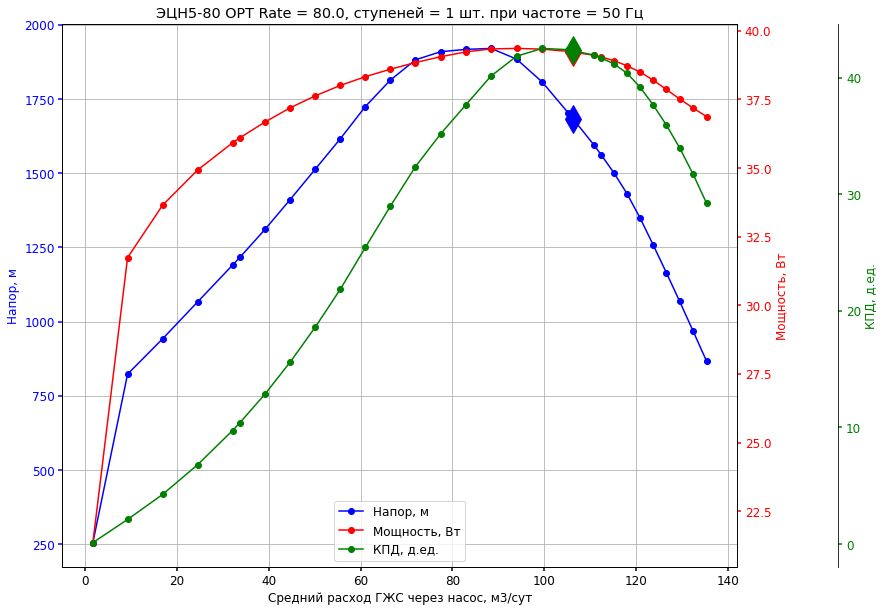

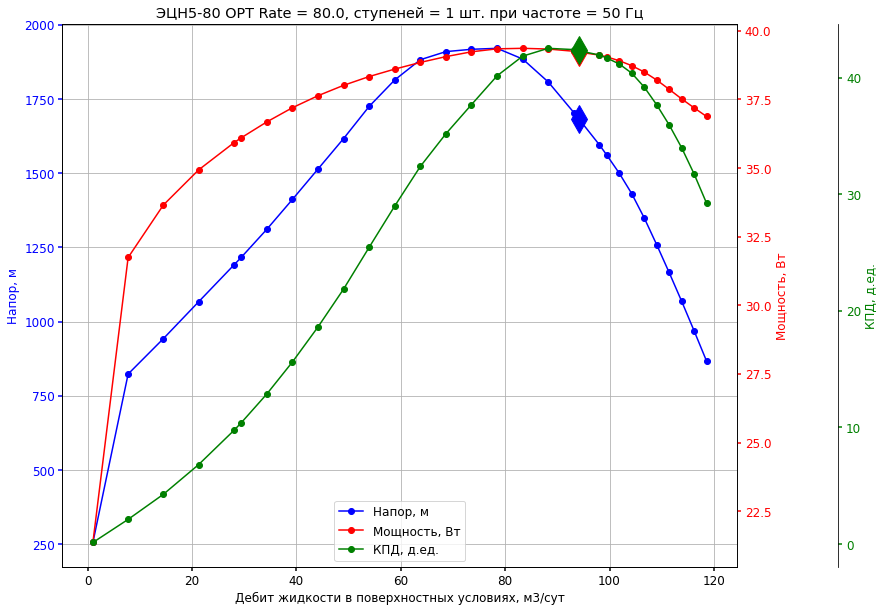

1it [00:07,  7.01s/it]
0it [00:00, ?it/s]

norm calculation sucessful
pump_id = 2753
esp_head_m = 1500


iter = 0


UniflocVBA 7.28


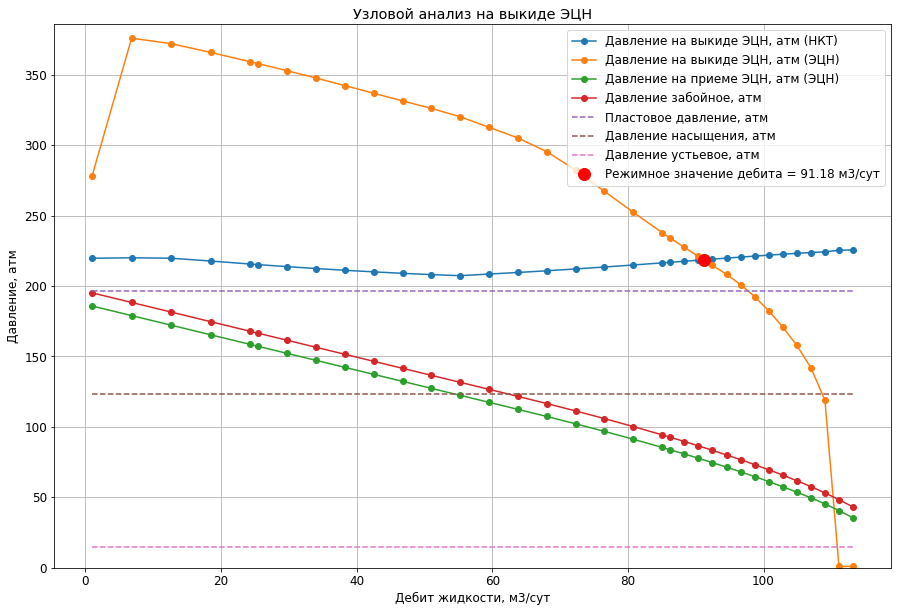

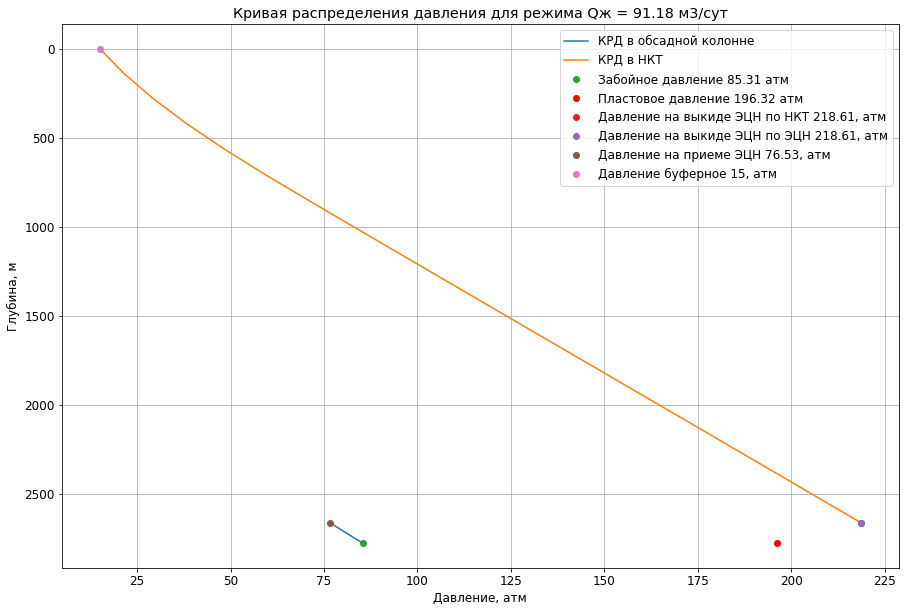

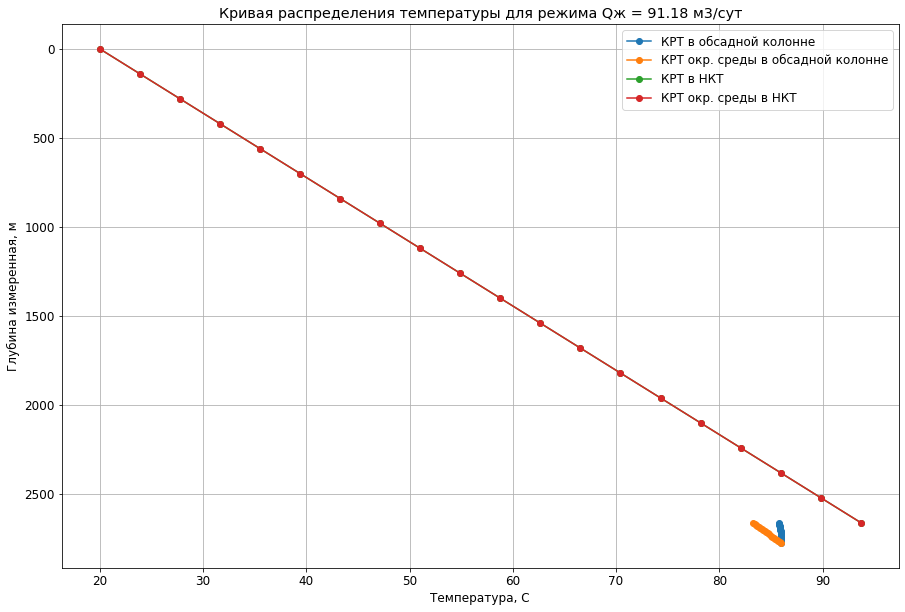

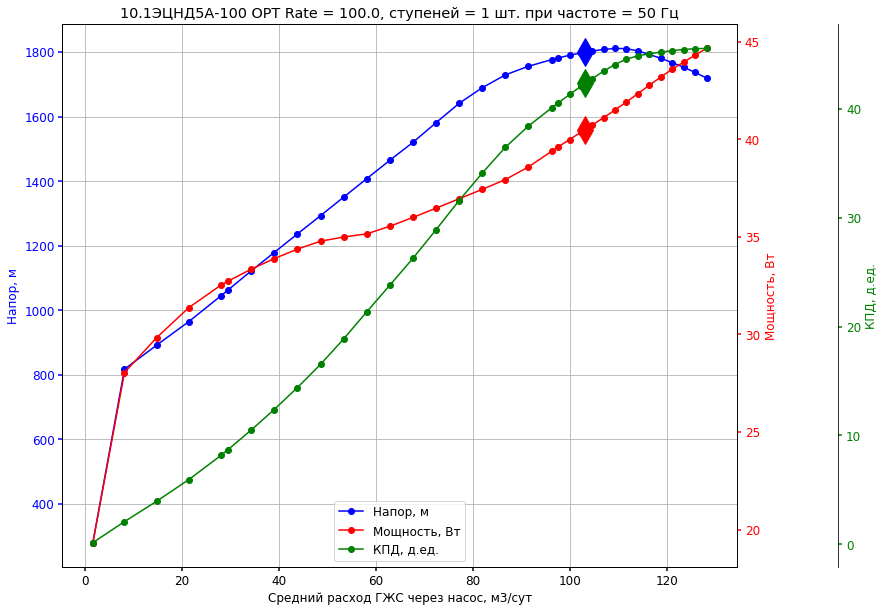

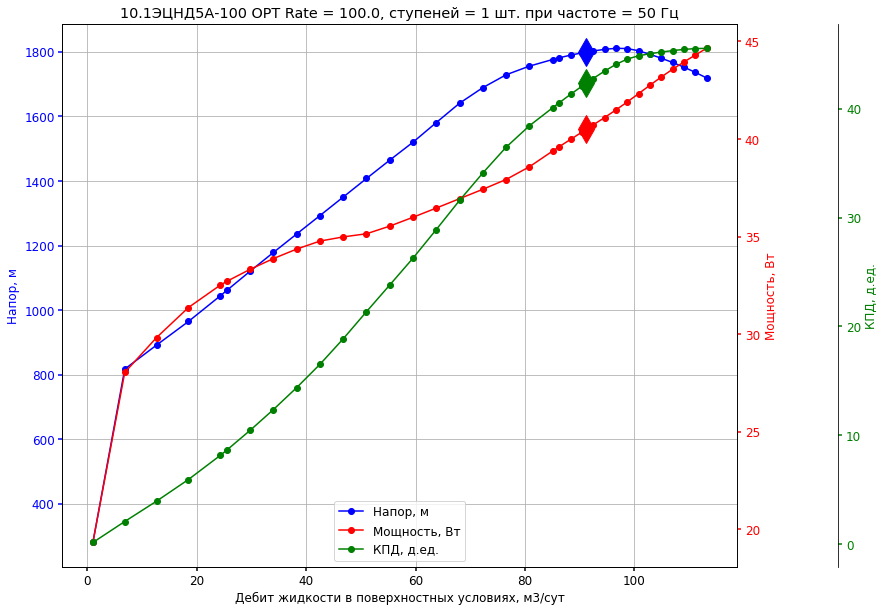

1it [00:07,  7.40s/it]

norm calculation sucessful


In [55]:

params = mult.params

with open('distr.txt') as json_file:
    data = json.load(json_file)
all_stats_q_new, pi_mc, dist_p_res = data['all_stats_q_new'], data['pi_mc'], data['dist_p_res']


num_simulations = 3

pumps_ids = [1185, #80
            2753, #100 проблемная
            
            ]
pumps_heads = [1500]

#legacy
#params['pump_id'] =  936 #80 
#params['pump_id']  = 1460 #125
#params['pump_id']  = 1461 #200
#params['pump_id']  = 2799 #60   
#params['pump_id'] = 685 # 89

#params['esp_head_m'] = 1800

params['n_dots_for_nodal'] = 15
params['calc_esp_new'] = 1


run_design = well_model.run_design  
results = run_design(params, pumps_ids, pumps_heads, pi_mc, dist_p_res, debug=1, num_simulations=1, api=api, api_new=api_new,
              vba_version='7.28', path = r'.\calc_new')
os.chdir('..')
